# **General framework**
The code reports the main experiments of Tausani et al., 2023. The code is thought to be used with Google Colab using Google Drive for storage.
DBN training is an adaptation of the original code of the [Zambra et al., 2022 article](https://link.springer.com/article/10.1007/s12559-022-10085-5), that you can find [here](https://github.com/CCNL-UniPD/iDBN). Remember that the main training parameters for DBN training are stored in the files cparams.json and lparams-(dataset).json.
Be careful to follow the correct foldering of training files.

In [1]:
#TRAINING OF THE iDBN network

#General dependencies
import os
import sys
import torch
import numpy as np
from torchvision import datasets,transforms
import pickle
import json
from tqdm import tqdm
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import pandas as pd
import math
import random
import pickle

#Load the github files
def get_dbn_library(files,repository_url):
  for file in files:
    ! wget -O {file} {repository_url}{file}

get_dbn_library(files = ["RBM.py","plotting_functions.py","utils.py","methods.py"], repository_url = "https://raw.githubusercontent.com/LorenzoTausani/Octave_CPU/master/")
get_dbn_library(files = ["dbns.py","models.py","rbms.py","wftools.py","Classifiers.py","Study_generativity.py","readout_analysis.py"], repository_url = "https://raw.githubusercontent.com/LorenzoTausani/iDBN_Zambra22/master/src/dbn-utls/")

import dbns
import models
import rbms
import wftools
import Study_generativity
import plotting_functions
import Classifiers
import utils
import methods
import readout_analysis

from dbns import *
from models import *
from rbms import *
from wftools import *
from Study_generativity import *
from readout_analysis import *

from RBM import *
from plotting_functions import *
from Classifiers import *
from utils import *
from methods import *

#function for computing SEM
def SEM(measure):
  import math
  nr_of_measures = len(measure)
  if not(isinstance(measure, np.ndarray)):
    measure = np.asarray(measure)
  sem = np.std(measure)/math.sqrt(nr_of_measures)
  return sem

#Here i load or train a DBN. The training parameters are stored in .json files on gDrive
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dbn,train_dataset, test_dataset,classifier= tool_loader_ZAMBRA(DEVICE,  selected_idx = [20,31], only_data = False,last_layer_sz=1000, Load_DBN_yn = 3)

#Linear readout of each DBN layer (from visible layer to the last hidden layer)
Zambra_folder_drive = '/content/gdrive/My Drive/ZAMBRA_DBN/' #main folder
Rdict_load_yn = int(input('Do you want to load an exisiting result dict (1 = yes, 0 = no)'))
if Rdict_load_yn==1:
# Open the file containing the saved dictionary
  with open(Zambra_folder_drive+'SciRep_results.pkl', 'rb') as f:
      # Load the dictionary from the file using the pickle module
      Results_dict = pickle.load(f)
else:
  Results_dict={}

if not(dbn.fname in Results_dict):
  Results_dict[dbn.fname]={}

if not('readout' in Results_dict[dbn.fname]):
  readout_acc_V, classifier_list = readout_V_to_Hlast(dbn,train_dataset,test_dataset)
  Results_dict[dbn.fname]['readout']=readout_acc_V

--2023-12-13 17:08:12--  https://raw.githubusercontent.com/LorenzoTausani/Octave_CPU/master/RBM.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8554 (8.4K) [text/plain]
Saving to: ‘RBM.py’

RBM.py              100%[===================>]   8.35K  --.-KB/s    in 0s      

2023-12-13 17:08:12 (72.6 MB/s) - ‘RBM.py’ saved [8554/8554]

--2023-12-13 17:08:12--  https://raw.githubusercontent.com/LorenzoTausani/Octave_CPU/master/plotting_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16420 (16K) [text/plain]
Saving to: ‘p

/usr/local/lib/python3.10/dist-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:451.)
  _C._set_default_tensor_type(t)


BATCH_SIZE 128
Do you want to load a iDBN (Zambra 22 style) or do you want to train it? (1=yes, 0=no)1
Do you want to load an exisiting result dict (1 = yes, 0 = no)1


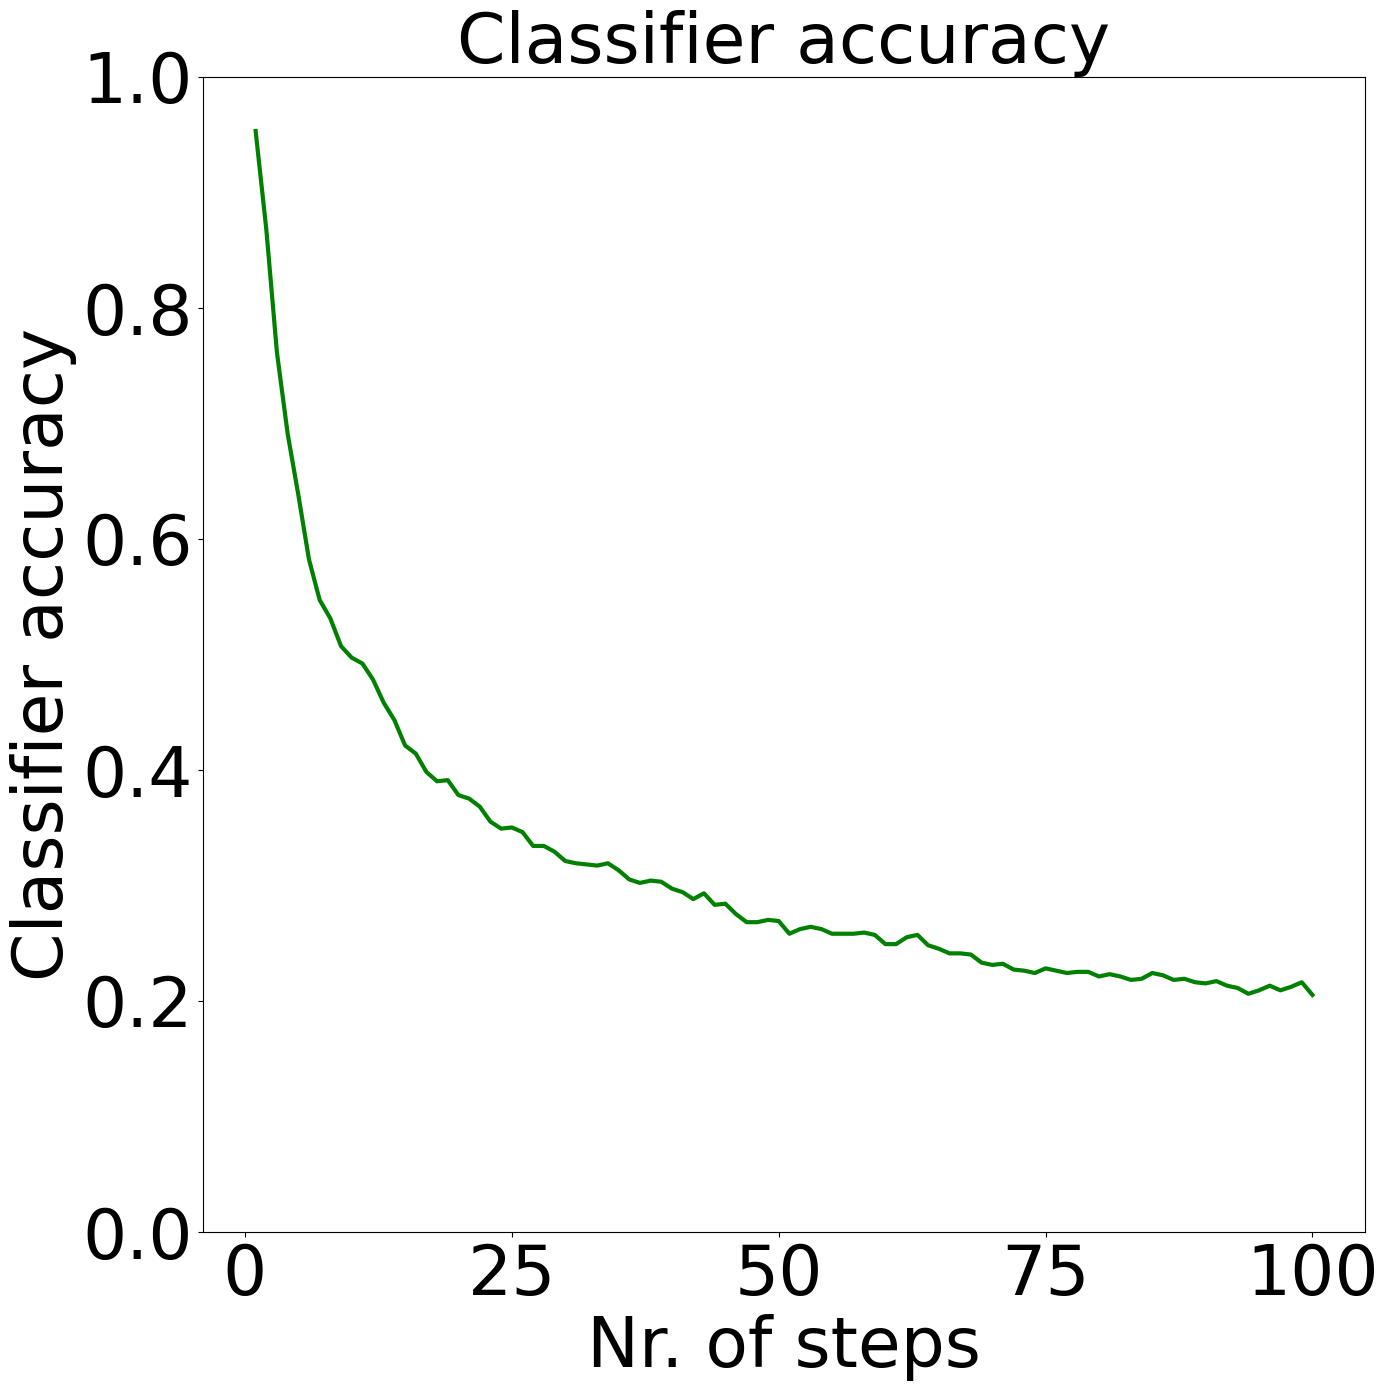

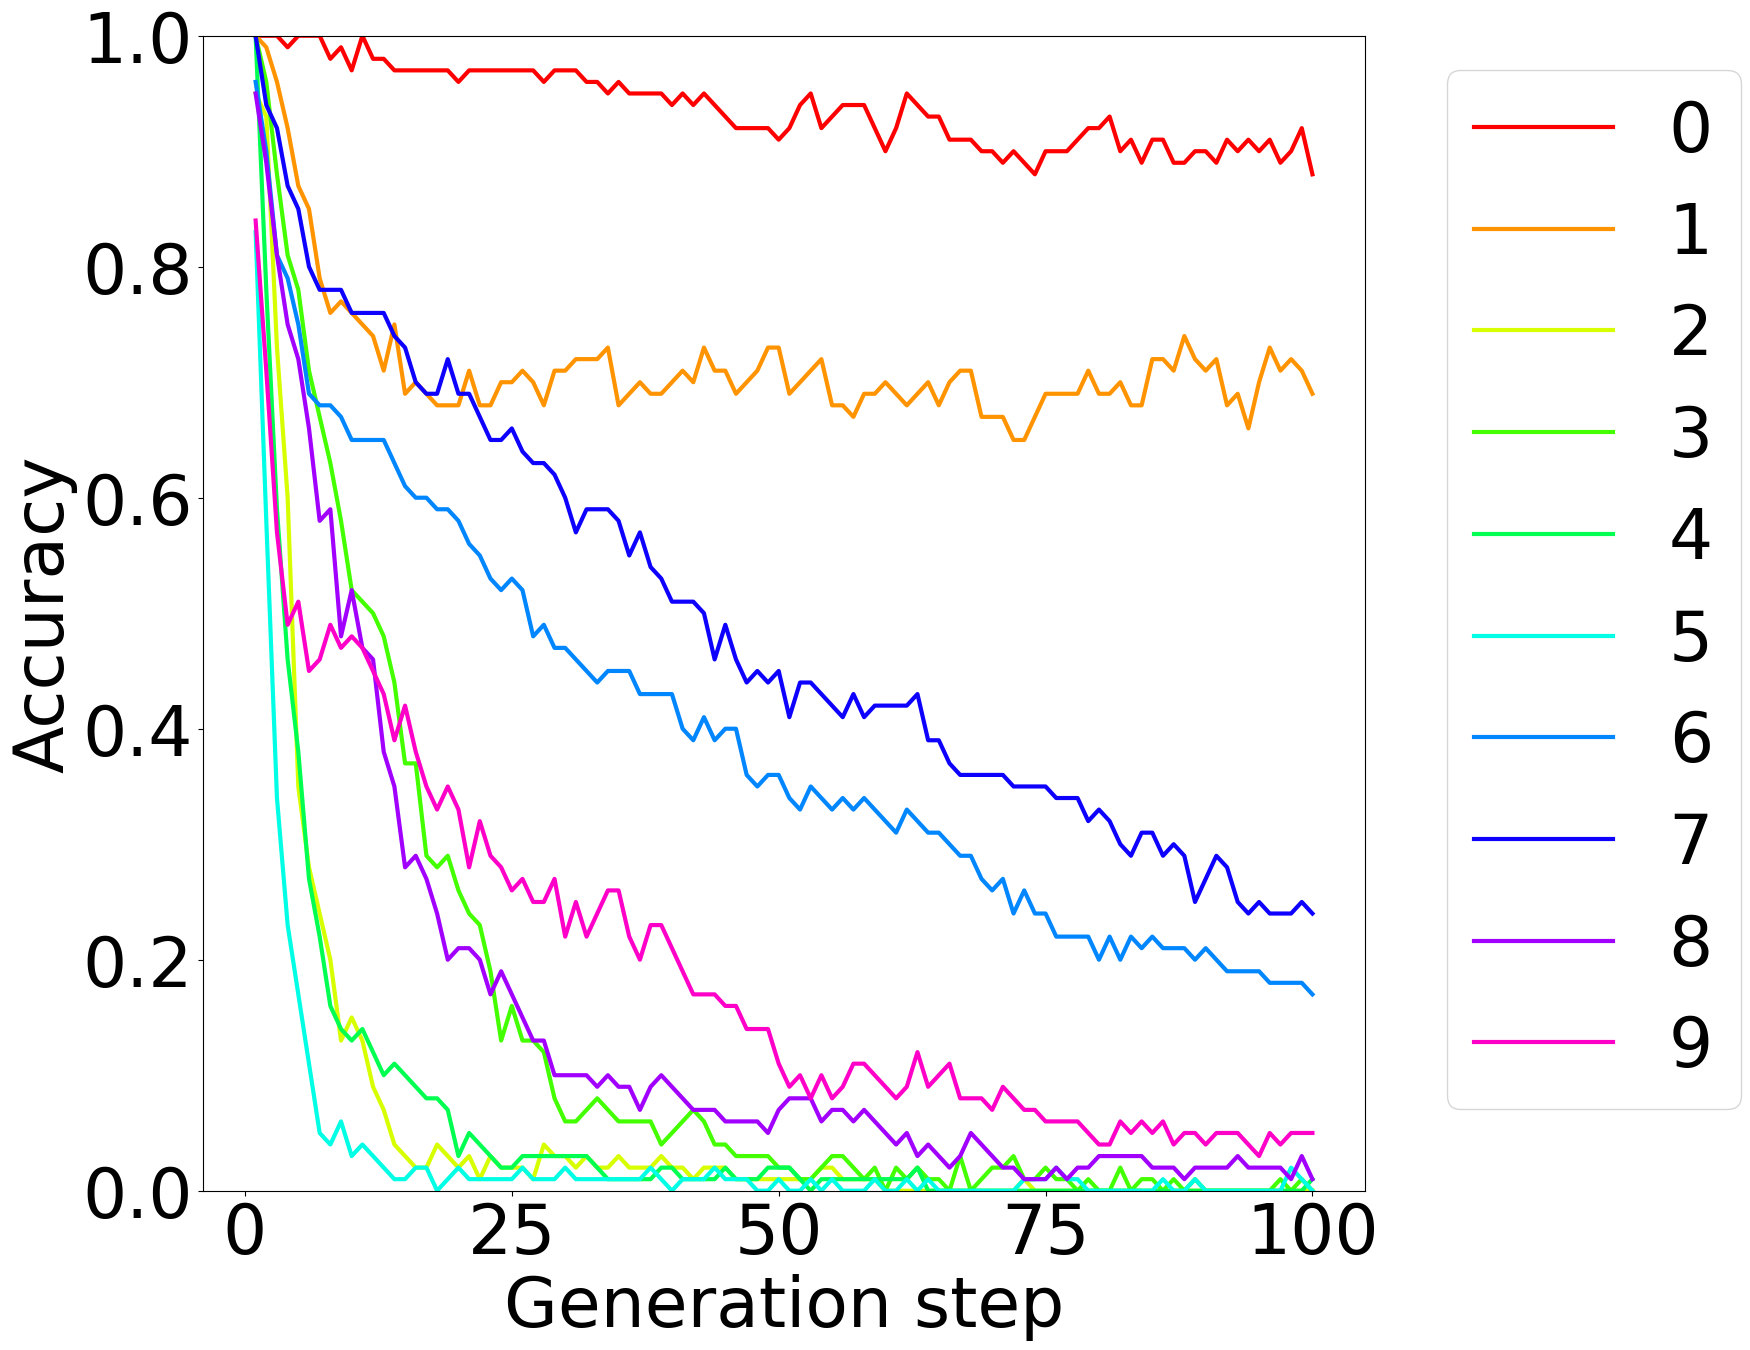

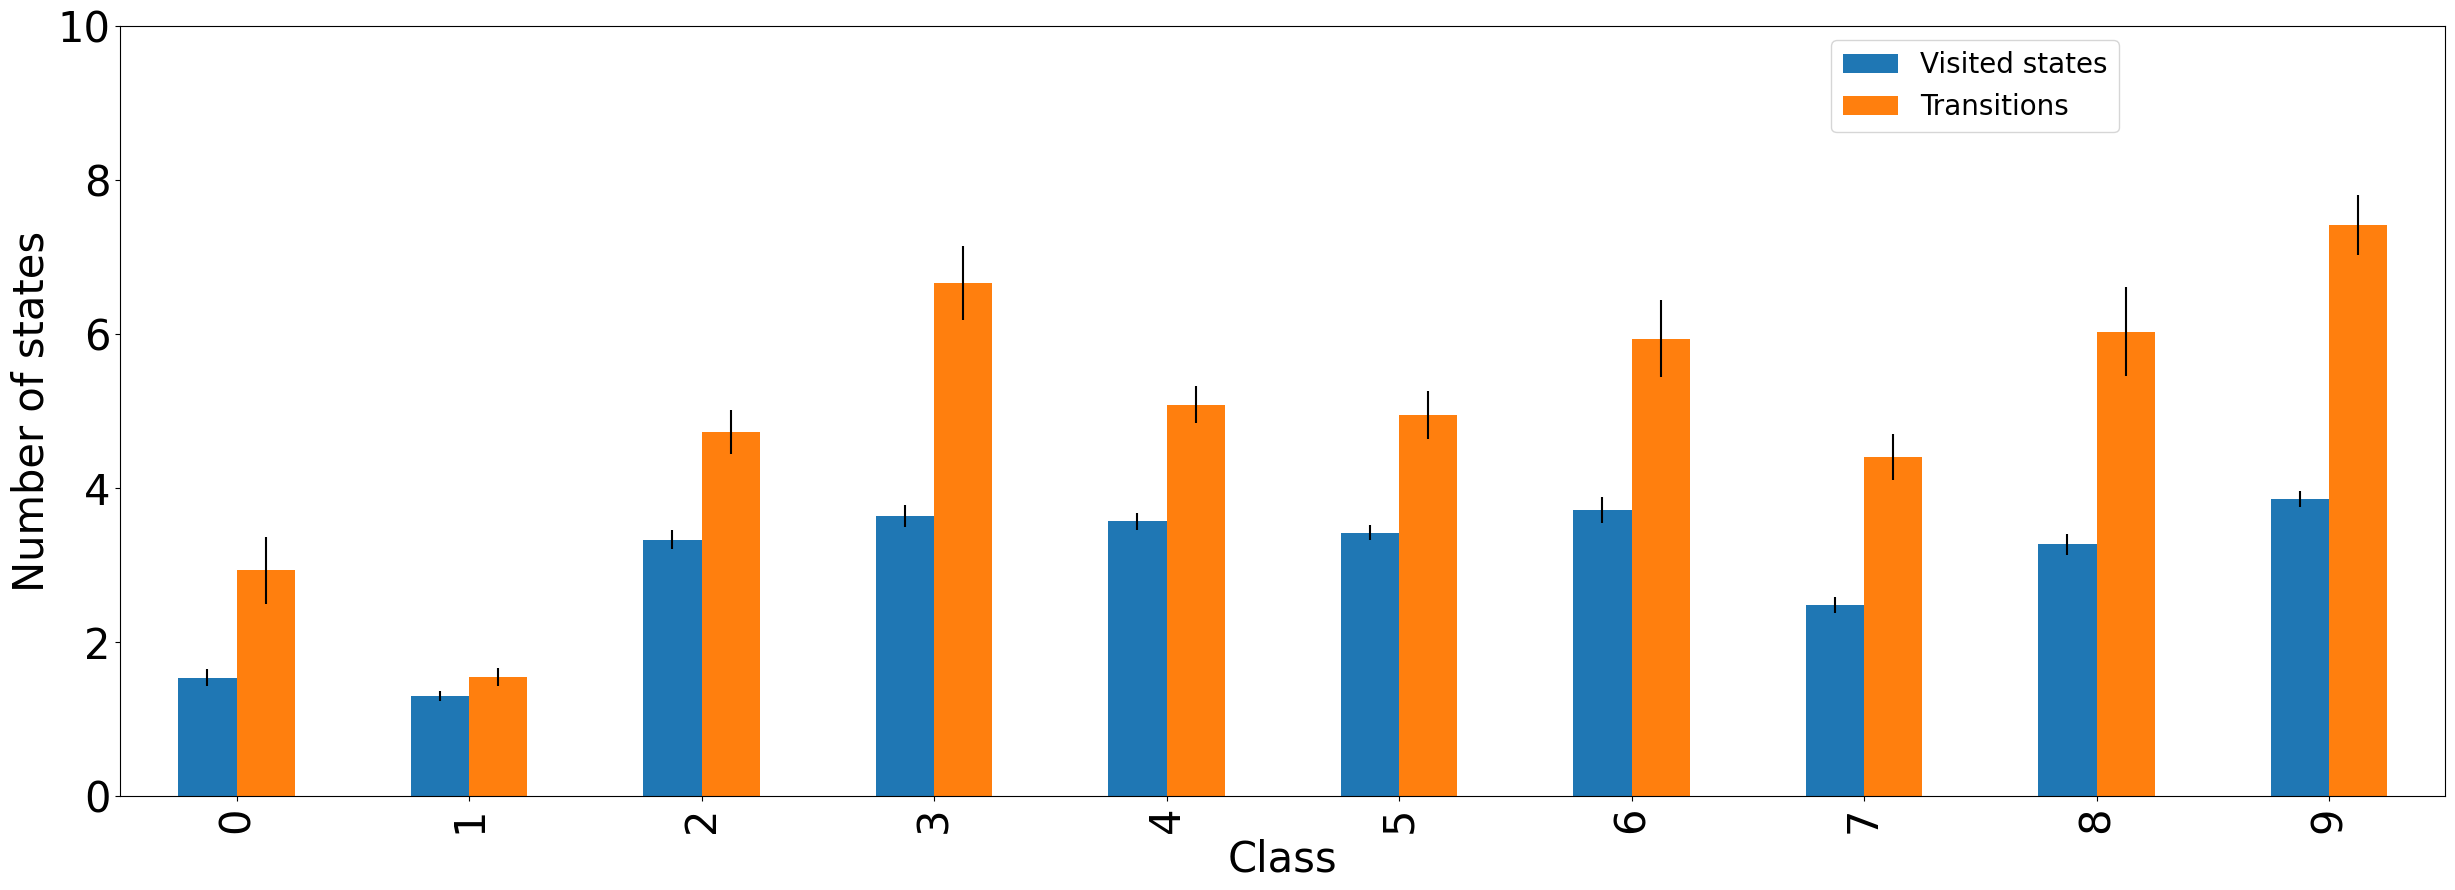

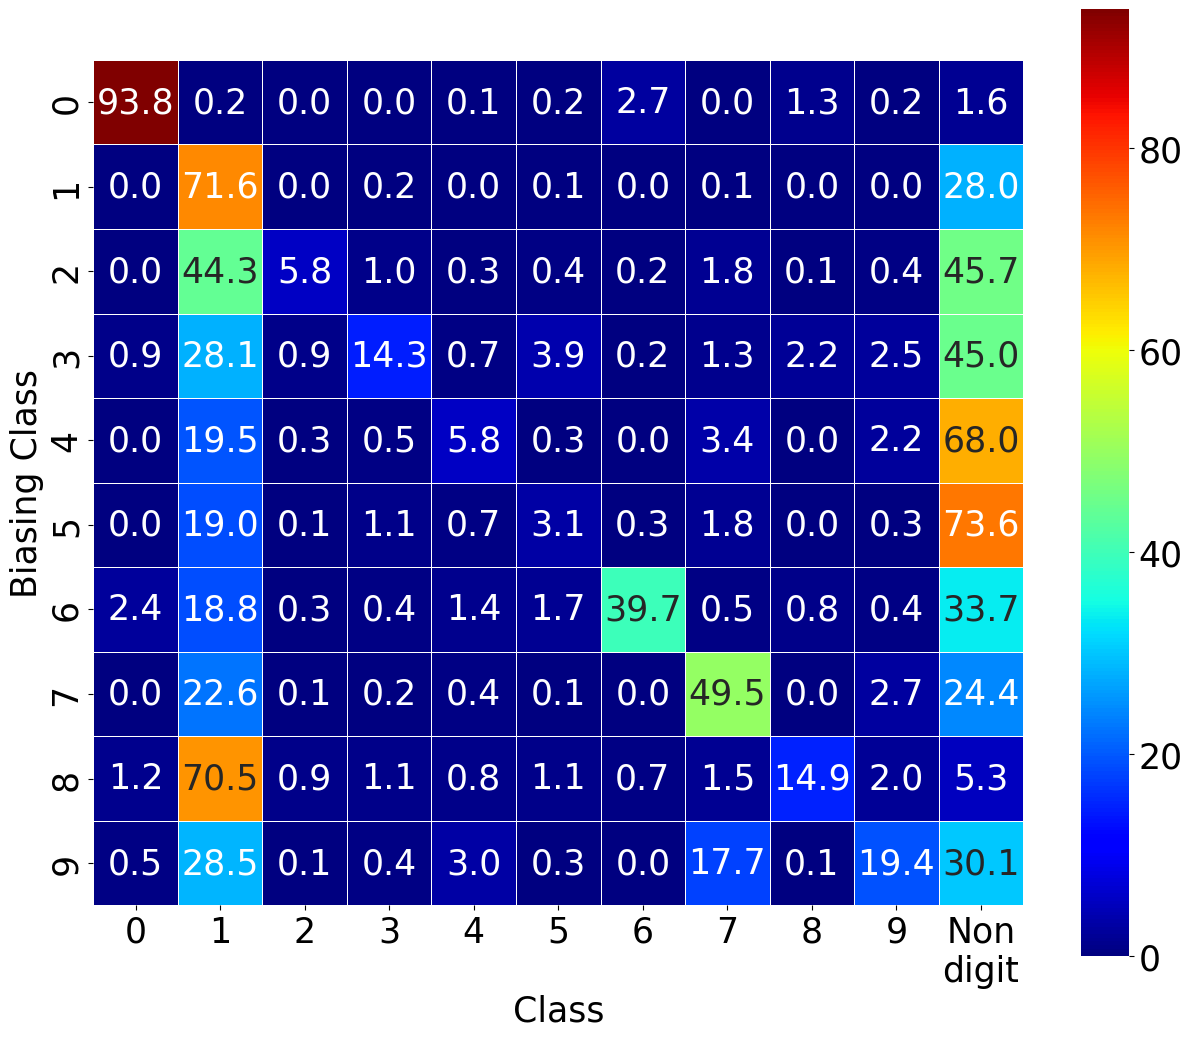

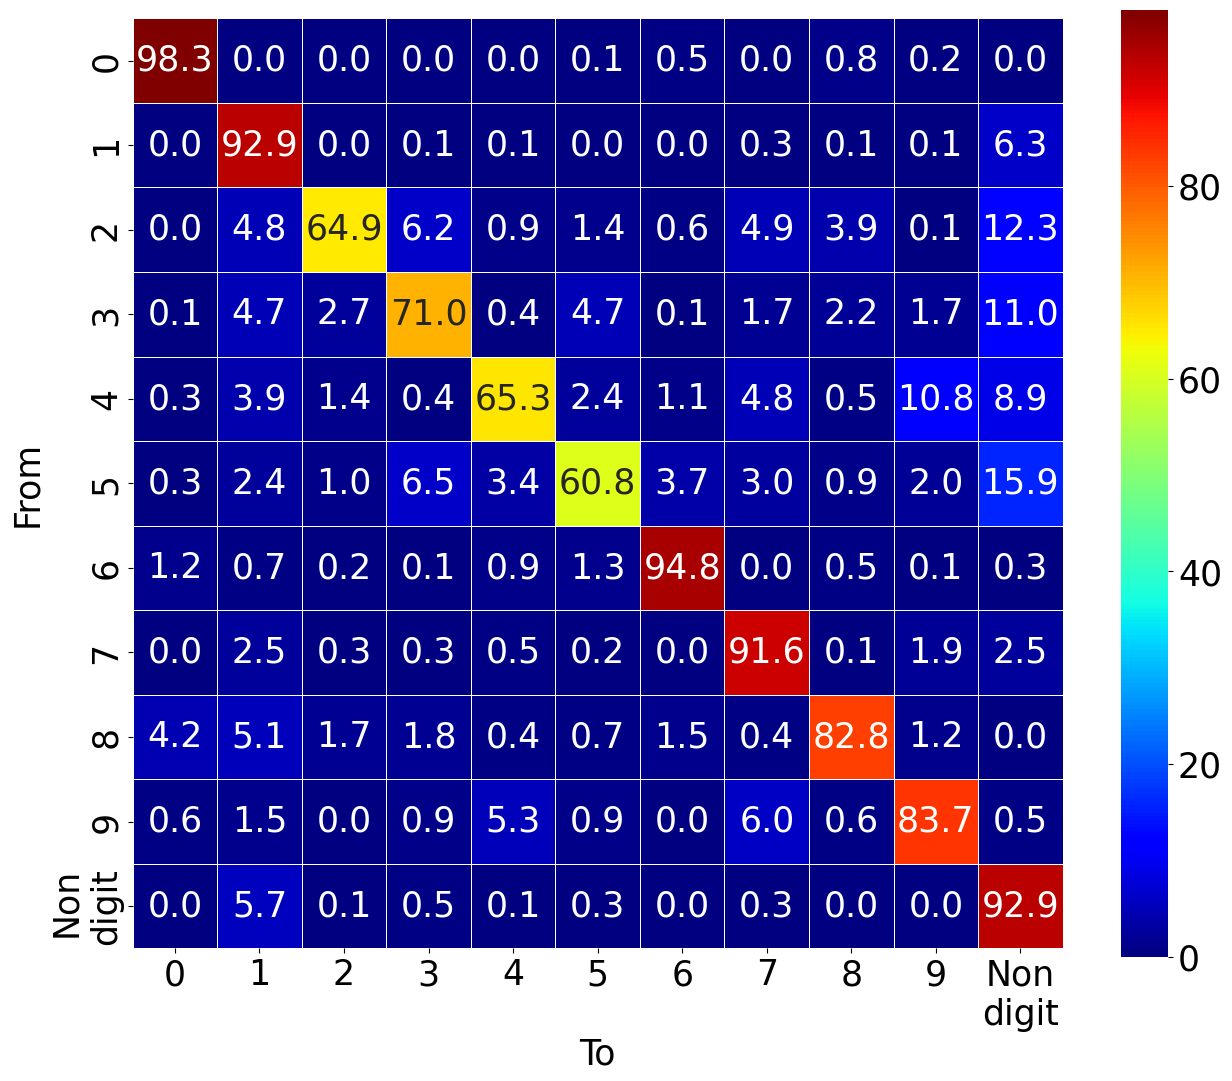

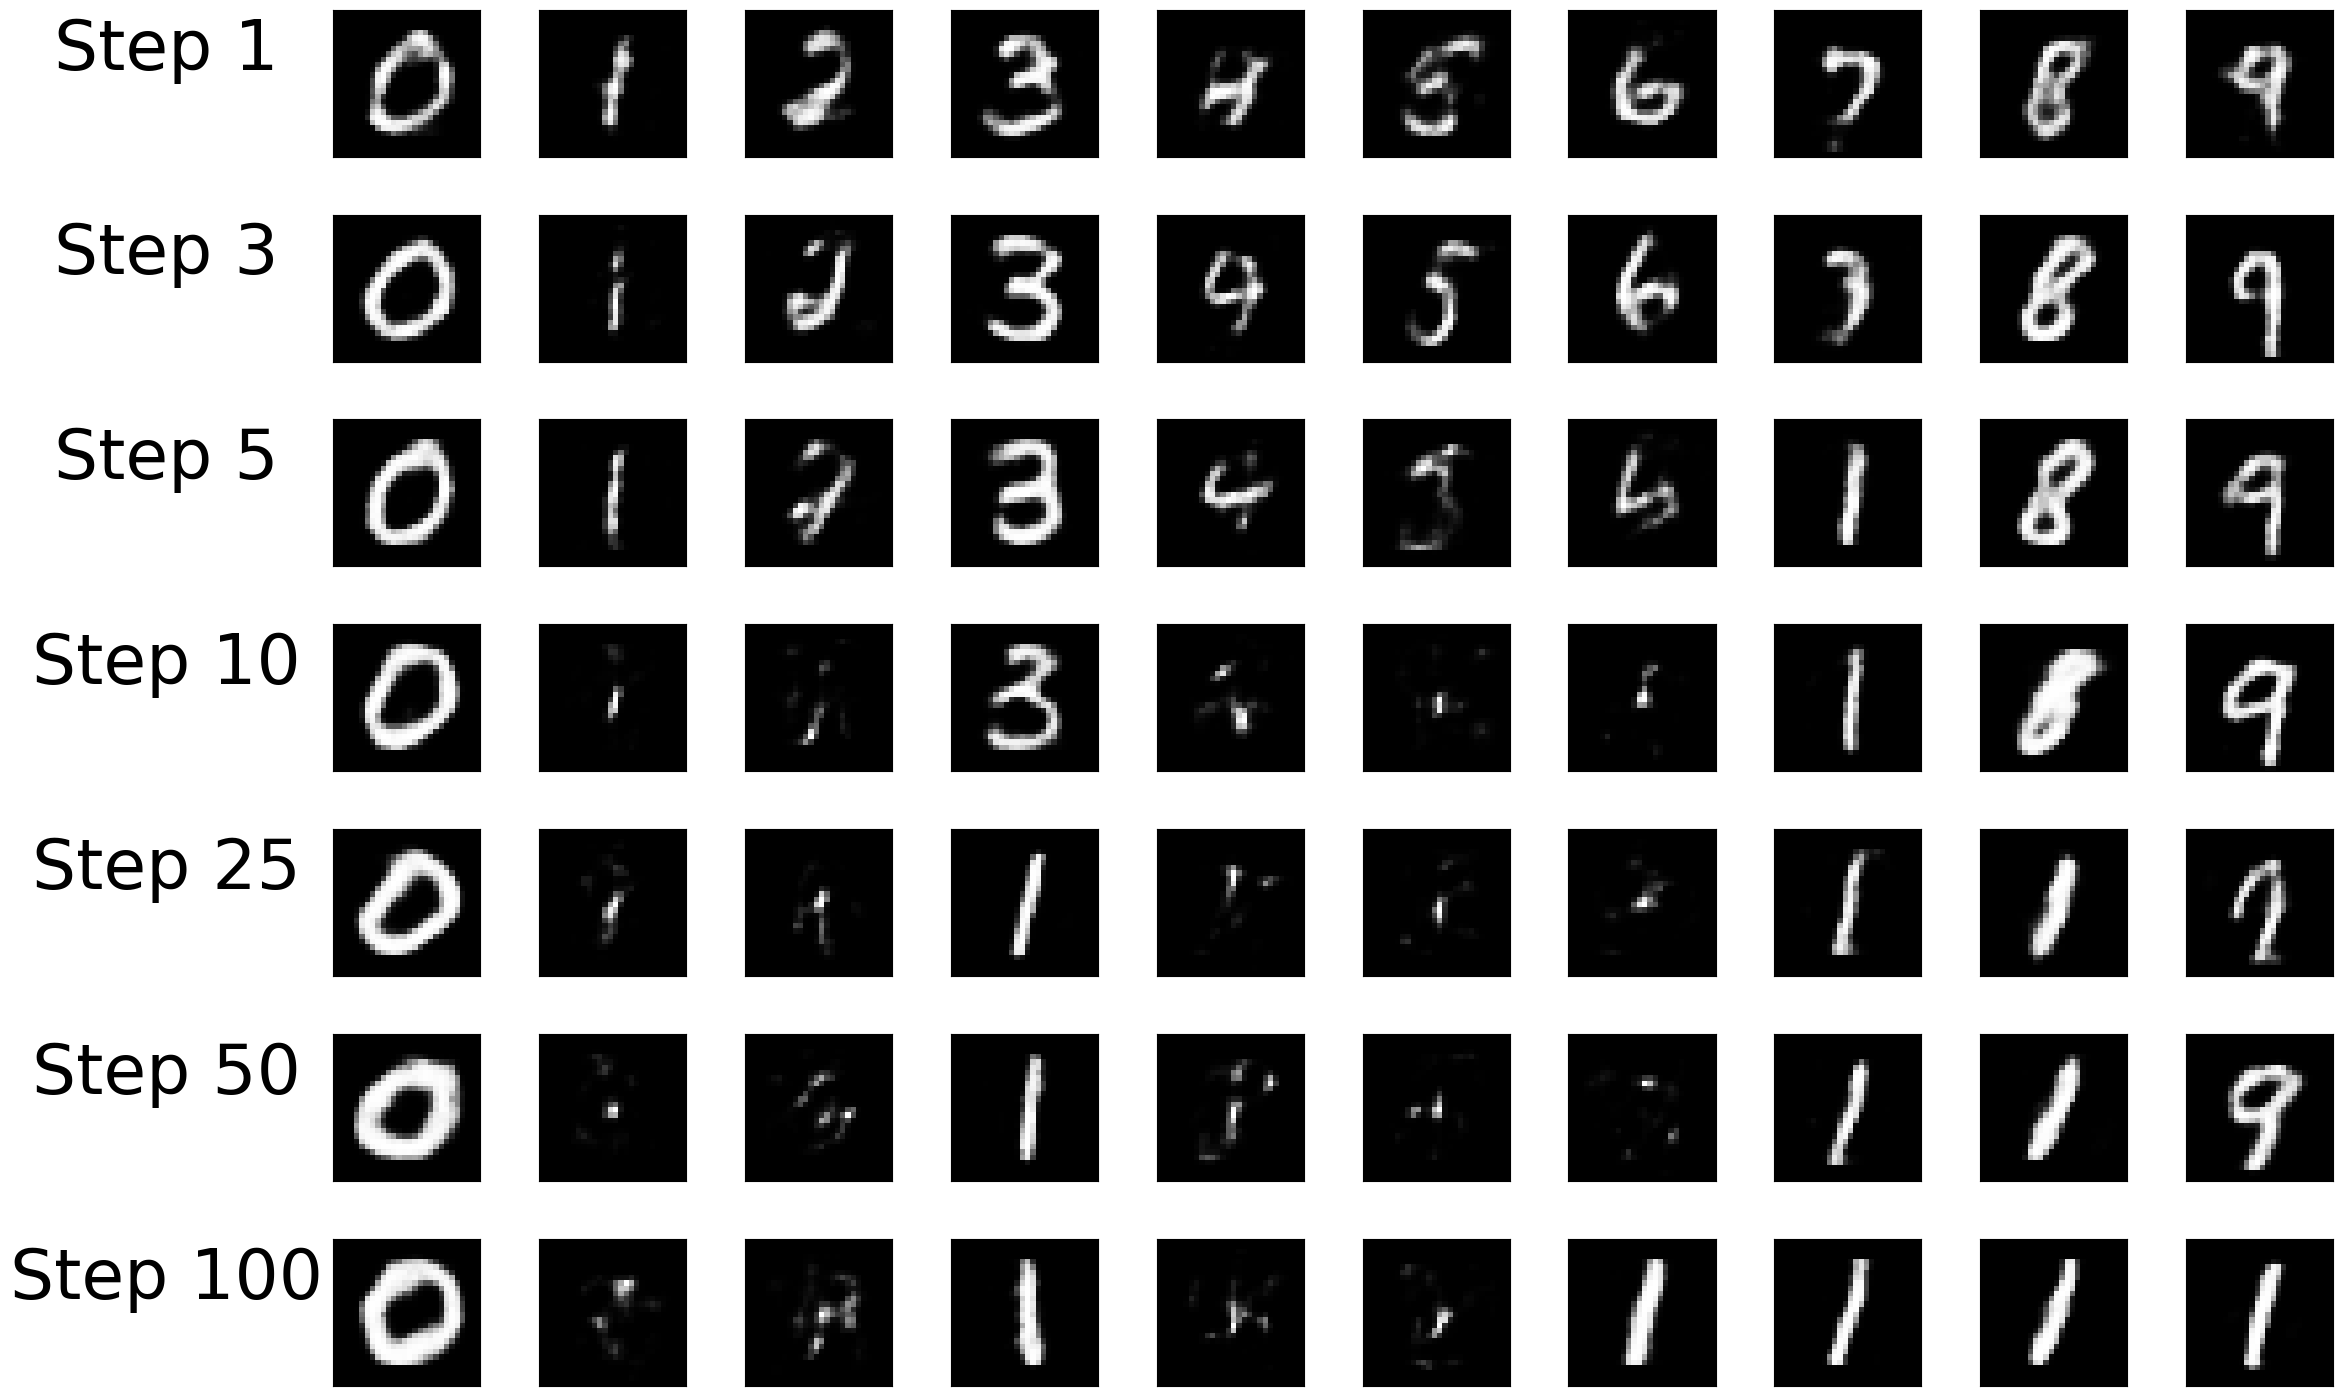

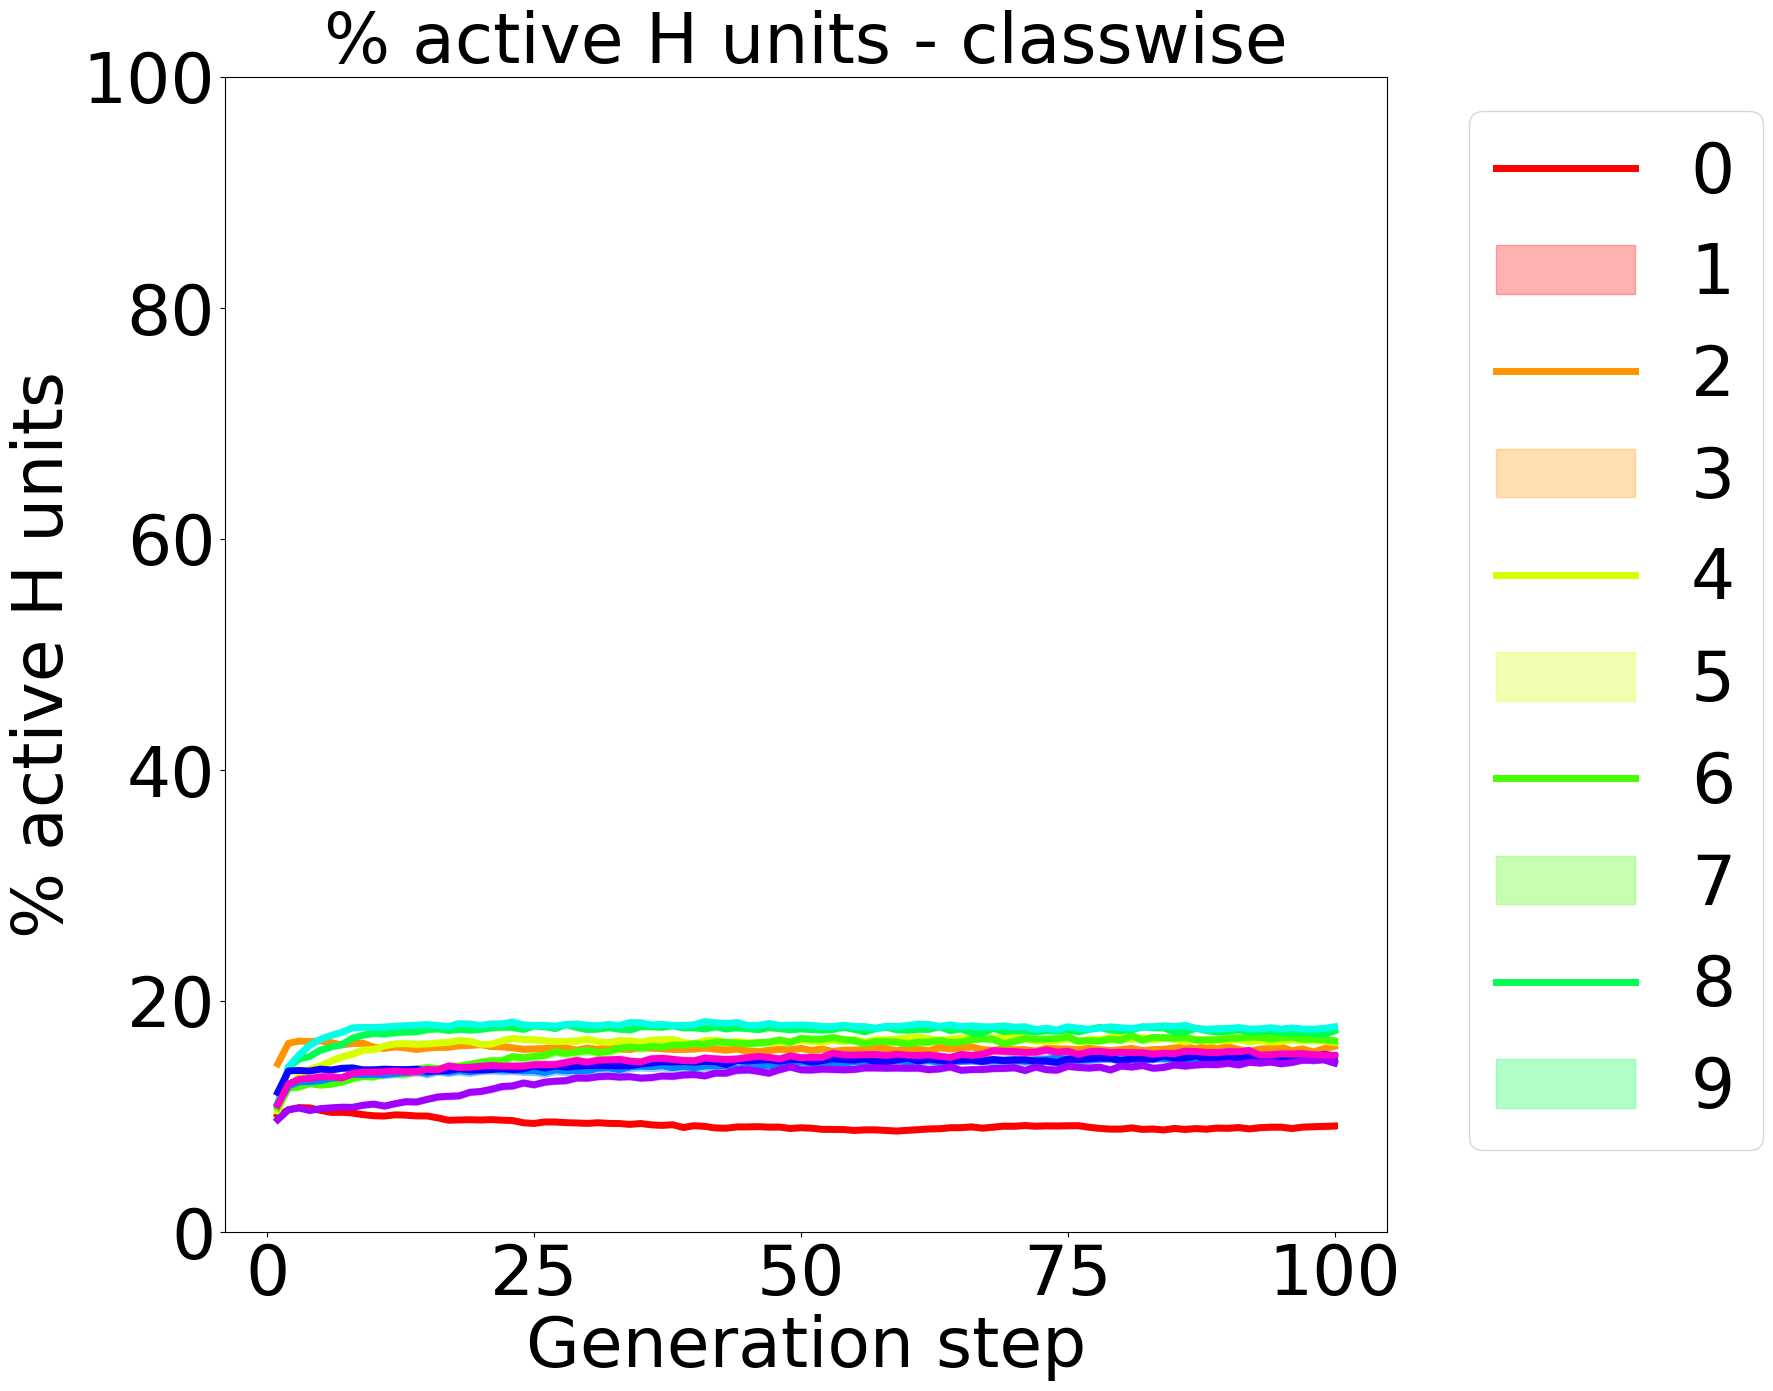

In [2]:
'''
Classic label biasing (LB) characterization
OUTPUT PLOTS:
1) overall classifier accuracy as a function of generation step
2) classwise classifier accuracy as a function of generation step
3) Average p/m SEM number of visited states and number of transitions for each biasing class
4) Average number of generation steps per digit state for each biasing class
5) Transition matrix
6) Example generations - one per class
7) % of active hidden units as a function of the generation step - classwise
'''

#create a matrix where every row is a LB biasing vector.
# First, let's create a LB vector for each digit
for dig in range(dbn.Num_classes):
  g_H = label_biasing_ZAMBRA(dbn, on_digits=dig, topk = -1)
  if dig == 0:
    g_H0to9 = g_H
  else:
    g_H0to9 = torch.hstack((g_H0to9,g_H))

gen_hidden_100rep = g_H0to9.repeat(1,100) #let's repeat each row 100 times (to compute some statistics about the generation)
#VStack_labels contains the labels for each of the LB vector. This will help for computing classification accuracy
#as a function of the generation step
VStack_labels=torch.tensor(range(dbn.Num_classes), device = 'cuda')
VStack_labels=VStack_labels.repeat(100)

#Let's do 100 generation steps for each LB biasing hidden vector
dict_DBN_lBias_classic = generate_from_hidden_ZAMBRA(dbn, gen_hidden_100rep, nr_gen_steps=100)
#now we compute classification accuracy as a function of the generation step
d_cl = Classifier_accuracy(dict_DBN_lBias_classic, classifier,dbn, labels=VStack_labels, Batch_sz= 100,  plot=2, dS=50, l_sz=3)
#We compute the classification metrics, such as nr of visited states and the transition metrices (see Methods)
if dbn.dataset_id=='MNIST':
  df_average_classicLB,df_sem_classicLB, Transition_matrix_rowNorm_classicLB = classification_metrics(d_cl,dbn, VStack_labels)
else:
  df_average_classicLB,df_sem_classicLB, Transition_matrix_rowNorm_classicLB = classification_metrics(d_cl,dbn, VStack_labels,T_mat_labels=['F ∧ nS', 'M ∧ nS', 'F ∧ S', 'M ∧ S'])
#Let's plot some generation examples (one per LB class (e.g. 0 to 9 for MNIST))
Plot_example_generated(dict_DBN_lBias_classic, num_classes = 10, dS= 50, lblpad=120)
#We compute the percentage of hidden units active as a function of time
Mean, Sem = Perc_H_act(dbn, VStack_labels, gen_data_dictionary=dict_DBN_lBias_classic, dS = 50, l_sz = 5, layer_of_interest=2)

#If you are collecting new results, uncomment the following line
Results_dict[dbn.fname]['Nr_visited_states_LB']=df_average_classicLB['Nr_visited_states']

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

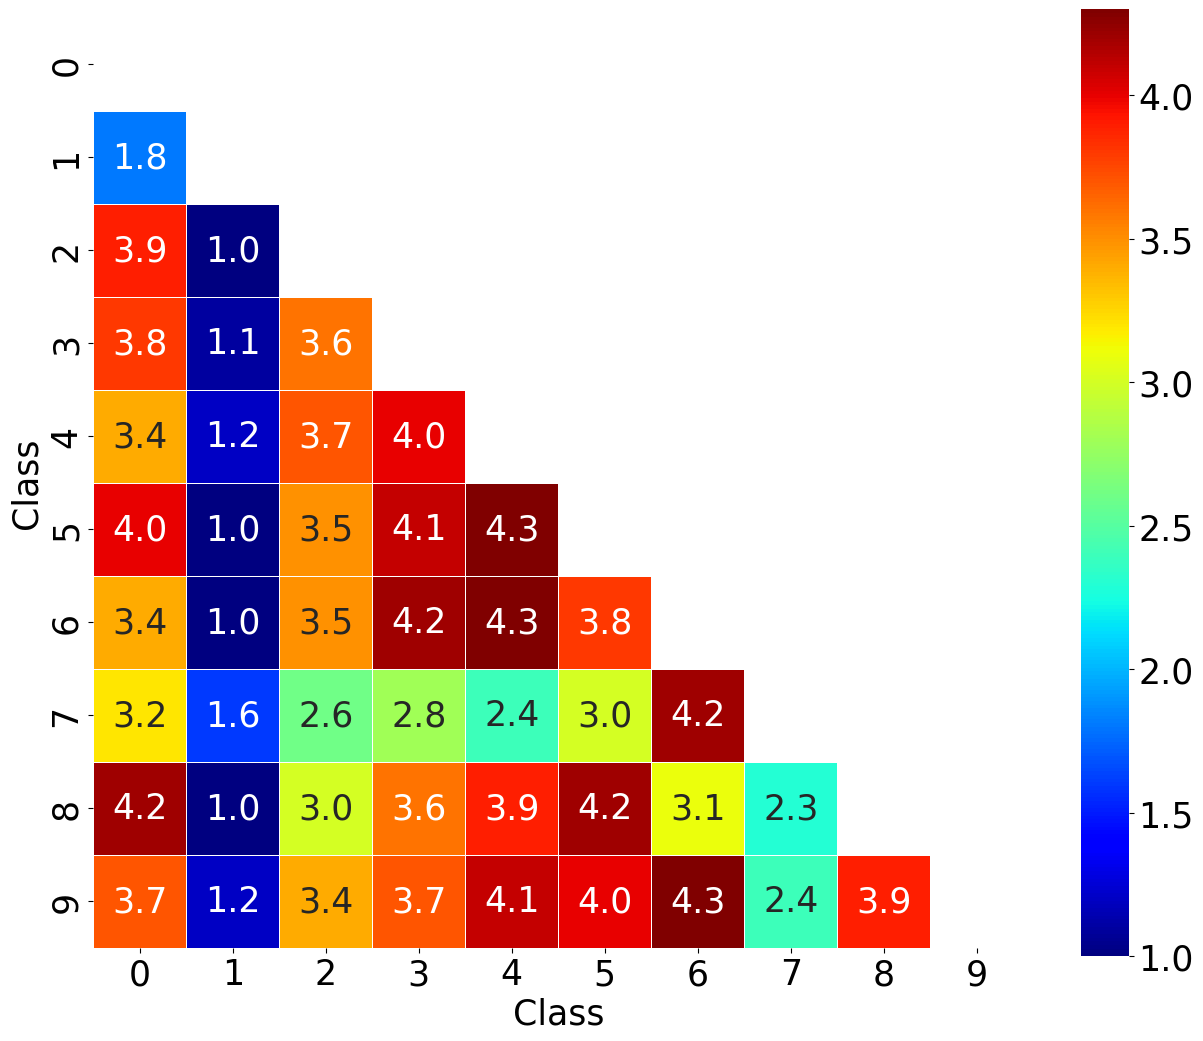

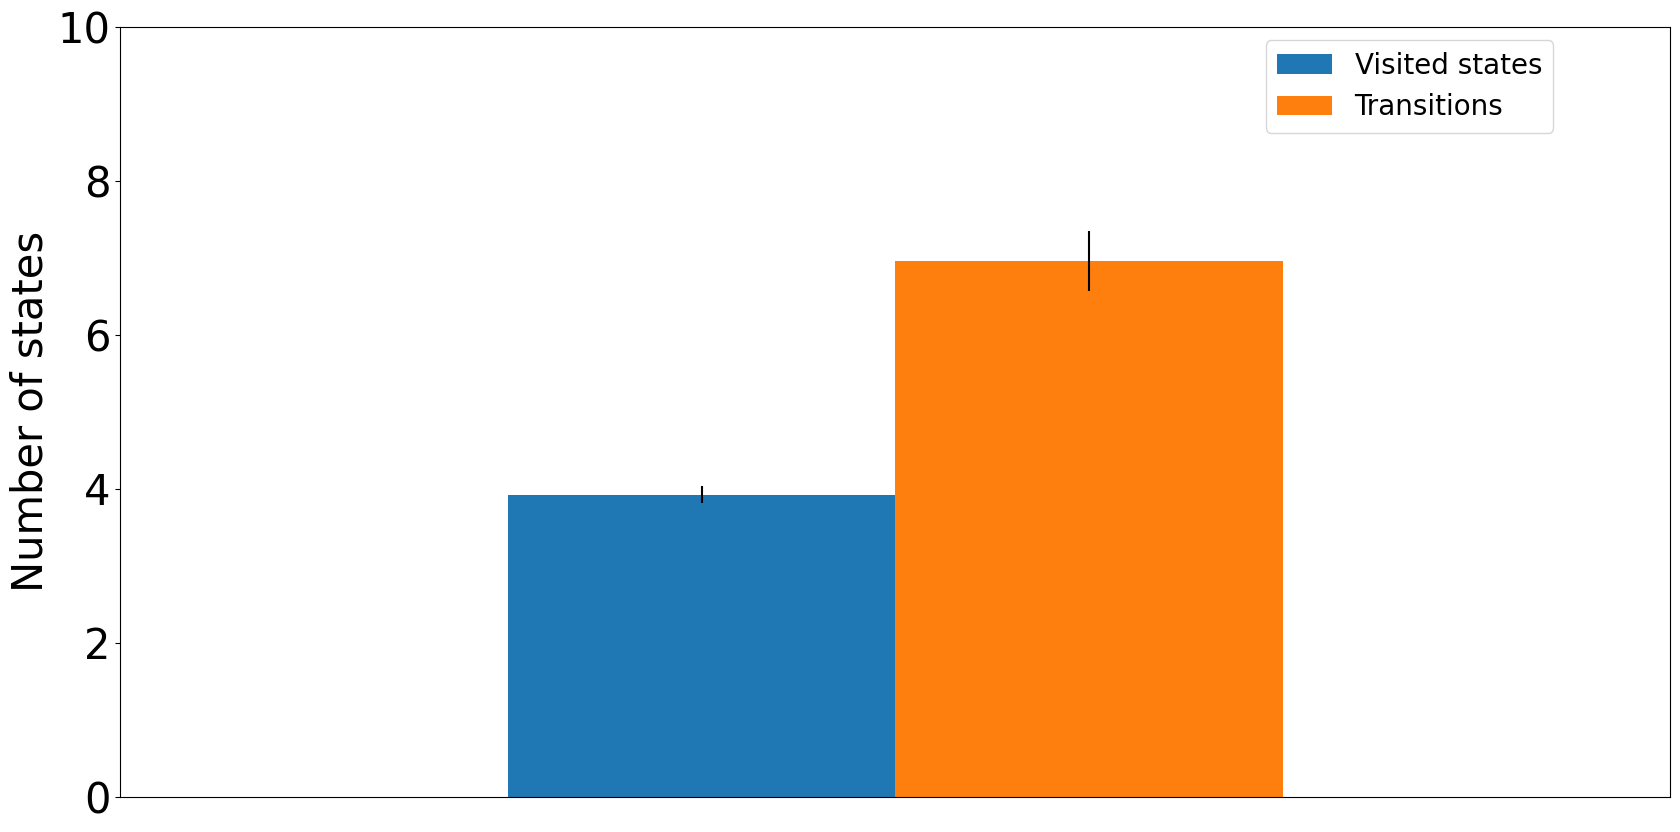

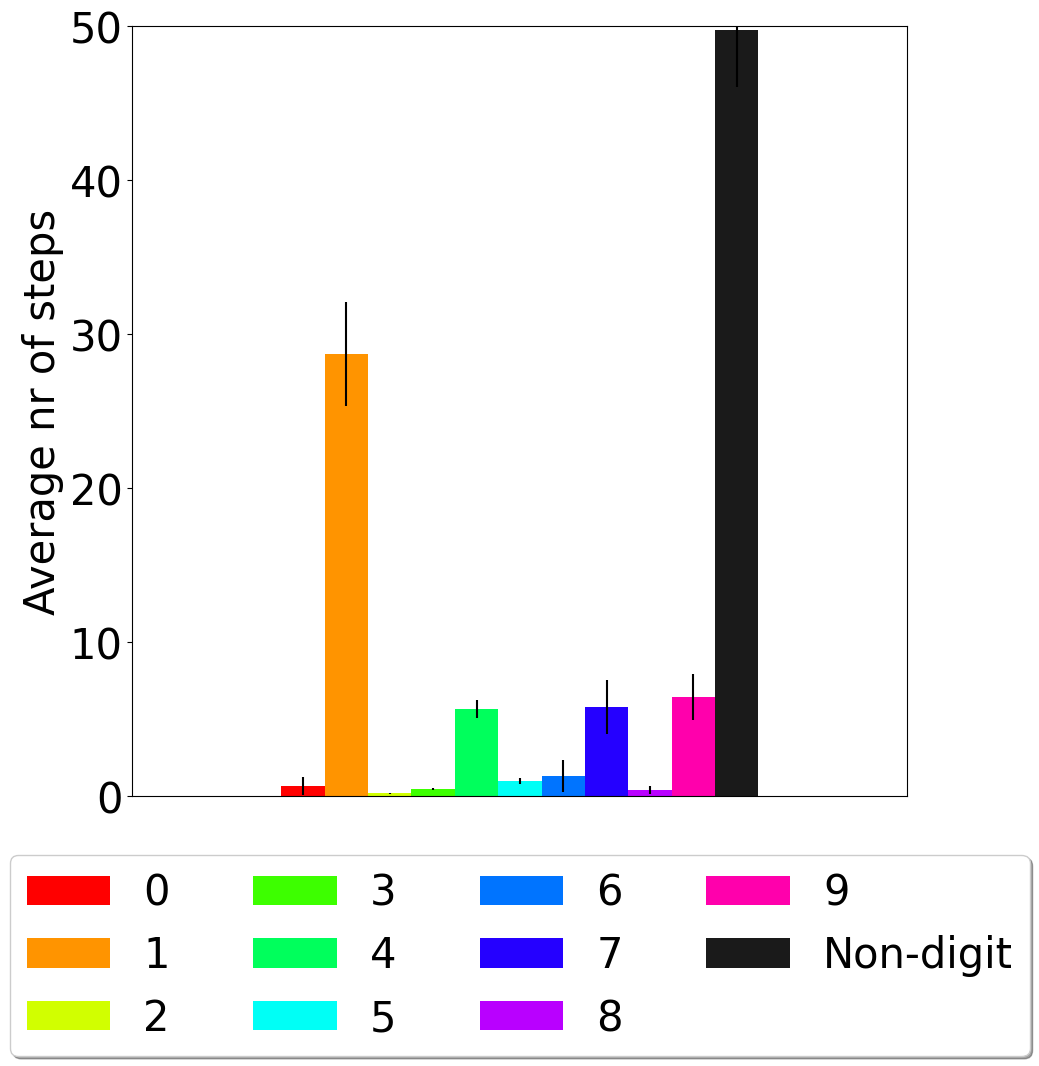

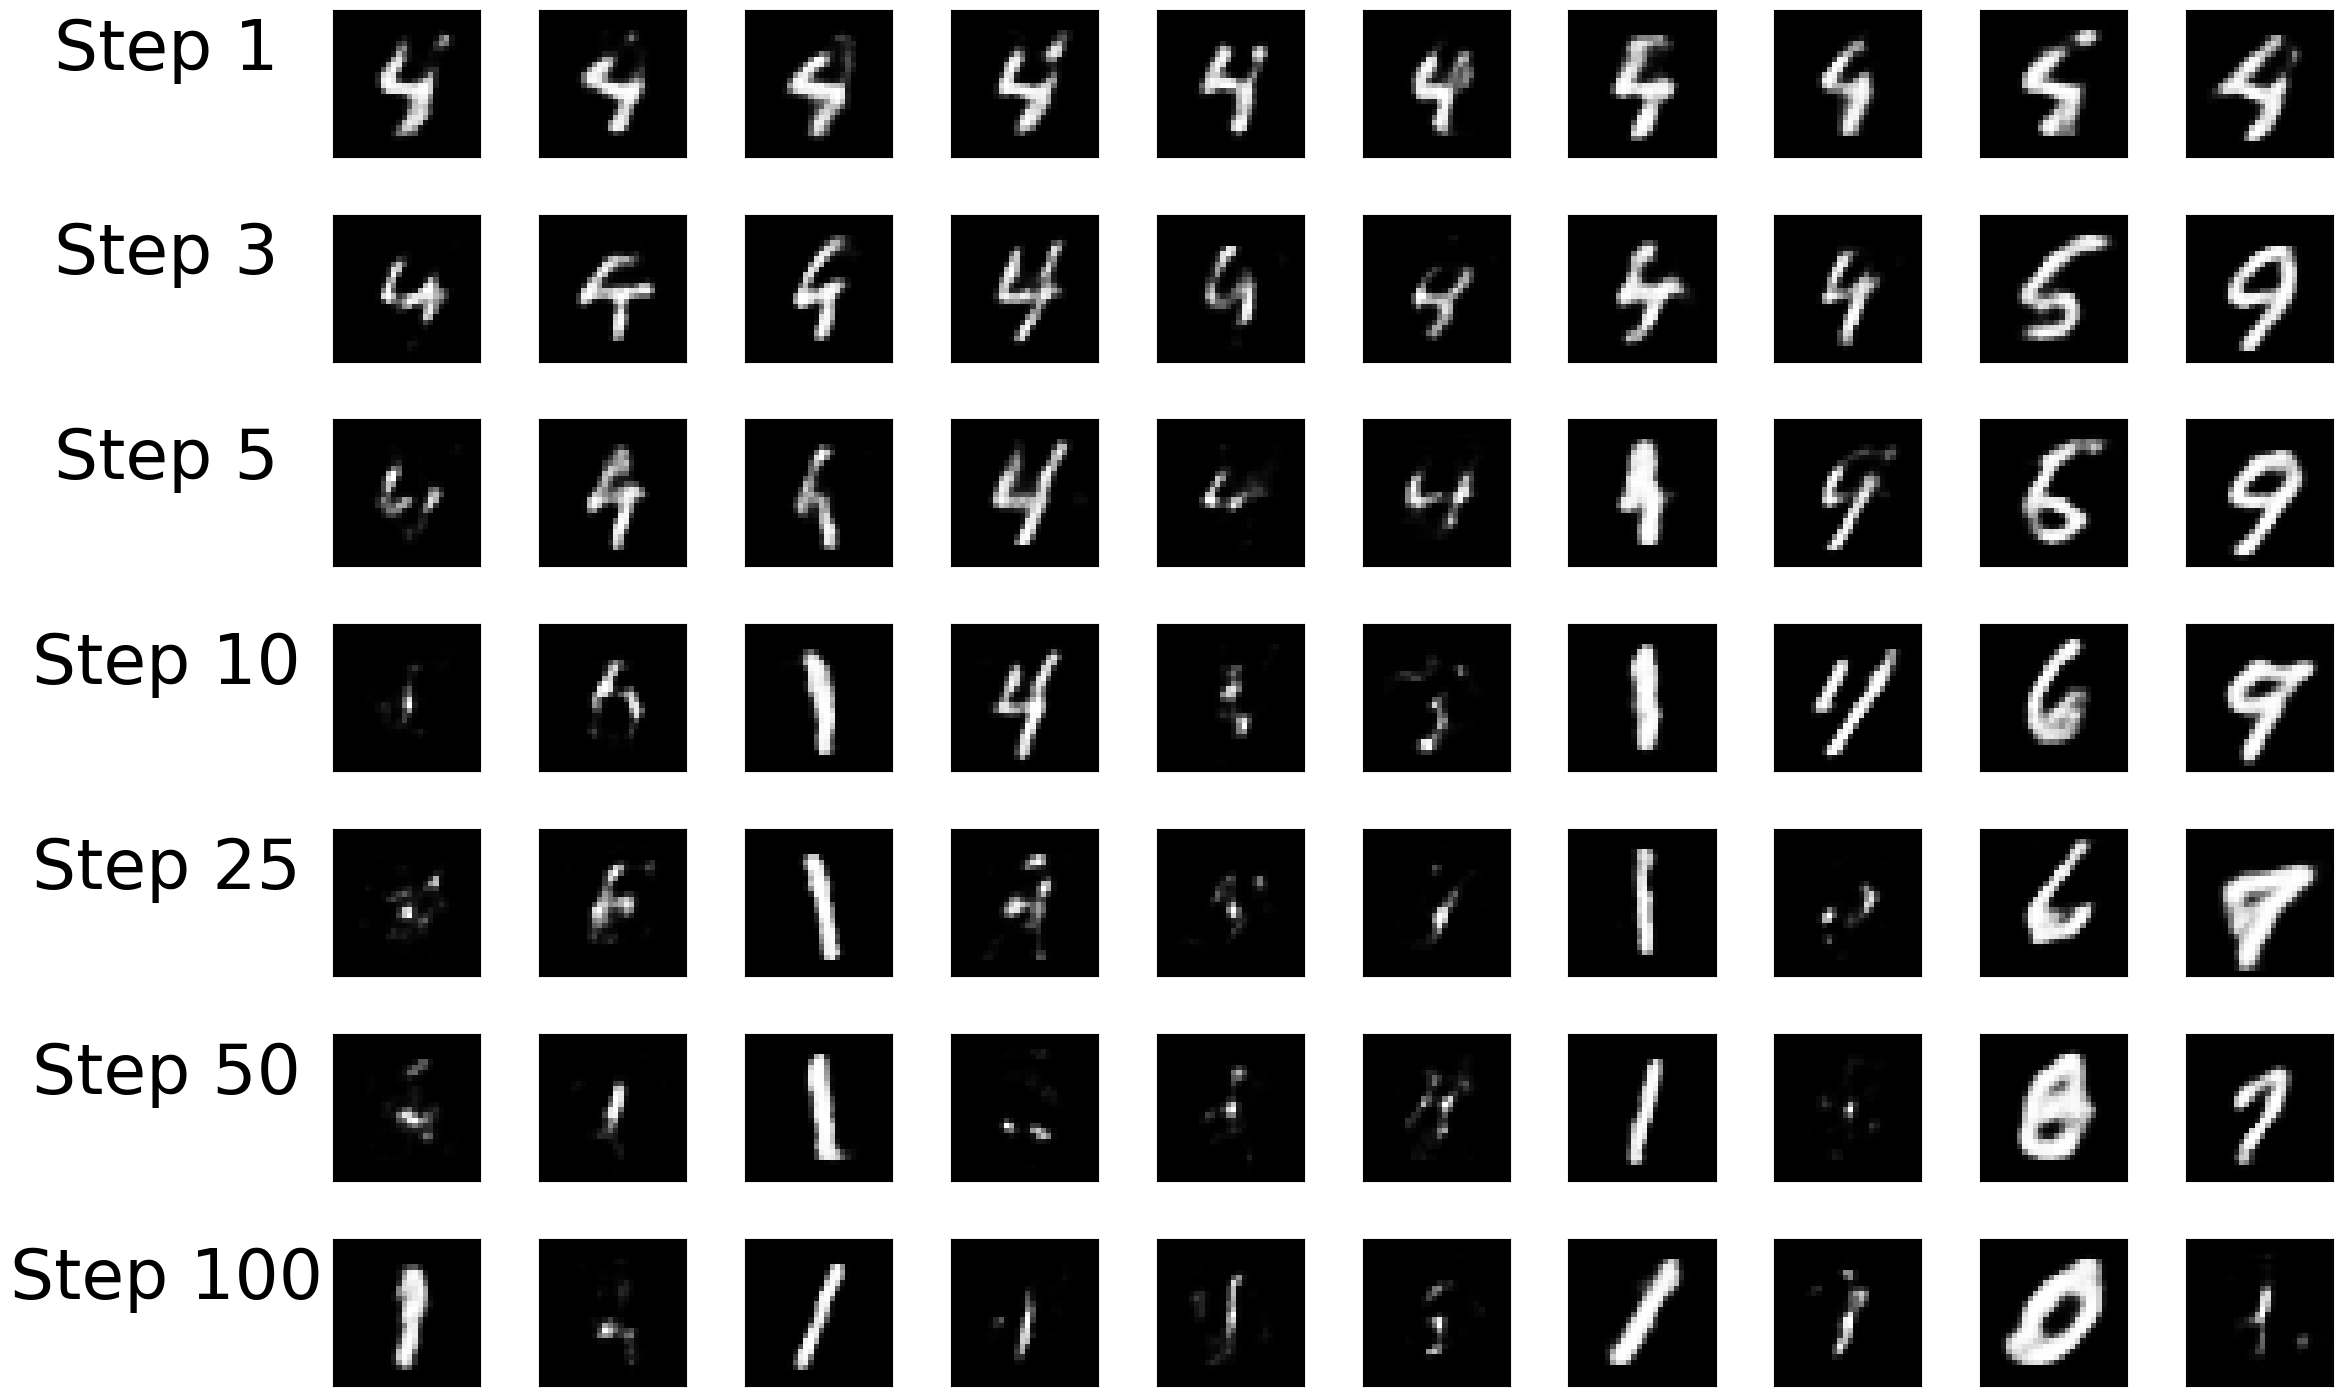

In [3]:
'''
Chimeras - Double label biasing method (2LB) characterization
OUTPUT PLOTS:
1) Average number of visited states for each combination of biasing digits (100 samples per generation)
2) Best chimera state - average p/m SEM number of visited states and average p/m SEM number of transitions
3) Best chimera state - average p/m SEM number of generation steps per class state
4) Best chimera state - 10 example generations
'''

#topk is computed as the average number of hidden units active between biasing classes in the first step of LB generation
topk=int((torch.mean(Mean, axis=0)[0]*dbn.top_layer_size)/100)
#here we get the average number of visited states for each biasing combination of classes (Vis_states_mat_2LB)
Vis_states_mat_2LB, Vis_states_err_2LB, _, _= Chimeras_nr_visited_states_ZAMBRA(dbn, classifier, Ian =[], topk=topk,nr_sample_generated =100)

# Create a Boolean mask of non-NaN values
mask = ~np.isnan(Vis_states_mat_2LB)
# Vectorize the array excluding NaN values
vectorized_arr = Vis_states_mat_2LB[mask]
#If you want to register new results, store them in the Results_dict
Results_dict[dbn.fname]['Nr_visited_states_C2lb']=vectorized_arr

#Now we want to see the generation profile of the chimera with highest value of nr of visited states in Vis_states_mat_2LB
max_index = np.nanargmax(Vis_states_mat_2LB)
# Find the row and column indices of the maximum value
max_row, max_col = np.unravel_index(max_index, Vis_states_mat_2LB.shape)

gen_hidden = label_biasing_ZAMBRA(dbn, on_digits= [max_row, max_col], topk = topk)
gen_hidden_100rep = gen_hidden.repeat(1,100)
d = generate_from_hidden_ZAMBRA(dbn, gen_hidden_100rep , nr_gen_steps=100)
d = Classifier_accuracy(d, classifier,dbn, labels=[], Batch_sz= 100,  plot=0, dS=30, l_sz=3)
df_average,df_sem, Transition_matrix_rowNorm = classification_metrics(d,dbn, Plot=1, Ian=1)
Plot_example_generated(d, num_classes = 10, dS= 50, lblpad=120)


tensor([[111.,  47.,  53.,  55.,  48.,  68.,  58.,  50.,  55.,  49.],
        [ 47., 111.,  68.,  69.,  62.,  69.,  63.,  66.,  72.,  64.],
        [ 53.,  68., 111.,  68.,  59.,  62.,  64.,  54.,  65.,  58.],
        [ 55.,  69.,  68., 111.,  57.,  83.,  58.,  63.,  71.,  61.],
        [ 48.,  62.,  59.,  57., 111.,  63.,  63.,  71.,  61.,  86.],
        [ 68.,  69.,  62.,  83.,  63., 111.,  65.,  67.,  76.,  68.],
        [ 58.,  63.,  64.,  58.,  63.,  65., 111.,  52.,  65.,  63.],
        [ 50.,  66.,  54.,  63.,  71.,  67.,  52., 111.,  64.,  84.],
        [ 55.,  72.,  65.,  71.,  61.,  76.,  65.,  64., 111.,  69.],
        [ 49.,  64.,  58.,  61.,  86.,  68.,  63.,  84.,  69., 111.]])


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

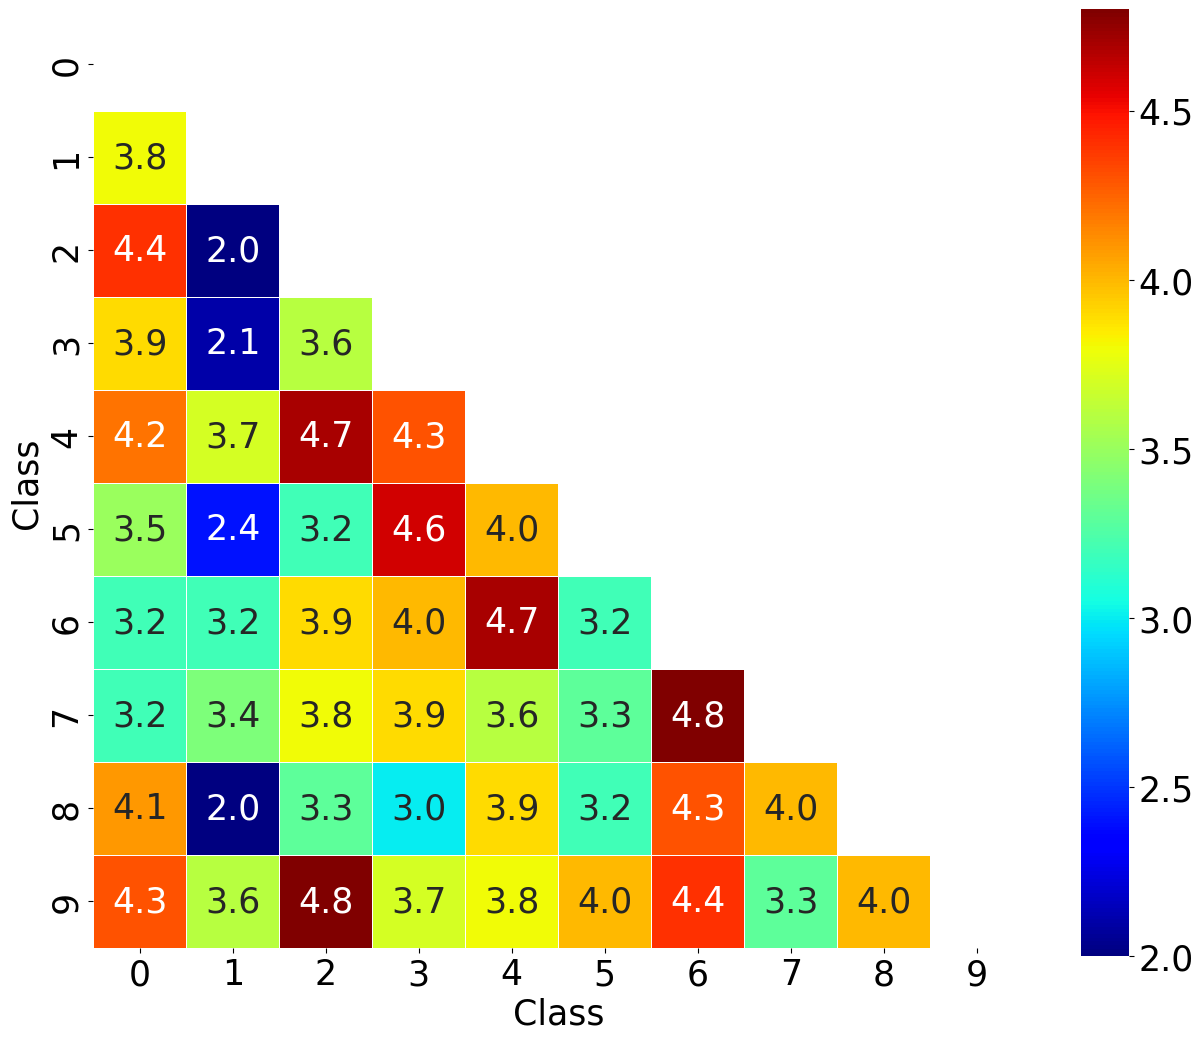

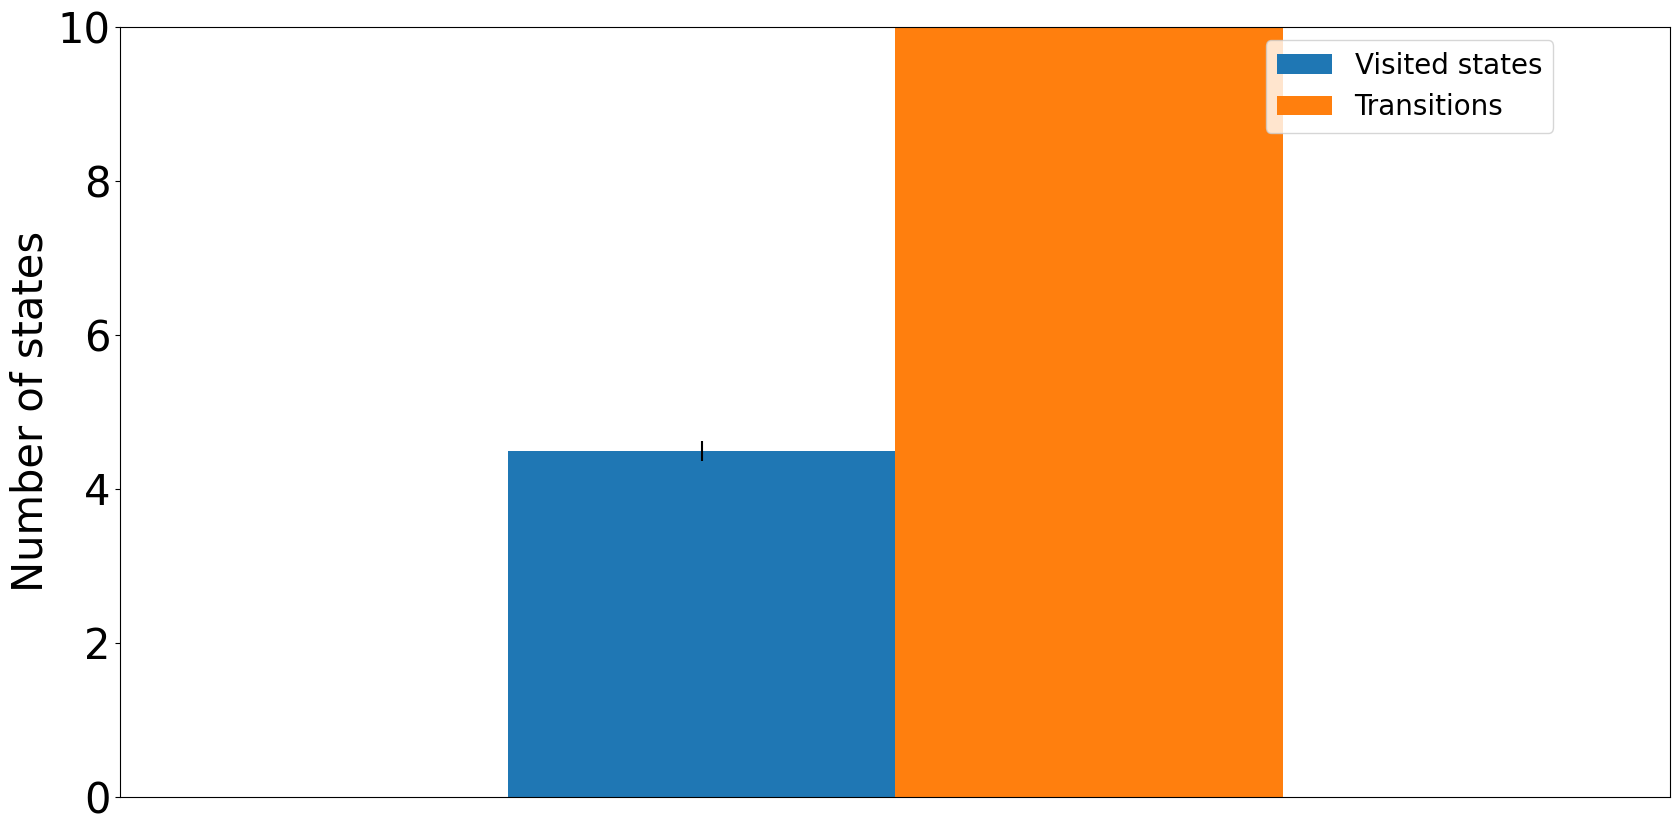

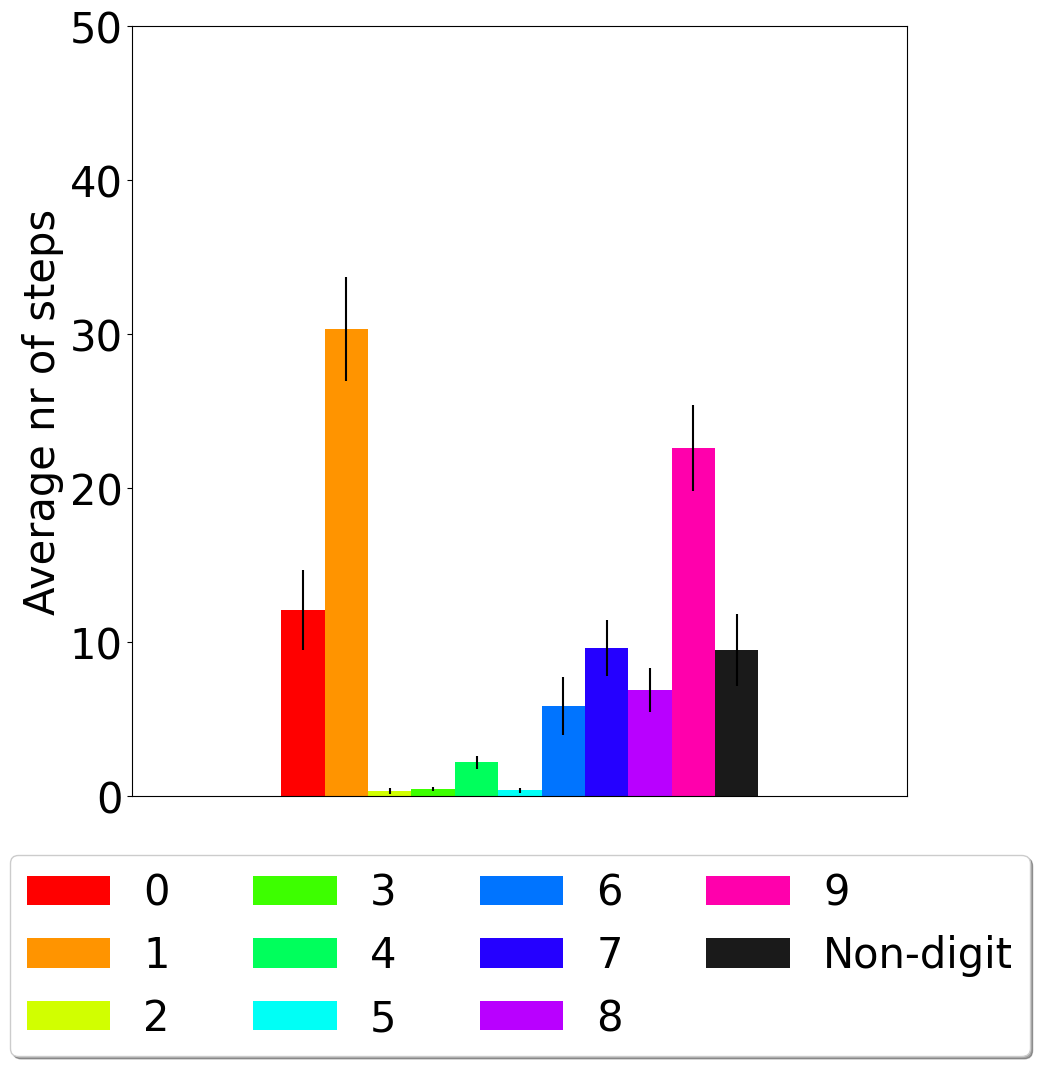

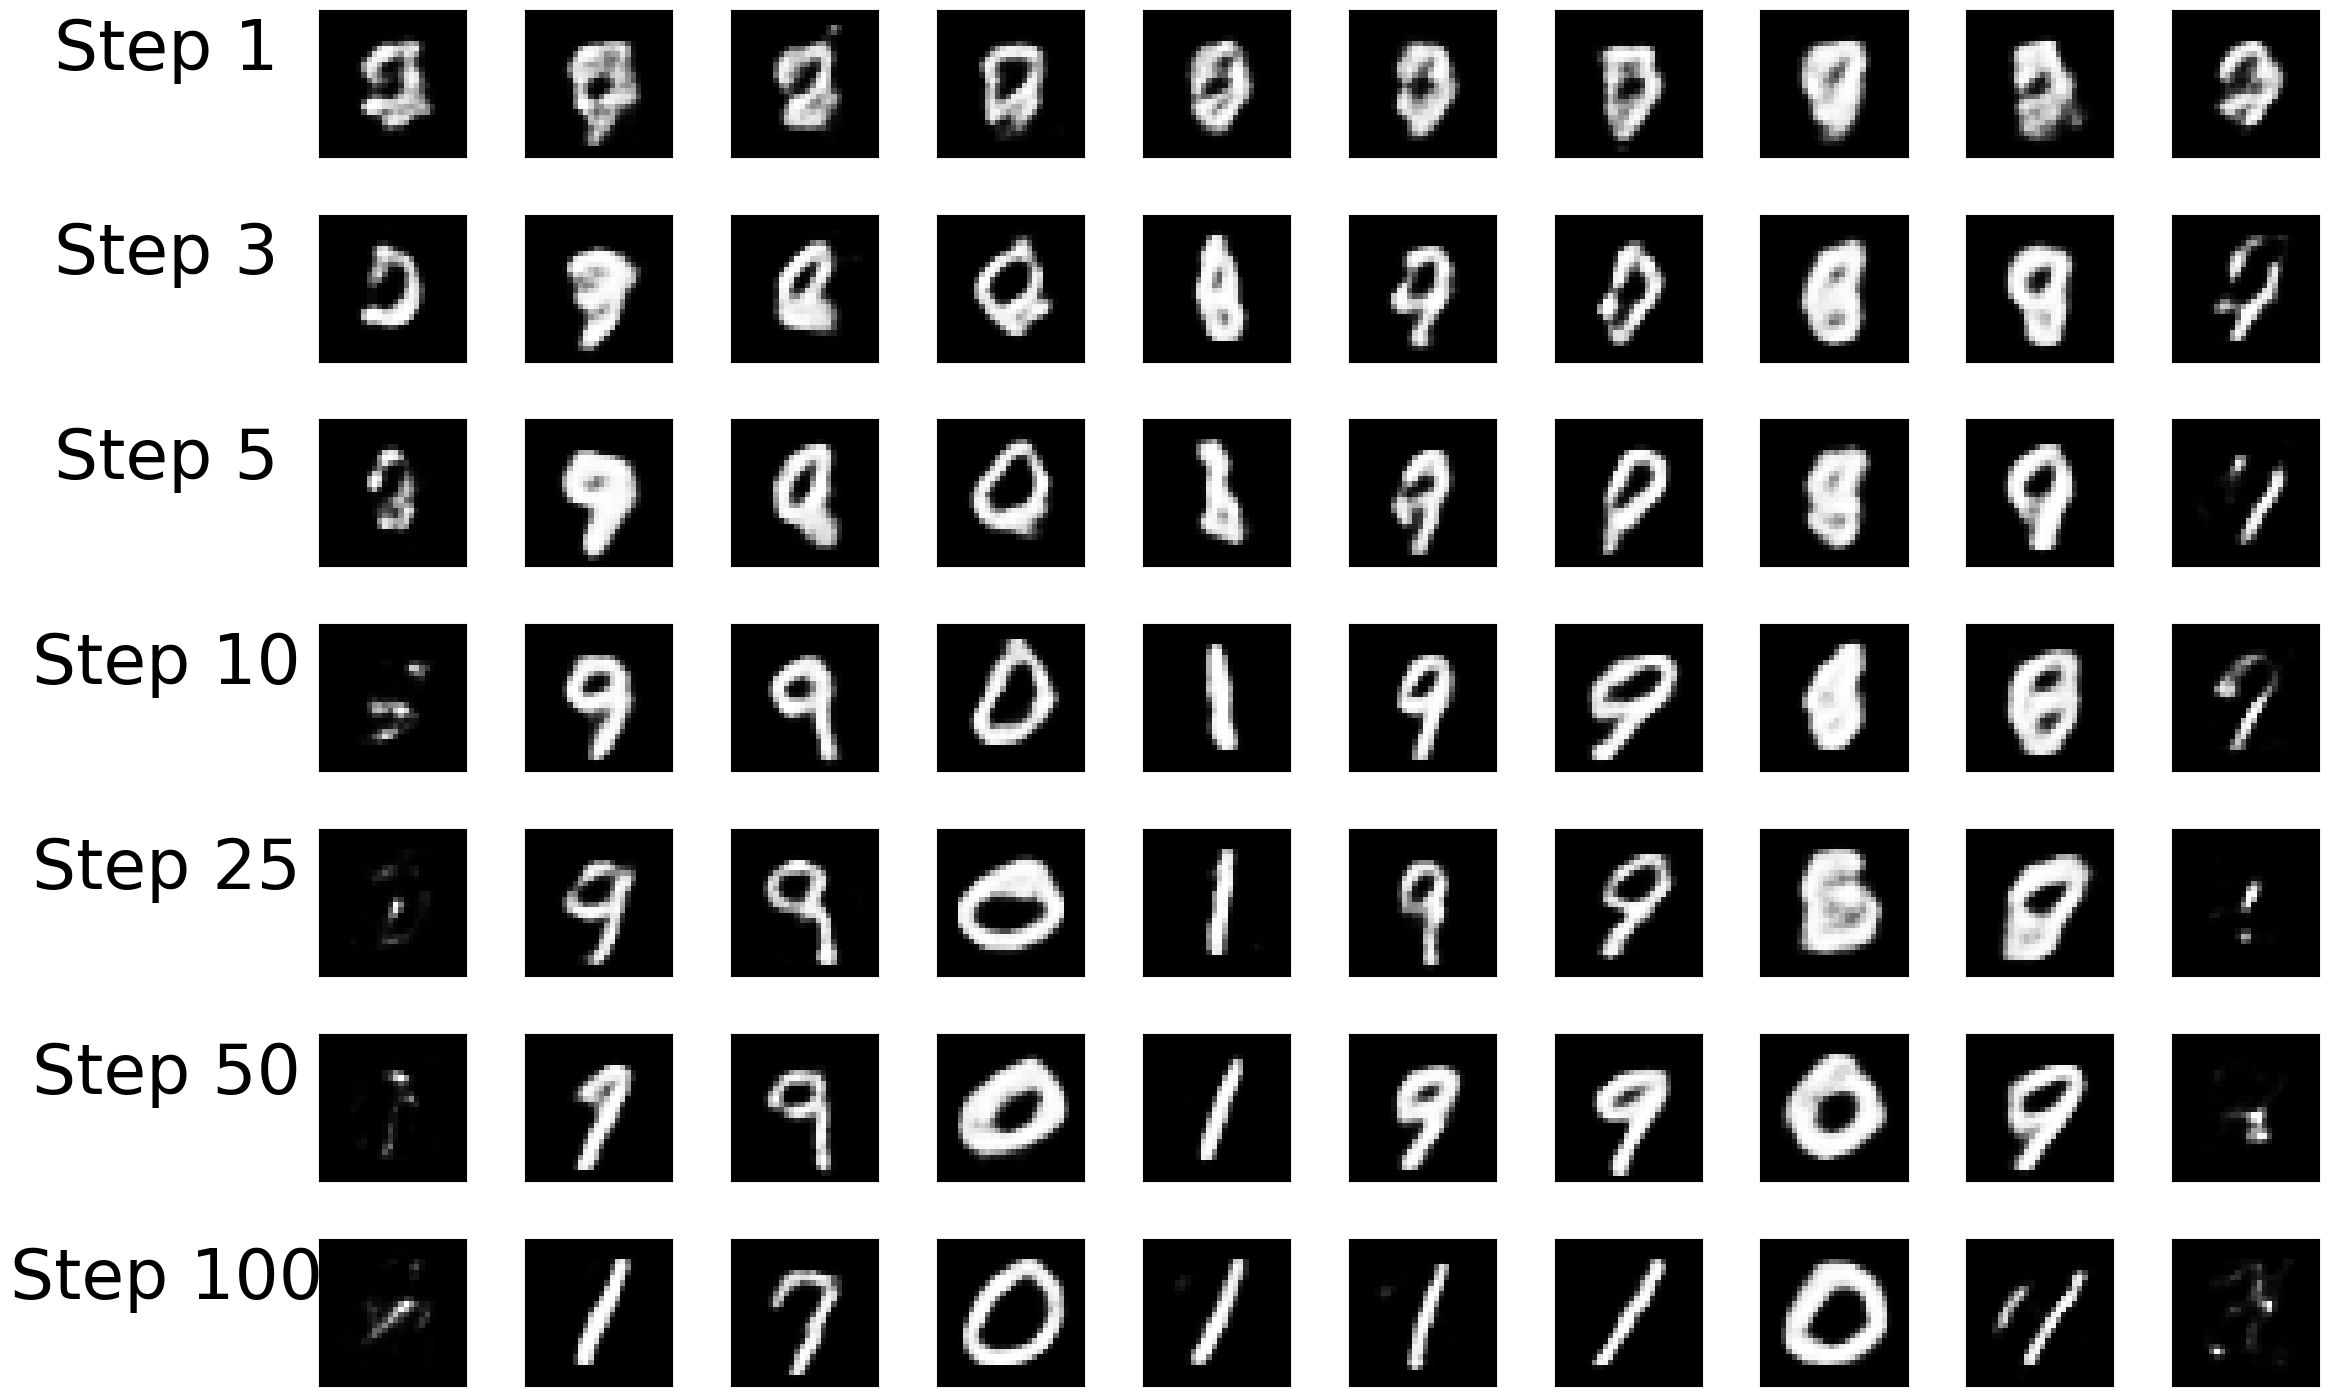

In [4]:
'''
Chimeras - Intersection method (Int) characterization
OUTPUT PLOTS:
1) Average number of visited states for each combination of biasing digits (100 samples per generation)
2) Best chimera state - average p/m SEM number of visited states and average p/m SEM number of transitions
3) Best chimera state - average p/m SEM number of generation steps per class state
4) Best chimera state - 10 example generations
'''

#topk is computed as the average number of hidden units active between biasing classes in the first step of LB generation
k = int((torch.mean(Mean, axis=0)[0]*dbn.top_layer_size)/100)
Ian = Intersection_analysis_ZAMBRA(dbn, top_k_Hidden=k)
digit_digit_common_elements_count_biasing = Ian.do_intersection_analysis()
df_digit_digit_common_elements_count_biasing = pd.DataFrame(digit_digit_common_elements_count_biasing.cpu().numpy()) #nr of common h units for each intersection of 2 classes
Vis_states_mat_IntNoCorr, Vis_states_err_IntNoCorr, ND_stateTime_mat_IntNoCorr, ND_stateTime_err_IntNoCorr = Chimeras_nr_visited_states_ZAMBRA(dbn, classifier, Ian =Ian, apprx=1,plot=1,compute_new=1, nr_sample_generated =100, entropy_correction=[], lS=25)

# Create a Boolean mask of non-NaN values
mask = ~np.isnan(Vis_states_mat_IntNoCorr)

# Vectorize the array excluding NaN values
vectorized_arr = Vis_states_mat_IntNoCorr[mask]

Results_dict[dbn.fname]['Nr_visited_states_Cint']=vectorized_arr

max_index = np.nanargmax(Vis_states_mat_IntNoCorr)
# Find the row and column indices of the maximum value
max_row, max_col = np.unravel_index(max_index, Vis_states_mat_IntNoCorr.shape)
d, df_average,df_sem, Transition_matrix_rowNorm = Ian.generate_chimera_lbl_biasing(classifier, elements_of_interest = [max_row, max_col],plot=1, nr_of_examples = 100, temperature = 1, entropy_correction=[])
Plot_example_generated(d)



Which keys do you want to select (indicate in [] as a list)?
0: dbn_iterative_normal_CelebA_BW_4classes_nEp100_nL3_lastL1000_bsz128
1: dbn_iterative_normal_CelebA_BW_4classes_nEp100_nL3_lastL1000_bsz64
2: dbn_iterative_normal_MNIST_10classes_nEp100_nL3_lastL1000_bsz64
3: dbn_iterative_normal_MNIST_10classes_nEp100_nL3_lastL1000_bsz128
4: dbn_iterative_normal_CelebA_BW_4classes_nEp100_nL3_lastL5250_bsz64
5: dbn_iterative_normal_CelebA_BW_4classes_nEp100_nL3_lastL5250_bsz128
6: dbn_iterative_normal_CelebA_BW_8classes_nEp100_nL3_lastL1000_bsz128
7: dbn_iterative_normal_CelebA_BW_8classes_nEp100_nL3_lastL5250_bsz128
8: RBM_MNIST
9: RBM_CelebA
[3,5,8,9]
[3.017      3.10888889 3.84444444]
[3.43       3.55       3.58333333]
[1.779      2.24       3.05111111]

[1.0 1.97 1.11 1.08]

[1.  1.  1.  2.2 2.1 1.6]

[1.3 1.  1.3 1.9 1.6 1.6]
[1.29       1.48333333 1.45      ]


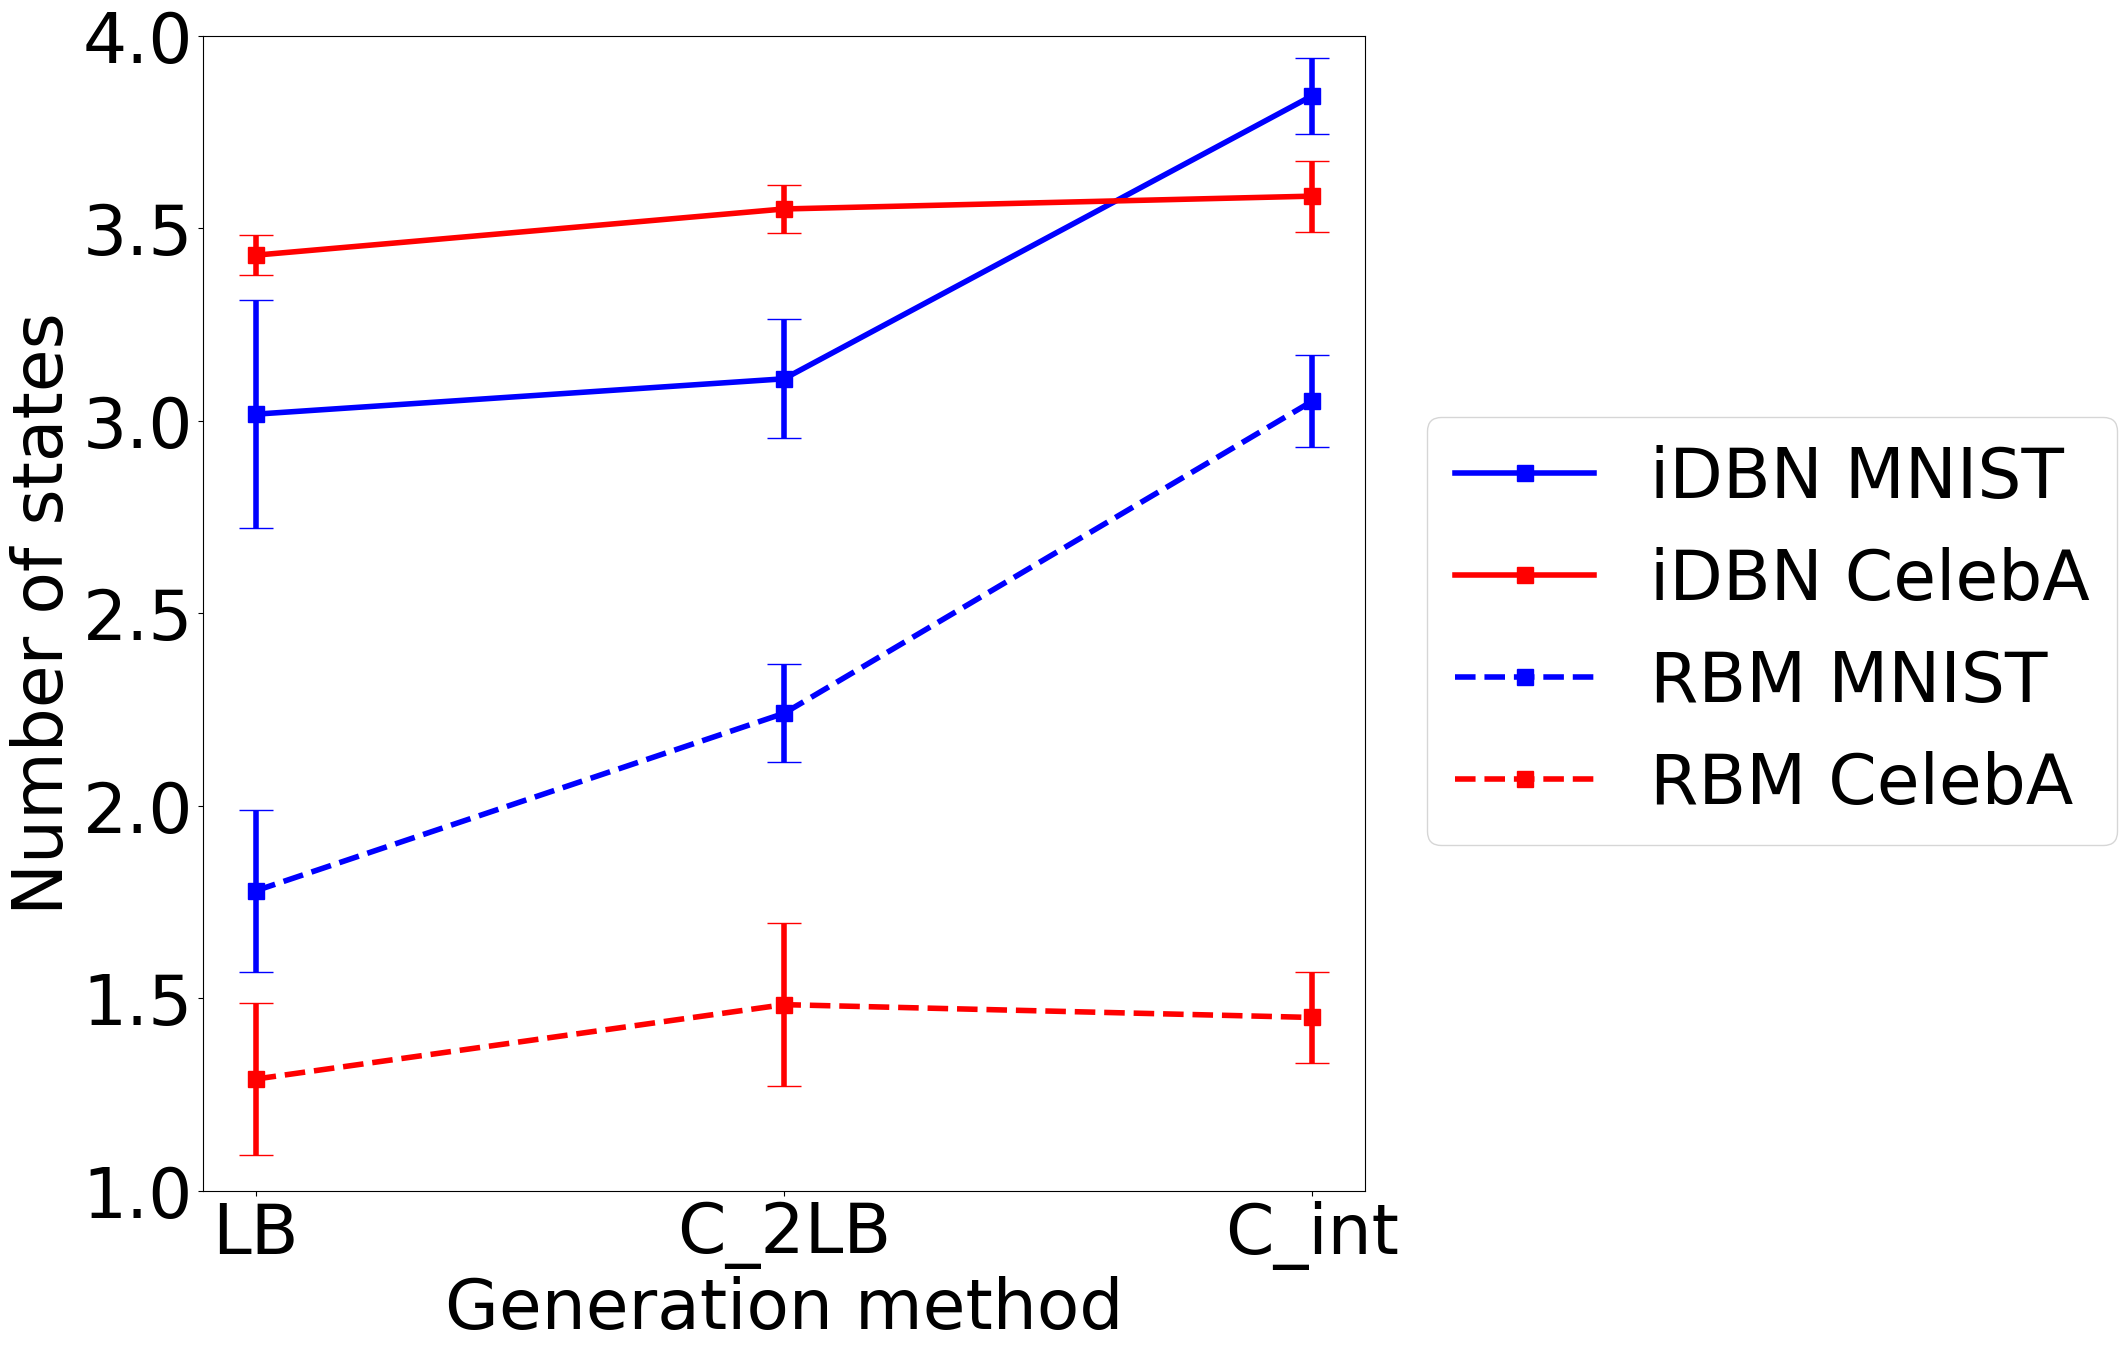

In [5]:
#comparison plot: number of visited states in different biasing paradigms
comparisons_plot(Results_dict)

100%|██████████| 561753746/561753746 [00:10<00:00, 53585850.40it/s]


Extracting ../data/EMNIST/raw/gzip.zip to ../data/EMNIST/raw


Train Batch 103	: 100%|██████████| 104/104 [00:00<00:00, 461.87Batch/s]


tensor([[111.,  47.,  53.,  55.,  48.,  68.,  58.,  50.,  55.,  49.],
        [ 47., 111.,  68.,  69.,  62.,  69.,  63.,  66.,  72.,  64.],
        [ 53.,  68., 111.,  68.,  59.,  62.,  64.,  54.,  65.,  58.],
        [ 55.,  69.,  68., 111.,  57.,  83.,  58.,  63.,  71.,  61.],
        [ 48.,  62.,  59.,  57., 111.,  63.,  63.,  71.,  61.,  86.],
        [ 68.,  69.,  62.,  83.,  63., 111.,  65.,  67.,  76.,  68.],
        [ 58.,  63.,  64.,  58.,  63.,  65., 111.,  52.,  65.,  63.],
        [ 50.,  66.,  54.,  63.,  71.,  67.,  52., 111.,  64.,  84.],
        [ 55.,  72.,  65.,  71.,  61.,  76.,  65.,  64., 111.,  69.],
        [ 49.,  64.,  58.,  61.,  86.,  68.,  63.,  84.,  69., 111.]])
{'data': tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 

Layer 2: 100%|██████████| 1/1 [00:00<00:00, 150.40Batch/s, MSE=0.00756]


Readout accuracy = 72.23


Layer 0: 100%|██████████| 1/1 [00:00<00:00, 224.13Batch/s]

0
eccomi


Readout accuracy = 79.82


Layer 1: 100%|██████████| 1/1 [00:00<00:00, 200.32Batch/s]


1
eccomi
Readout accuracy = 80.02


Layer 2: 100%|██████████| 1/1 [00:00<00:00, 202.16Batch/s]

2
eccomi


Readout accuracy = 79.83
Readout accuracy = 86.06


Layer 0: 100%|██████████| 468/468 [00:00<00:00, 539.45Batch/s]


0
eccomi
Readout accuracy = 95.94


Layer 1: 100%|██████████| 468/468 [00:01<00:00, 451.07Batch/s]


1
eccomi
Readout accuracy = 96.66


Layer 2: 100%|██████████| 468/468 [00:00<00:00, 703.39Batch/s]


2
eccomi
Readout accuracy = 96.83
[0.722314927184466, 0.7982402912621359, 0.8002123786407767, 0.798316140776699]
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
BATCH_SIZE 128
--Epoch 0


Layer 2: 100%|██████████| 78/78 [00:00<00:00, 243.59Batch/s, MSE=0.0059]


Readout accuracy = 84.78


Layer 0: 100%|██████████| 78/78 [00:00<00:00, 304.11Batch/s]


0
eccomi
Readout accuracy = 94.68


Layer 1: 100%|██████████| 78/78 [00:00<00:00, 421.61Batch/s]

1
eccomi


Readout accuracy = 94.58


Layer 2: 100%|██████████| 78/78 [00:00<00:00, 492.92Batch/s]

2
eccomi


Readout accuracy = 95.05
Readout accuracy = 86.06


Layer 0: 100%|██████████| 468/468 [00:00<00:00, 589.82Batch/s]


0
eccomi
Readout accuracy = 95.73


Layer 1: 100%|██████████| 468/468 [00:00<00:00, 743.22Batch/s]


1
eccomi
Readout accuracy = 96.32


Layer 2: 100%|██████████| 468/468 [00:00<00:00, 760.12Batch/s]


2
eccomi
Readout accuracy = 96.76
[0.8477700242718447, 0.9468294902912622, 0.9458434466019418, 0.9505461165048543]
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
BATCH_SIZE 128
--Epoch 0


Layer 2: 100%|██████████| 156/156 [00:00<00:00, 237.00Batch/s, MSE=0.00542]


Readout accuracy = 85.76


Layer 0: 100%|██████████| 156/156 [00:00<00:00, 585.75Batch/s]


0
eccomi
Readout accuracy = 95.02


Layer 1: 100%|██████████| 156/156 [00:00<00:00, 581.80Batch/s]


1
eccomi
Readout accuracy = 94.78


Layer 2: 100%|██████████| 156/156 [00:00<00:00, 583.18Batch/s]


2
eccomi
Readout accuracy = 95.47
Readout accuracy = 86.06


Layer 0: 100%|██████████| 468/468 [00:01<00:00, 450.65Batch/s]


0
eccomi
Readout accuracy = 95.45


Layer 1: 100%|██████████| 468/468 [00:00<00:00, 724.23Batch/s]


1
eccomi
Readout accuracy = 96.08


Layer 2: 100%|██████████| 468/468 [00:00<00:00, 696.63Batch/s]


2
eccomi
Readout accuracy = 96.68
[0.8576304611650486, 0.9502427184466019, 0.9478155339805825, 0.9547178398058253]
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
BATCH_SIZE 128


Train Batch 103	: 100%|██████████| 104/104 [00:00<00:00, 469.73Batch/s]


tensor([[111.,  47.,  53.,  55.,  48.,  68.,  58.,  50.,  55.,  49.],
        [ 47., 111.,  68.,  69.,  62.,  69.,  63.,  66.,  72.,  64.],
        [ 53.,  68., 111.,  68.,  59.,  62.,  64.,  54.,  65.,  58.],
        [ 55.,  69.,  68., 111.,  57.,  83.,  58.,  63.,  71.,  61.],
        [ 48.,  62.,  59.,  57., 111.,  63.,  63.,  71.,  61.,  86.],
        [ 68.,  69.,  62.,  83.,  63., 111.,  65.,  67.,  76.,  68.],
        [ 58.,  63.,  64.,  58.,  63.,  65., 111.,  52.,  65.,  63.],
        [ 50.,  66.,  54.,  63.,  71.,  67.,  52., 111.,  64.,  84.],
        [ 55.,  72.,  65.,  71.,  61.,  76.,  65.,  64., 111.,  69.],
        [ 49.,  64.,  58.,  61.,  86.,  68.,  63.,  84.,  69., 111.]])
{'data': tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 

Layer 0: 100%|██████████| 468/468 [00:00<00:00, 665.91Batch/s]


0
eccomi
Readout accuracy = 95.94


Layer 1: 100%|██████████| 468/468 [00:00<00:00, 705.91Batch/s]


1
eccomi
Readout accuracy = 96.66


Layer 2: 100%|██████████| 468/468 [00:00<00:00, 706.25Batch/s]


2
eccomi
Readout accuracy = 96.83
Readout accuracy = 85.76


Layer 0: 100%|██████████| 156/156 [00:00<00:00, 788.99Batch/s]


0
eccomi
Readout accuracy = 94.92


Layer 1: 100%|██████████| 156/156 [00:00<00:00, 409.31Batch/s]


1
eccomi
Readout accuracy = 94.70


Layer 2: 100%|██████████| 156/156 [00:00<00:00, 548.75Batch/s]


2
eccomi
Readout accuracy = 95.56
--Epoch 0


Layer 2: 100%|██████████| 156/156 [00:00<00:00, 218.38Batch/s, MSE=0.0101]


--Epoch 1


Layer 2: 100%|██████████| 156/156 [00:00<00:00, 245.55Batch/s, MSE=0.00907]


--Epoch 2


Layer 2: 100%|██████████| 156/156 [00:00<00:00, 240.53Batch/s, MSE=0.00869]


--Epoch 3


Layer 2: 100%|██████████| 156/156 [00:00<00:00, 231.11Batch/s, MSE=0.00845]


--Epoch 4


Layer 2: 100%|██████████| 156/156 [00:02<00:00, 58.73Batch/s, MSE=0.00825] 


Readout accuracy = 86.06


Layer 0: 100%|██████████| 468/468 [00:00<00:00, 730.95Batch/s]


0
eccomi
Readout accuracy = 91.32


Layer 1: 100%|██████████| 468/468 [00:01<00:00, 269.39Batch/s]


1
eccomi
Readout accuracy = 93.17


Layer 2: 100%|██████████| 468/468 [00:01<00:00, 396.83Batch/s]


2
eccomi
Readout accuracy = 95.86
Readout accuracy = 85.76


Layer 0: 100%|██████████| 156/156 [00:00<00:00, 610.84Batch/s]


0
eccomi
Readout accuracy = 95.31


Layer 1: 100%|██████████| 156/156 [00:00<00:00, 340.43Batch/s]


1
eccomi
Readout accuracy = 95.20


Layer 2: 100%|██████████| 156/156 [00:00<00:00, 340.20Batch/s]


2
eccomi
Readout accuracy = 95.88
--Epoch 0


Layer 2: 100%|██████████| 156/156 [00:00<00:00, 235.34Batch/s, MSE=0.00808]


--Epoch 1


Layer 2: 100%|██████████| 156/156 [00:00<00:00, 241.24Batch/s, MSE=0.00797]


--Epoch 2


Layer 2: 100%|██████████| 156/156 [00:00<00:00, 248.13Batch/s, MSE=0.00784]


--Epoch 3


Layer 2: 100%|██████████| 156/156 [00:00<00:00, 238.34Batch/s, MSE=0.00773]


--Epoch 4


Layer 2: 100%|██████████| 156/156 [00:00<00:00, 242.95Batch/s, MSE=0.00766]


Readout accuracy = 86.06


Layer 0: 100%|██████████| 468/468 [00:00<00:00, 736.31Batch/s]


0
eccomi
Readout accuracy = 84.44


Layer 1: 100%|██████████| 468/468 [00:00<00:00, 731.32Batch/s]


1
eccomi
Readout accuracy = 87.55


Layer 2: 100%|██████████| 468/468 [00:00<00:00, 720.36Batch/s]


2
eccomi
Readout accuracy = 95.10
Readout accuracy = 85.76


Layer 0: 100%|██████████| 156/156 [00:00<00:00, 656.71Batch/s]


0
eccomi
Readout accuracy = 95.38


Layer 1: 100%|██████████| 156/156 [00:01<00:00, 116.31Batch/s]


1
eccomi
Readout accuracy = 95.11


Layer 2: 100%|██████████| 156/156 [00:00<00:00, 419.46Batch/s]


2
eccomi
Readout accuracy = 95.90
--Epoch 0


Layer 2: 100%|██████████| 156/156 [00:00<00:00, 255.32Batch/s, MSE=0.00757]


--Epoch 1


Layer 2: 100%|██████████| 156/156 [00:00<00:00, 254.14Batch/s, MSE=0.0075]


--Epoch 2


Layer 2: 100%|██████████| 156/156 [00:00<00:00, 234.61Batch/s, MSE=0.0074]


--Epoch 3


Layer 2: 100%|██████████| 156/156 [00:00<00:00, 235.16Batch/s, MSE=0.00737]


--Epoch 4


Layer 2: 100%|██████████| 156/156 [00:01<00:00, 82.03Batch/s, MSE=0.00732]


Readout accuracy = 86.06


Layer 0: 100%|██████████| 468/468 [00:00<00:00, 730.59Batch/s]


0
eccomi
Readout accuracy = 79.83


Layer 1: 100%|██████████| 468/468 [00:00<00:00, 764.37Batch/s]


1
eccomi
Readout accuracy = 82.95


Layer 2: 100%|██████████| 468/468 [00:00<00:00, 773.28Batch/s]


2
eccomi
Readout accuracy = 94.04
Readout accuracy = 85.76


Layer 0: 100%|██████████| 156/156 [00:00<00:00, 587.71Batch/s]


0
eccomi
Readout accuracy = 95.41


Layer 1: 100%|██████████| 156/156 [00:00<00:00, 670.62Batch/s]


1
eccomi
Readout accuracy = 95.08


Layer 2: 100%|██████████| 156/156 [00:00<00:00, 674.68Batch/s]


2
eccomi
Readout accuracy = 95.96
--Epoch 0


Layer 2: 100%|██████████| 156/156 [00:00<00:00, 245.23Batch/s, MSE=0.00728]


--Epoch 1


Layer 2: 100%|██████████| 156/156 [00:00<00:00, 260.57Batch/s, MSE=0.00724]


--Epoch 2


Layer 2: 100%|██████████| 156/156 [00:01<00:00, 113.83Batch/s, MSE=0.0072]


--Epoch 3


Layer 2: 100%|██████████| 156/156 [00:00<00:00, 238.74Batch/s, MSE=0.00715]


--Epoch 4


Layer 2: 100%|██████████| 156/156 [00:00<00:00, 244.02Batch/s, MSE=0.00712]


Readout accuracy = 86.06


Layer 0: 100%|██████████| 468/468 [00:00<00:00, 742.41Batch/s]


0
eccomi
Readout accuracy = 76.42


Layer 1: 100%|██████████| 468/468 [00:00<00:00, 736.81Batch/s]


1
eccomi
Readout accuracy = 79.11


Layer 2: 100%|██████████| 468/468 [00:00<00:00, 744.46Batch/s]


2
eccomi
Readout accuracy = 93.19
Readout accuracy = 85.76


Layer 0: 100%|██████████| 156/156 [00:00<00:00, 697.75Batch/s]


0
eccomi
Readout accuracy = 95.50


Layer 1: 100%|██████████| 156/156 [00:00<00:00, 688.05Batch/s]


1
eccomi
Readout accuracy = 95.12


Layer 2: 100%|██████████| 156/156 [00:00<00:00, 558.38Batch/s]


2
eccomi
Readout accuracy = 95.91
--Epoch 0


Layer 2: 100%|██████████| 156/156 [00:01<00:00, 129.42Batch/s, MSE=0.00708]


--Epoch 1


Layer 2: 100%|██████████| 156/156 [00:00<00:00, 259.90Batch/s, MSE=0.00703]


--Epoch 2


Layer 2: 100%|██████████| 156/156 [00:00<00:00, 250.42Batch/s, MSE=0.00699]


--Epoch 3


Layer 2: 100%|██████████| 156/156 [00:00<00:00, 209.43Batch/s, MSE=0.00699]


--Epoch 4


Layer 2: 100%|██████████| 156/156 [00:00<00:00, 226.71Batch/s, MSE=0.00697]


Readout accuracy = 86.06


Layer 0: 100%|██████████| 468/468 [00:00<00:00, 556.96Batch/s]


0
eccomi
Readout accuracy = 74.99


Layer 1: 100%|██████████| 468/468 [00:00<00:00, 701.54Batch/s]


1
eccomi
Readout accuracy = 76.64


Layer 2: 100%|██████████| 468/468 [00:00<00:00, 610.50Batch/s]


2
eccomi
Readout accuracy = 92.11
Readout accuracy = 85.76


Layer 0: 100%|██████████| 156/156 [00:00<00:00, 692.51Batch/s]


0
eccomi
Readout accuracy = 95.56


Layer 1: 100%|██████████| 156/156 [00:00<00:00, 609.05Batch/s]


1
eccomi
Readout accuracy = 95.07


Layer 2: 100%|██████████| 156/156 [00:00<00:00, 613.13Batch/s]


2
eccomi
Readout accuracy = 96.02
--Epoch 0


Layer 2: 100%|██████████| 156/156 [00:00<00:00, 242.90Batch/s, MSE=0.00693]


--Epoch 1


Layer 2: 100%|██████████| 156/156 [00:00<00:00, 244.47Batch/s, MSE=0.0069]


--Epoch 2


Layer 2: 100%|██████████| 156/156 [00:00<00:00, 241.63Batch/s, MSE=0.00686]


--Epoch 3


Layer 2: 100%|██████████| 156/156 [00:00<00:00, 270.61Batch/s, MSE=0.00686]


--Epoch 4


Layer 2: 100%|██████████| 156/156 [00:00<00:00, 264.62Batch/s, MSE=0.00685]


Readout accuracy = 86.06


Layer 0: 100%|██████████| 468/468 [00:00<00:00, 732.24Batch/s]


0
eccomi
Readout accuracy = 73.97


Layer 1: 100%|██████████| 468/468 [00:00<00:00, 785.75Batch/s]


1
eccomi
Readout accuracy = 73.40


Layer 2: 100%|██████████| 468/468 [00:00<00:00, 744.21Batch/s]


2
eccomi
Readout accuracy = 90.56
Readout accuracy = 85.76


Layer 0: 100%|██████████| 156/156 [00:00<00:00, 598.13Batch/s]


0
eccomi
Readout accuracy = 95.56


Layer 1: 100%|██████████| 156/156 [00:00<00:00, 596.52Batch/s]


1
eccomi
Readout accuracy = 95.18


Layer 2: 100%|██████████| 156/156 [00:00<00:00, 635.64Batch/s]


2
eccomi
Readout accuracy = 96.06
--Epoch 0


Layer 2: 100%|██████████| 156/156 [00:00<00:00, 214.36Batch/s, MSE=0.00679]


--Epoch 1


Layer 2: 100%|██████████| 156/156 [00:00<00:00, 192.61Batch/s, MSE=0.00679]


--Epoch 2


Layer 2: 100%|██████████| 156/156 [00:00<00:00, 246.44Batch/s, MSE=0.00679]


--Epoch 3


Layer 2: 100%|██████████| 156/156 [00:00<00:00, 252.86Batch/s, MSE=0.00676]


--Epoch 4


Layer 2: 100%|██████████| 156/156 [00:00<00:00, 246.90Batch/s, MSE=0.00673]


Readout accuracy = 86.06


Layer 0: 100%|██████████| 468/468 [00:00<00:00, 657.71Batch/s]


0
eccomi
Readout accuracy = 72.84


Layer 1: 100%|██████████| 468/468 [00:00<00:00, 727.24Batch/s]


1
eccomi
Readout accuracy = 71.49


Layer 2: 100%|██████████| 468/468 [00:00<00:00, 762.19Batch/s]


2
eccomi
Readout accuracy = 88.85
Readout accuracy = 85.76


Layer 0: 100%|██████████| 156/156 [00:00<00:00, 355.78Batch/s]


0
eccomi
Readout accuracy = 95.58


Layer 1: 100%|██████████| 156/156 [00:00<00:00, 654.99Batch/s]


1
eccomi
Readout accuracy = 95.12


Layer 2: 100%|██████████| 156/156 [00:00<00:00, 667.49Batch/s]


2
eccomi
Readout accuracy = 96.09
--Epoch 0


Layer 2: 100%|██████████| 156/156 [00:00<00:00, 239.37Batch/s, MSE=0.00671]


--Epoch 1


Layer 2: 100%|██████████| 156/156 [00:00<00:00, 219.21Batch/s, MSE=0.00669]


--Epoch 2


Layer 2: 100%|██████████| 156/156 [00:01<00:00, 144.88Batch/s, MSE=0.00668]


--Epoch 3


Layer 2: 100%|██████████| 156/156 [00:00<00:00, 243.25Batch/s, MSE=0.00669]


--Epoch 4


Layer 2: 100%|██████████| 156/156 [00:00<00:00, 253.68Batch/s, MSE=0.00665]


Readout accuracy = 86.06


Layer 0: 100%|██████████| 468/468 [00:00<00:00, 660.96Batch/s]


0
eccomi
Readout accuracy = 71.61


Layer 1: 100%|██████████| 468/468 [00:01<00:00, 467.49Batch/s]


1
eccomi
Readout accuracy = 69.85


Layer 2: 100%|██████████| 468/468 [00:00<00:00, 742.88Batch/s]


2
eccomi
Readout accuracy = 86.63
Readout accuracy = 85.76


Layer 0: 100%|██████████| 156/156 [00:00<00:00, 655.11Batch/s]


0
eccomi
Readout accuracy = 95.60


Layer 1: 100%|██████████| 156/156 [00:00<00:00, 685.03Batch/s]


1
eccomi
Readout accuracy = 95.07


Layer 2: 100%|██████████| 156/156 [00:00<00:00, 720.50Batch/s]

2
eccomi


Readout accuracy = 96.07
--Epoch 0


Layer 2: 100%|██████████| 156/156 [00:00<00:00, 267.91Batch/s, MSE=0.00666]


--Epoch 1


Layer 2: 100%|██████████| 156/156 [00:00<00:00, 255.24Batch/s, MSE=0.00663]


--Epoch 2


Layer 2: 100%|██████████| 156/156 [00:00<00:00, 258.49Batch/s, MSE=0.00662]


--Epoch 3


Layer 2: 100%|██████████| 156/156 [00:00<00:00, 273.69Batch/s, MSE=0.0066]


--Epoch 4


Layer 2: 100%|██████████| 156/156 [00:00<00:00, 240.68Batch/s, MSE=0.00657]


Readout accuracy = 86.06


Layer 0: 100%|██████████| 468/468 [00:00<00:00, 621.77Batch/s]


0
eccomi
Readout accuracy = 70.66


Layer 1: 100%|██████████| 468/468 [00:00<00:00, 517.55Batch/s]


1
eccomi
Readout accuracy = 68.59


Layer 2: 100%|██████████| 468/468 [00:00<00:00, 751.86Batch/s]


2
eccomi
Readout accuracy = 84.93
Readout accuracy = 85.76


Layer 0: 100%|██████████| 156/156 [00:00<00:00, 643.43Batch/s]


0
eccomi
Readout accuracy = 95.63


Layer 1: 100%|██████████| 156/156 [00:00<00:00, 718.91Batch/s]


1
eccomi
Readout accuracy = 95.14


Layer 2: 100%|██████████| 156/156 [00:00<00:00, 776.74Batch/s]


2
eccomi
Readout accuracy = 96.07
--Epoch 0


Layer 2: 100%|██████████| 156/156 [00:00<00:00, 238.74Batch/s, MSE=0.00656]


--Epoch 1


Layer 2: 100%|██████████| 156/156 [00:00<00:00, 203.40Batch/s, MSE=0.00656]


--Epoch 2


Layer 2: 100%|██████████| 156/156 [00:00<00:00, 249.31Batch/s, MSE=0.00656]


--Epoch 3


Layer 2: 100%|██████████| 156/156 [00:00<00:00, 248.87Batch/s, MSE=0.00654]


--Epoch 4


Layer 2: 100%|██████████| 156/156 [00:00<00:00, 254.94Batch/s, MSE=0.00654]


Readout accuracy = 86.06


Layer 0: 100%|██████████| 468/468 [00:01<00:00, 368.74Batch/s]


0
eccomi
Readout accuracy = 69.55


Layer 1: 100%|██████████| 468/468 [00:00<00:00, 773.65Batch/s]


1
eccomi
Readout accuracy = 67.23


Layer 2: 100%|██████████| 468/468 [00:00<00:00, 775.88Batch/s]


2
eccomi
Readout accuracy = 82.51
Readout accuracy = 85.76


Layer 0: 100%|██████████| 156/156 [00:00<00:00, 574.91Batch/s]


0
eccomi
Readout accuracy = 95.63


Layer 1: 100%|██████████| 156/156 [00:00<00:00, 649.12Batch/s]


1
eccomi
Readout accuracy = 95.17


Layer 2: 100%|██████████| 156/156 [00:00<00:00, 669.76Batch/s]


2
eccomi
Readout accuracy = 96.08


Train Batch 103	: 100%|██████████| 104/104 [00:00<00:00, 392.04Batch/s]


{'data': tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0.,

Layer 2: 100%|██████████| 1/1 [00:00<00:00, 104.00Batch/s, MSE=0.00155]


Readout accuracy = 72.23


Layer 0: 100%|██████████| 1/1 [00:00<00:00, 410.20Batch/s]


0
eccomi
Readout accuracy = 79.84


Layer 1: 100%|██████████| 1/1 [00:00<00:00, 192.16Batch/s]


1
eccomi
Readout accuracy = 79.99


Layer 2: 100%|██████████| 1/1 [00:00<00:00, 462.34Batch/s]

2
eccomi


Readout accuracy = 79.81
Readout accuracy = 86.06


Layer 0: 100%|██████████| 468/468 [00:00<00:00, 689.72Batch/s]


0
eccomi
Readout accuracy = 95.94


Layer 1: 100%|██████████| 468/468 [00:01<00:00, 318.05Batch/s]


1
eccomi
Readout accuracy = 96.64


Layer 2: 100%|██████████| 468/468 [00:01<00:00, 399.00Batch/s]


2
eccomi
Readout accuracy = 96.80
[0.722314927184466, 0.7983919902912622, 0.7999089805825242, 0.7980885922330098]
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
BATCH_SIZE 128
--Epoch 0


Layer 2: 100%|██████████| 78/78 [00:00<00:00, 174.54Batch/s, MSE=0.00624]


Readout accuracy = 84.78


Layer 0: 100%|██████████| 78/78 [00:00<00:00, 407.29Batch/s]


0
eccomi
Readout accuracy = 94.69


Layer 1: 100%|██████████| 78/78 [00:00<00:00, 491.01Batch/s]

1
eccomi


Readout accuracy = 94.55


Layer 2: 100%|██████████| 78/78 [00:00<00:00, 296.32Batch/s]


2
eccomi
Readout accuracy = 95.05
Readout accuracy = 86.06


Layer 0: 100%|██████████| 468/468 [00:01<00:00, 428.48Batch/s]


0
eccomi
Readout accuracy = 95.75


Layer 1: 100%|██████████| 468/468 [00:00<00:00, 697.41Batch/s]


1
eccomi
Readout accuracy = 96.28


Layer 2: 100%|██████████| 468/468 [00:00<00:00, 673.60Batch/s]


2
eccomi
Readout accuracy = 96.80
[0.8477700242718447, 0.9469053398058253, 0.9455400485436893, 0.9504702669902912]
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
BATCH_SIZE 128
--Epoch 0


Layer 2: 100%|██████████| 156/156 [00:00<00:00, 179.68Batch/s, MSE=0.00639]


Readout accuracy = 85.76


Layer 0: 100%|██████████| 156/156 [00:00<00:00, 331.67Batch/s]


0
eccomi
Readout accuracy = 94.98


Layer 1: 100%|██████████| 156/156 [00:00<00:00, 351.90Batch/s]


1
eccomi
Readout accuracy = 94.74


Layer 2: 100%|██████████| 156/156 [00:00<00:00, 529.14Batch/s]


2
eccomi
Readout accuracy = 95.57
Readout accuracy = 86.06


Layer 0: 100%|██████████| 468/468 [00:00<00:00, 687.34Batch/s]


0
eccomi
Readout accuracy = 95.54


Layer 1: 100%|██████████| 468/468 [00:00<00:00, 736.45Batch/s]


1
eccomi
Readout accuracy = 96.10


Layer 2: 100%|██████████| 468/468 [00:01<00:00, 395.20Batch/s]


2
eccomi
Readout accuracy = 96.78
[0.8576304611650486, 0.9497876213592233, 0.9473604368932039, 0.9557038834951457]
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
BATCH_SIZE 128


Train Batch 103	: 100%|██████████| 104/104 [00:00<00:00, 468.47Batch/s]


{'data': tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0.,

Layer 0: 100%|██████████| 468/468 [00:00<00:00, 664.26Batch/s]


0
eccomi
Readout accuracy = 95.94


Layer 1: 100%|██████████| 468/468 [00:00<00:00, 688.23Batch/s]


1
eccomi
Readout accuracy = 96.66


Layer 2: 100%|██████████| 468/468 [00:00<00:00, 701.67Batch/s]


2
eccomi
Readout accuracy = 96.83
Readout accuracy = 85.76


Layer 0: 100%|██████████| 156/156 [00:00<00:00, 628.22Batch/s]


0
eccomi
Readout accuracy = 94.92


Layer 1: 100%|██████████| 156/156 [00:00<00:00, 469.42Batch/s]


1
eccomi
Readout accuracy = 94.70


Layer 2: 100%|██████████| 156/156 [00:00<00:00, 504.02Batch/s]


2
eccomi
Readout accuracy = 95.56
--Epoch 0


Layer 2: 100%|██████████| 156/156 [00:00<00:00, 191.88Batch/s, MSE=0.00638]


--Epoch 1


Layer 2: 100%|██████████| 156/156 [00:00<00:00, 194.27Batch/s, MSE=0.00603]


--Epoch 2


Layer 2: 100%|██████████| 156/156 [00:00<00:00, 229.35Batch/s, MSE=0.00592]


--Epoch 3


Layer 2: 100%|██████████| 156/156 [00:00<00:00, 191.16Batch/s, MSE=0.00584]


--Epoch 4


Layer 2: 100%|██████████| 156/156 [00:00<00:00, 202.42Batch/s, MSE=0.00579]


Readout accuracy = 86.06


Layer 0: 100%|██████████| 468/468 [00:01<00:00, 390.93Batch/s]


0
eccomi
Readout accuracy = 94.80


Layer 1: 100%|██████████| 468/468 [00:01<00:00, 412.88Batch/s]


1
eccomi
Readout accuracy = 95.56


Layer 2: 100%|██████████| 468/468 [00:01<00:00, 429.50Batch/s]


2
eccomi
Readout accuracy = 96.49
Readout accuracy = 85.76


Layer 0: 100%|██████████| 156/156 [00:00<00:00, 512.41Batch/s]


0
eccomi
Readout accuracy = 95.12


Layer 1: 100%|██████████| 156/156 [00:00<00:00, 364.59Batch/s]


1
eccomi
Readout accuracy = 94.88


Layer 2: 100%|██████████| 156/156 [00:00<00:00, 500.04Batch/s]


2
eccomi
Readout accuracy = 95.59
--Epoch 0


Layer 2: 100%|██████████| 156/156 [00:00<00:00, 251.05Batch/s, MSE=0.00573]


--Epoch 1


Layer 2: 100%|██████████| 156/156 [00:00<00:00, 261.39Batch/s, MSE=0.00567]


--Epoch 2


Layer 2: 100%|██████████| 156/156 [00:00<00:00, 262.39Batch/s, MSE=0.00564]


--Epoch 3


Layer 2: 100%|██████████| 156/156 [00:00<00:00, 268.87Batch/s, MSE=0.00559]


--Epoch 4


Layer 2: 100%|██████████| 156/156 [00:00<00:00, 267.98Batch/s, MSE=0.00555]


Readout accuracy = 86.06


Layer 0: 100%|██████████| 468/468 [00:00<00:00, 742.50Batch/s]


0
eccomi
Readout accuracy = 94.83


Layer 1: 100%|██████████| 468/468 [00:00<00:00, 762.73Batch/s]


1
eccomi
Readout accuracy = 95.39


Layer 2: 100%|██████████| 468/468 [00:00<00:00, 739.49Batch/s]


2
eccomi
Readout accuracy = 96.27
Readout accuracy = 85.76


Layer 0: 100%|██████████| 156/156 [00:00<00:00, 646.08Batch/s]


0
eccomi
Readout accuracy = 95.21


Layer 1: 100%|██████████| 156/156 [00:00<00:00, 627.04Batch/s]


1
eccomi
Readout accuracy = 95.15


Layer 2: 100%|██████████| 156/156 [00:00<00:00, 607.94Batch/s]


2
eccomi
Readout accuracy = 95.68
--Epoch 0


Layer 2: 100%|██████████| 156/156 [00:01<00:00, 135.01Batch/s, MSE=0.00554]


--Epoch 1


Layer 2: 100%|██████████| 156/156 [00:00<00:00, 187.34Batch/s, MSE=0.00551]


--Epoch 2


Layer 2: 100%|██████████| 156/156 [00:00<00:00, 222.18Batch/s, MSE=0.00549]


--Epoch 3


Layer 2: 100%|██████████| 156/156 [00:00<00:00, 191.83Batch/s, MSE=0.00545]


--Epoch 4


Layer 2: 100%|██████████| 156/156 [00:00<00:00, 257.33Batch/s, MSE=0.00544]


Readout accuracy = 86.06


Layer 0: 100%|██████████| 468/468 [00:00<00:00, 673.96Batch/s]


0
eccomi
Readout accuracy = 94.74


Layer 1: 100%|██████████| 468/468 [00:00<00:00, 514.24Batch/s]


1
eccomi
Readout accuracy = 95.37


Layer 2: 100%|██████████| 468/468 [00:00<00:00, 690.31Batch/s]


2
eccomi
Readout accuracy = 96.11
Readout accuracy = 85.76


Layer 0: 100%|██████████| 156/156 [00:00<00:00, 705.50Batch/s]


0
eccomi
Readout accuracy = 95.25


Layer 1: 100%|██████████| 156/156 [00:00<00:00, 234.44Batch/s]


1
eccomi
Readout accuracy = 95.26


Layer 2: 100%|██████████| 156/156 [00:00<00:00, 401.20Batch/s]


2
eccomi
Readout accuracy = 95.70
--Epoch 0


Layer 2: 100%|██████████| 156/156 [00:00<00:00, 215.84Batch/s, MSE=0.00541]


--Epoch 1


Layer 2: 100%|██████████| 156/156 [00:00<00:00, 185.23Batch/s, MSE=0.00538]


--Epoch 2


Layer 2: 100%|██████████| 156/156 [00:00<00:00, 174.49Batch/s, MSE=0.00538]


--Epoch 3


Layer 2: 100%|██████████| 156/156 [00:00<00:00, 214.77Batch/s, MSE=0.00534]


--Epoch 4


Layer 2: 100%|██████████| 156/156 [00:00<00:00, 188.54Batch/s, MSE=0.00533]


Readout accuracy = 86.06


Layer 0: 100%|██████████| 468/468 [00:00<00:00, 689.95Batch/s]


0
eccomi
Readout accuracy = 94.75


Layer 1: 100%|██████████| 468/468 [00:01<00:00, 330.08Batch/s]


1
eccomi
Readout accuracy = 95.35


Layer 2: 100%|██████████| 468/468 [00:00<00:00, 712.30Batch/s]


2
eccomi
Readout accuracy = 95.96
Readout accuracy = 85.76


Layer 0: 100%|██████████| 156/156 [00:00<00:00, 560.82Batch/s]


0
eccomi
Readout accuracy = 95.30


Layer 1: 100%|██████████| 156/156 [00:00<00:00, 546.18Batch/s]


1
eccomi
Readout accuracy = 95.34


Layer 2: 100%|██████████| 156/156 [00:00<00:00, 610.34Batch/s]


2
eccomi
Readout accuracy = 95.70
--Epoch 0


Layer 2: 100%|██████████| 156/156 [00:00<00:00, 187.39Batch/s, MSE=0.00532]


--Epoch 1


Layer 2: 100%|██████████| 156/156 [00:00<00:00, 227.95Batch/s, MSE=0.0053]


--Epoch 2


Layer 2: 100%|██████████| 156/156 [00:00<00:00, 227.26Batch/s, MSE=0.0053]


--Epoch 3


Layer 2: 100%|██████████| 156/156 [00:00<00:00, 242.21Batch/s, MSE=0.00528]


--Epoch 4


Layer 2: 100%|██████████| 156/156 [00:00<00:00, 256.74Batch/s, MSE=0.00525]


Readout accuracy = 86.06


Layer 0: 100%|██████████| 468/468 [00:00<00:00, 786.95Batch/s]


0
eccomi
Readout accuracy = 94.68


Layer 1: 100%|██████████| 468/468 [00:00<00:00, 558.91Batch/s]


1
eccomi
Readout accuracy = 95.45


Layer 2: 100%|██████████| 468/468 [00:00<00:00, 758.61Batch/s]


2
eccomi
Readout accuracy = 95.92
Readout accuracy = 85.76


Layer 0: 100%|██████████| 156/156 [00:00<00:00, 683.84Batch/s]


0
eccomi
Readout accuracy = 95.30


Layer 1: 100%|██████████| 156/156 [00:00<00:00, 643.28Batch/s]


1
eccomi
Readout accuracy = 95.34


Layer 2: 100%|██████████| 156/156 [00:00<00:00, 732.11Batch/s]


2
eccomi
Readout accuracy = 95.77
--Epoch 0


Layer 2: 100%|██████████| 156/156 [00:00<00:00, 242.49Batch/s, MSE=0.00524]


--Epoch 1


Layer 2: 100%|██████████| 156/156 [00:00<00:00, 268.13Batch/s, MSE=0.00524]


--Epoch 2


Layer 2: 100%|██████████| 156/156 [00:02<00:00, 77.86Batch/s, MSE=0.00522] 


--Epoch 3


Layer 2: 100%|██████████| 156/156 [00:00<00:00, 228.42Batch/s, MSE=0.00519]


--Epoch 4


Layer 2: 100%|██████████| 156/156 [00:00<00:00, 167.51Batch/s, MSE=0.00521]


Readout accuracy = 86.06


Layer 0: 100%|██████████| 468/468 [00:01<00:00, 424.94Batch/s]


0
eccomi
Readout accuracy = 94.53


Layer 1: 100%|██████████| 468/468 [00:00<00:00, 518.95Batch/s]


1
eccomi
Readout accuracy = 95.51


Layer 2: 100%|██████████| 468/468 [00:00<00:00, 701.86Batch/s]


2
eccomi
Readout accuracy = 95.76
Readout accuracy = 85.76


Layer 0: 100%|██████████| 156/156 [00:00<00:00, 713.97Batch/s]


0
eccomi
Readout accuracy = 95.37


Layer 1: 100%|██████████| 156/156 [00:00<00:00, 490.70Batch/s]


1
eccomi
Readout accuracy = 95.39


Layer 2: 100%|██████████| 156/156 [00:00<00:00, 439.37Batch/s]


2
eccomi
Readout accuracy = 95.78
--Epoch 0


Layer 2: 100%|██████████| 156/156 [00:00<00:00, 186.61Batch/s, MSE=0.00519]


--Epoch 1


Layer 2: 100%|██████████| 156/156 [00:00<00:00, 190.57Batch/s, MSE=0.00517]


--Epoch 2


Layer 2: 100%|██████████| 156/156 [00:00<00:00, 187.53Batch/s, MSE=0.00517]


--Epoch 3


Layer 2: 100%|██████████| 156/156 [00:00<00:00, 187.45Batch/s, MSE=0.00517]


--Epoch 4


Layer 2: 100%|██████████| 156/156 [00:00<00:00, 268.62Batch/s, MSE=0.00513]


Readout accuracy = 86.06


Layer 0: 100%|██████████| 468/468 [00:00<00:00, 721.96Batch/s]


0
eccomi
Readout accuracy = 94.48


Layer 1: 100%|██████████| 468/468 [00:00<00:00, 722.46Batch/s]


1
eccomi
Readout accuracy = 95.59


Layer 2: 100%|██████████| 468/468 [00:00<00:00, 728.88Batch/s]


2
eccomi
Readout accuracy = 95.71
Readout accuracy = 85.76


Layer 0: 100%|██████████| 156/156 [00:00<00:00, 181.00Batch/s]


0
eccomi
Readout accuracy = 95.40


Layer 1: 100%|██████████| 156/156 [00:00<00:00, 609.91Batch/s]


1
eccomi
Readout accuracy = 95.40


Layer 2: 100%|██████████| 156/156 [00:00<00:00, 575.27Batch/s]


2
eccomi
Readout accuracy = 95.80
--Epoch 0


Layer 2: 100%|██████████| 156/156 [00:00<00:00, 261.68Batch/s, MSE=0.00513]


--Epoch 1


Layer 2: 100%|██████████| 156/156 [00:00<00:00, 248.04Batch/s, MSE=0.00512]


--Epoch 2


Layer 2: 100%|██████████| 156/156 [00:00<00:00, 192.61Batch/s, MSE=0.00512]


--Epoch 3


Layer 2: 100%|██████████| 156/156 [00:01<00:00, 149.27Batch/s, MSE=0.00512]


--Epoch 4


Layer 2: 100%|██████████| 156/156 [00:00<00:00, 262.69Batch/s, MSE=0.0051]


Readout accuracy = 86.06


Layer 0: 100%|██████████| 468/468 [00:01<00:00, 314.11Batch/s]


0
eccomi
Readout accuracy = 94.44


Layer 1: 100%|██████████| 468/468 [00:01<00:00, 397.38Batch/s]


1
eccomi
Readout accuracy = 95.61


Layer 2: 100%|██████████| 468/468 [00:01<00:00, 429.46Batch/s]


2
eccomi
Readout accuracy = 95.60
Readout accuracy = 85.76


Layer 0: 100%|██████████| 156/156 [00:00<00:00, 359.84Batch/s]


0
eccomi
Readout accuracy = 95.35


Layer 1: 100%|██████████| 156/156 [00:00<00:00, 458.22Batch/s]


1
eccomi
Readout accuracy = 95.38


Layer 2: 100%|██████████| 156/156 [00:00<00:00, 391.68Batch/s]


2
eccomi
Readout accuracy = 95.88
--Epoch 0


Layer 2: 100%|██████████| 156/156 [00:00<00:00, 253.23Batch/s, MSE=0.00508]


--Epoch 1


Layer 2: 100%|██████████| 156/156 [00:00<00:00, 239.46Batch/s, MSE=0.0051]


--Epoch 2


Layer 2: 100%|██████████| 156/156 [00:00<00:00, 251.17Batch/s, MSE=0.00507]


--Epoch 3


Layer 2: 100%|██████████| 156/156 [00:00<00:00, 199.75Batch/s, MSE=0.00508]


--Epoch 4


Layer 2: 100%|██████████| 156/156 [00:00<00:00, 265.84Batch/s, MSE=0.00507]


Readout accuracy = 86.06


Layer 0: 100%|██████████| 468/468 [00:00<00:00, 771.04Batch/s]


0
eccomi
Readout accuracy = 94.22


Layer 1: 100%|██████████| 468/468 [00:00<00:00, 791.11Batch/s]


1
eccomi
Readout accuracy = 95.69


Layer 2: 100%|██████████| 468/468 [00:00<00:00, 742.08Batch/s]


2
eccomi
Readout accuracy = 95.42
Readout accuracy = 85.76


Layer 0: 100%|██████████| 156/156 [00:00<00:00, 599.76Batch/s]


0
eccomi
Readout accuracy = 95.43


Layer 1: 100%|██████████| 156/156 [00:00<00:00, 625.28Batch/s]


1
eccomi
Readout accuracy = 95.46


Layer 2: 100%|██████████| 156/156 [00:00<00:00, 679.59Batch/s]


2
eccomi
Readout accuracy = 95.93
--Epoch 0


Layer 2: 100%|██████████| 156/156 [00:00<00:00, 199.36Batch/s, MSE=0.00507]


--Epoch 1


Layer 2: 100%|██████████| 156/156 [00:00<00:00, 233.86Batch/s, MSE=0.00507]


--Epoch 2


Layer 2: 100%|██████████| 156/156 [00:00<00:00, 218.74Batch/s, MSE=0.00503]


--Epoch 3


Layer 2: 100%|██████████| 156/156 [00:00<00:00, 250.02Batch/s, MSE=0.00503]


--Epoch 4


Layer 2: 100%|██████████| 156/156 [00:00<00:00, 259.57Batch/s, MSE=0.00504]


Readout accuracy = 86.06


Layer 0: 100%|██████████| 468/468 [00:00<00:00, 766.92Batch/s]


0
eccomi
Readout accuracy = 94.23


Layer 1: 100%|██████████| 468/468 [00:00<00:00, 798.44Batch/s]


1
eccomi
Readout accuracy = 95.65


Layer 2: 100%|██████████| 468/468 [00:00<00:00, 796.31Batch/s]


2
eccomi
Readout accuracy = 95.42
Readout accuracy = 85.76


Layer 0: 100%|██████████| 156/156 [00:02<00:00, 52.55Batch/s] 


0
eccomi
Readout accuracy = 95.40


Layer 1: 100%|██████████| 156/156 [00:00<00:00, 632.64Batch/s]


1
eccomi
Readout accuracy = 95.46


Layer 2: 100%|██████████| 156/156 [00:00<00:00, 357.11Batch/s]


2
eccomi
Readout accuracy = 95.99


Train Batch 103	: 100%|██████████| 104/104 [00:00<00:00, 494.48Batch/s]


tensor([[111.,  47.,  53.,  55.,  48.,  68.,  58.,  50.,  55.,  49.],
        [ 47., 111.,  68.,  69.,  62.,  69.,  63.,  66.,  72.,  64.],
        [ 53.,  68., 111.,  68.,  59.,  62.,  64.,  54.,  65.,  58.],
        [ 55.,  69.,  68., 111.,  57.,  83.,  58.,  63.,  71.,  61.],
        [ 48.,  62.,  59.,  57., 111.,  63.,  63.,  71.,  61.,  86.],
        [ 68.,  69.,  62.,  83.,  63., 111.,  65.,  67.,  76.,  68.],
        [ 58.,  63.,  64.,  58.,  63.,  65., 111.,  52.,  65.,  63.],
        [ 50.,  66.,  54.,  63.,  71.,  67.,  52., 111.,  64.,  84.],
        [ 55.,  72.,  65.,  71.,  61.,  76.,  65.,  64., 111.,  69.],
        [ 49.,  64.,  58.,  61.,  86.,  68.,  63.,  84.,  69., 111.]])
{'data': tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 

Layer 2: 100%|██████████| 1/1 [00:00<00:00, 144.29Batch/s, MSE=0.00744]


Readout accuracy = 72.23


Layer 0: 100%|██████████| 1/1 [00:00<00:00, 321.67Batch/s]


0
eccomi
Readout accuracy = 79.84


Layer 1: 100%|██████████| 1/1 [00:00<00:00, 285.68Batch/s]


1
eccomi
Readout accuracy = 79.98


Layer 2: 100%|██████████| 1/1 [00:00<00:00, 312.12Batch/s]

2
eccomi


Readout accuracy = 79.81
Readout accuracy = 86.06


Layer 0: 100%|██████████| 468/468 [00:00<00:00, 697.70Batch/s]


0
eccomi
Readout accuracy = 95.95


Layer 1: 100%|██████████| 468/468 [00:01<00:00, 413.71Batch/s]


1
eccomi
Readout accuracy = 96.66


Layer 2: 100%|██████████| 468/468 [00:00<00:00, 692.78Batch/s]


2
eccomi
Readout accuracy = 96.82
[0.722314927184466, 0.7983919902912622, 0.7998331310679612, 0.7980885922330098]
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
BATCH_SIZE 128
--Epoch 0


Layer 2: 100%|██████████| 78/78 [00:00<00:00, 261.83Batch/s, MSE=0.00565]


Readout accuracy = 84.78


Layer 0: 100%|██████████| 78/78 [00:00<00:00, 489.83Batch/s]

0
eccomi


Readout accuracy = 94.74


Layer 1: 100%|██████████| 78/78 [00:00<00:00, 499.94Batch/s]

1
eccomi


Readout accuracy = 94.55


Layer 2: 100%|██████████| 78/78 [00:00<00:00, 291.74Batch/s]


2
eccomi
Readout accuracy = 94.99
Readout accuracy = 86.06


Layer 0: 100%|██████████| 468/468 [00:00<00:00, 732.43Batch/s]


0
eccomi
Readout accuracy = 95.73


Layer 1: 100%|██████████| 468/468 [00:00<00:00, 698.45Batch/s]


1
eccomi
Readout accuracy = 96.16


Layer 2: 100%|██████████| 468/468 [00:00<00:00, 781.42Batch/s]


2
eccomi
Readout accuracy = 96.77
[0.8477700242718447, 0.9473604368932039, 0.9455400485436893, 0.9499393203883495]
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
BATCH_SIZE 128
--Epoch 0


Layer 2: 100%|██████████| 156/156 [00:01<00:00, 125.11Batch/s, MSE=0.00543]


Readout accuracy = 85.76


Layer 0: 100%|██████████| 156/156 [00:00<00:00, 373.84Batch/s]


0
eccomi
Readout accuracy = 95.02


Layer 1: 100%|██████████| 156/156 [00:00<00:00, 486.34Batch/s]


1
eccomi
Readout accuracy = 94.75


Layer 2: 100%|██████████| 156/156 [00:00<00:00, 536.59Batch/s]


2
eccomi
Readout accuracy = 95.49
Readout accuracy = 86.06


Layer 0: 100%|██████████| 468/468 [00:00<00:00, 681.28Batch/s]


0
eccomi
Readout accuracy = 95.41


Layer 1: 100%|██████████| 468/468 [00:01<00:00, 303.98Batch/s]


1
eccomi
Readout accuracy = 96.04


Layer 2: 100%|██████████| 468/468 [00:00<00:00, 499.12Batch/s]


2
eccomi
Readout accuracy = 96.65
[0.8576304611650486, 0.9501668689320388, 0.9475121359223301, 0.9549453883495146]
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
BATCH_SIZE 128


Train Batch 103	: 100%|██████████| 104/104 [00:00<00:00, 496.92Batch/s]


tensor([[111.,  47.,  53.,  55.,  48.,  68.,  58.,  50.,  55.,  49.],
        [ 47., 111.,  68.,  69.,  62.,  69.,  63.,  66.,  72.,  64.],
        [ 53.,  68., 111.,  68.,  59.,  62.,  64.,  54.,  65.,  58.],
        [ 55.,  69.,  68., 111.,  57.,  83.,  58.,  63.,  71.,  61.],
        [ 48.,  62.,  59.,  57., 111.,  63.,  63.,  71.,  61.,  86.],
        [ 68.,  69.,  62.,  83.,  63., 111.,  65.,  67.,  76.,  68.],
        [ 58.,  63.,  64.,  58.,  63.,  65., 111.,  52.,  65.,  63.],
        [ 50.,  66.,  54.,  63.,  71.,  67.,  52., 111.,  64.,  84.],
        [ 55.,  72.,  65.,  71.,  61.,  76.,  65.,  64., 111.,  69.],
        [ 49.,  64.,  58.,  61.,  86.,  68.,  63.,  84.,  69., 111.]])
{'data': tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 

Layer 0: 100%|██████████| 468/468 [00:00<00:00, 665.29Batch/s]


0
eccomi
Readout accuracy = 95.94


Layer 1: 100%|██████████| 468/468 [00:00<00:00, 746.85Batch/s]


1
eccomi
Readout accuracy = 96.66


Layer 2: 100%|██████████| 468/468 [00:00<00:00, 682.88Batch/s]


2
eccomi
Readout accuracy = 96.83
Readout accuracy = 85.76


Layer 0: 100%|██████████| 156/156 [00:00<00:00, 674.64Batch/s]


0
eccomi
Readout accuracy = 94.92


Layer 1: 100%|██████████| 156/156 [00:00<00:00, 231.35Batch/s]


1
eccomi
Readout accuracy = 94.70


Layer 2: 100%|██████████| 156/156 [00:00<00:00, 360.53Batch/s]


2
eccomi
Readout accuracy = 95.56
--Epoch 0


Layer 2: 100%|██████████| 156/156 [00:00<00:00, 179.37Batch/s, MSE=0.00553]


--Epoch 1


Layer 2: 100%|██████████| 156/156 [00:00<00:00, 187.53Batch/s, MSE=0.00512]


--Epoch 2


Layer 2: 100%|██████████| 156/156 [00:00<00:00, 166.19Batch/s, MSE=0.00493]


--Epoch 3


Layer 2: 100%|██████████| 156/156 [00:00<00:00, 261.17Batch/s, MSE=0.00484]


--Epoch 4


Layer 2: 100%|██████████| 156/156 [00:00<00:00, 254.08Batch/s, MSE=0.00477]


Readout accuracy = 86.06


Layer 0: 100%|██████████| 468/468 [00:00<00:00, 765.48Batch/s]


0
eccomi
Readout accuracy = 94.54


Layer 1: 100%|██████████| 468/468 [00:00<00:00, 725.62Batch/s]


1
eccomi
Readout accuracy = 95.14


Layer 2: 100%|██████████| 468/468 [00:02<00:00, 179.00Batch/s]


2
eccomi
Readout accuracy = 96.24
Readout accuracy = 85.76


Layer 0: 100%|██████████| 156/156 [00:00<00:00, 356.73Batch/s]


0
eccomi
Readout accuracy = 95.15


Layer 1: 100%|██████████| 156/156 [00:00<00:00, 363.00Batch/s]


1
eccomi
Readout accuracy = 94.96


Layer 2: 100%|██████████| 156/156 [00:00<00:00, 582.42Batch/s]


2
eccomi
Readout accuracy = 95.63
--Epoch 0


Layer 2: 100%|██████████| 156/156 [00:00<00:00, 258.39Batch/s, MSE=0.00471]


--Epoch 1


Layer 2: 100%|██████████| 156/156 [00:00<00:00, 243.62Batch/s, MSE=0.00464]


--Epoch 2


Layer 2: 100%|██████████| 156/156 [00:00<00:00, 212.79Batch/s, MSE=0.00463]


--Epoch 3


Layer 2: 100%|██████████| 156/156 [00:00<00:00, 187.33Batch/s, MSE=0.00457]


--Epoch 4


Layer 2: 100%|██████████| 156/156 [00:00<00:00, 222.11Batch/s, MSE=0.00453]


Readout accuracy = 86.06


Layer 0: 100%|██████████| 468/468 [00:00<00:00, 779.19Batch/s]


0
eccomi
Readout accuracy = 93.40


Layer 1: 100%|██████████| 468/468 [00:01<00:00, 427.49Batch/s]


1
eccomi
Readout accuracy = 94.44


Layer 2: 100%|██████████| 468/468 [00:00<00:00, 584.57Batch/s]


2
eccomi
Readout accuracy = 95.70
Readout accuracy = 85.76


Layer 0: 100%|██████████| 156/156 [00:00<00:00, 375.01Batch/s]


0
eccomi
Readout accuracy = 95.21


Layer 1: 100%|██████████| 156/156 [00:00<00:00, 339.07Batch/s]


1
eccomi
Readout accuracy = 95.17


Layer 2: 100%|██████████| 156/156 [00:00<00:00, 545.02Batch/s]


2
eccomi
Readout accuracy = 95.69
--Epoch 0


Layer 2: 100%|██████████| 156/156 [00:00<00:00, 229.51Batch/s, MSE=0.00449]


--Epoch 1


Layer 2: 100%|██████████| 156/156 [00:01<00:00, 110.81Batch/s, MSE=0.00448]


--Epoch 2


Layer 2: 100%|██████████| 156/156 [00:00<00:00, 208.49Batch/s, MSE=0.00443]


--Epoch 3


Layer 2: 100%|██████████| 156/156 [00:00<00:00, 235.40Batch/s, MSE=0.00442]


--Epoch 4


Layer 2: 100%|██████████| 156/156 [00:00<00:00, 232.53Batch/s, MSE=0.00438]


Readout accuracy = 86.06


Layer 0: 100%|██████████| 468/468 [00:00<00:00, 743.51Batch/s]


0
eccomi
Readout accuracy = 90.88


Layer 1: 100%|██████████| 468/468 [00:00<00:00, 767.86Batch/s]


1
eccomi
Readout accuracy = 93.62


Layer 2: 100%|██████████| 468/468 [00:00<00:00, 730.45Batch/s]


2
eccomi
Readout accuracy = 95.26
Readout accuracy = 85.76


Layer 0: 100%|██████████| 156/156 [00:00<00:00, 264.63Batch/s]


0
eccomi
Readout accuracy = 95.23


Layer 1: 100%|██████████| 156/156 [00:00<00:00, 708.92Batch/s]


1
eccomi
Readout accuracy = 95.22


Layer 2: 100%|██████████| 156/156 [00:00<00:00, 683.19Batch/s]


2
eccomi
Readout accuracy = 95.69
--Epoch 0


Layer 2: 100%|██████████| 156/156 [00:00<00:00, 236.89Batch/s, MSE=0.00437]


--Epoch 1


Layer 2: 100%|██████████| 156/156 [00:00<00:00, 266.38Batch/s, MSE=0.00433]


--Epoch 2


Layer 2: 100%|██████████| 156/156 [00:00<00:00, 259.91Batch/s, MSE=0.00431]


--Epoch 3


Layer 2: 100%|██████████| 156/156 [00:00<00:00, 256.43Batch/s, MSE=0.00431]


--Epoch 4


Layer 2: 100%|██████████| 156/156 [00:00<00:00, 258.13Batch/s, MSE=0.00427]


Readout accuracy = 86.06


Layer 0: 100%|██████████| 468/468 [00:01<00:00, 395.19Batch/s]


0
eccomi
Readout accuracy = 88.90


Layer 1: 100%|██████████| 468/468 [00:02<00:00, 193.14Batch/s]


1
eccomi
Readout accuracy = 93.31


Layer 2: 100%|██████████| 468/468 [00:01<00:00, 404.31Batch/s]


2
eccomi
Readout accuracy = 94.95
Readout accuracy = 85.76


Layer 0: 100%|██████████| 156/156 [00:00<00:00, 598.74Batch/s]


0
eccomi
Readout accuracy = 95.21


Layer 1: 100%|██████████| 156/156 [00:00<00:00, 585.44Batch/s]


1
eccomi
Readout accuracy = 95.13


Layer 2: 100%|██████████| 156/156 [00:00<00:00, 667.36Batch/s]


2
eccomi
Readout accuracy = 95.77
--Epoch 0


Layer 2: 100%|██████████| 156/156 [00:00<00:00, 191.37Batch/s, MSE=0.0043]


--Epoch 1


Layer 2: 100%|██████████| 156/156 [00:00<00:00, 254.49Batch/s, MSE=0.00425]


--Epoch 2


Layer 2: 100%|██████████| 156/156 [00:01<00:00, 141.17Batch/s, MSE=0.00424]


--Epoch 3


Layer 2: 100%|██████████| 156/156 [00:01<00:00, 155.31Batch/s, MSE=0.00423]


--Epoch 4


Layer 2: 100%|██████████| 156/156 [00:00<00:00, 267.23Batch/s, MSE=0.00421]


Readout accuracy = 86.06


Layer 0: 100%|██████████| 468/468 [00:01<00:00, 266.08Batch/s]


0
eccomi
Readout accuracy = 87.54


Layer 1: 100%|██████████| 468/468 [00:01<00:00, 396.55Batch/s]


1
eccomi
Readout accuracy = 92.95


Layer 2: 100%|██████████| 468/468 [00:01<00:00, 421.99Batch/s]


2
eccomi
Readout accuracy = 94.69
Readout accuracy = 85.76


Layer 0: 100%|██████████| 156/156 [00:00<00:00, 524.24Batch/s]


0
eccomi
Readout accuracy = 95.18


Layer 1: 100%|██████████| 156/156 [00:00<00:00, 541.73Batch/s]


1
eccomi
Readout accuracy = 95.12


Layer 2: 100%|██████████| 156/156 [00:00<00:00, 522.23Batch/s]


2
eccomi
Readout accuracy = 95.76
--Epoch 0


Layer 2: 100%|██████████| 156/156 [00:01<00:00, 135.42Batch/s, MSE=0.00418]


--Epoch 1


Layer 2: 100%|██████████| 156/156 [00:00<00:00, 224.75Batch/s, MSE=0.00417]


--Epoch 2


Layer 2: 100%|██████████| 156/156 [00:00<00:00, 199.71Batch/s, MSE=0.00416]


--Epoch 3


Layer 2: 100%|██████████| 156/156 [00:00<00:00, 250.95Batch/s, MSE=0.00415]


--Epoch 4


Layer 2: 100%|██████████| 156/156 [00:01<00:00, 95.05Batch/s, MSE=0.00415]


Readout accuracy = 86.06


Layer 0: 100%|██████████| 468/468 [00:00<00:00, 810.75Batch/s]


0
eccomi
Readout accuracy = 86.87


Layer 1: 100%|██████████| 468/468 [00:00<00:00, 711.68Batch/s]


1
eccomi
Readout accuracy = 92.58


Layer 2: 100%|██████████| 468/468 [00:01<00:00, 449.68Batch/s]


2
eccomi
Readout accuracy = 94.43
Readout accuracy = 85.76


Layer 0: 100%|██████████| 156/156 [00:00<00:00, 747.09Batch/s]


0
eccomi
Readout accuracy = 95.24


Layer 1: 100%|██████████| 156/156 [00:00<00:00, 592.23Batch/s]


1
eccomi
Readout accuracy = 95.17


Layer 2: 100%|██████████| 156/156 [00:00<00:00, 468.68Batch/s]


2
eccomi
Readout accuracy = 95.72
--Epoch 0


Layer 2: 100%|██████████| 156/156 [00:00<00:00, 173.42Batch/s, MSE=0.00411]


--Epoch 1


Layer 2: 100%|██████████| 156/156 [00:00<00:00, 250.42Batch/s, MSE=0.00409]


--Epoch 2


Layer 2: 100%|██████████| 156/156 [00:00<00:00, 256.02Batch/s, MSE=0.00409]


--Epoch 3


Layer 2: 100%|██████████| 156/156 [00:00<00:00, 265.60Batch/s, MSE=0.00408]


--Epoch 4


Layer 2: 100%|██████████| 156/156 [00:01<00:00, 146.60Batch/s, MSE=0.00408]


Readout accuracy = 86.06


Layer 0: 100%|██████████| 468/468 [00:00<00:00, 519.94Batch/s]


0
eccomi
Readout accuracy = 85.98


Layer 1: 100%|██████████| 468/468 [00:00<00:00, 741.48Batch/s]


1
eccomi
Readout accuracy = 92.16


Layer 2: 100%|██████████| 468/468 [00:01<00:00, 390.08Batch/s]


2
eccomi
Readout accuracy = 94.12
Readout accuracy = 85.76


Layer 0: 100%|██████████| 156/156 [00:00<00:00, 459.90Batch/s]


0
eccomi
Readout accuracy = 95.32


Layer 1: 100%|██████████| 156/156 [00:00<00:00, 554.96Batch/s]


1
eccomi
Readout accuracy = 95.12


Layer 2: 100%|██████████| 156/156 [00:00<00:00, 533.21Batch/s]


2
eccomi
Readout accuracy = 95.74
--Epoch 0


Layer 2: 100%|██████████| 156/156 [00:01<00:00, 152.32Batch/s, MSE=0.00405]


--Epoch 1


Layer 2: 100%|██████████| 156/156 [00:00<00:00, 209.29Batch/s, MSE=0.00405]


--Epoch 2


Layer 2: 100%|██████████| 156/156 [00:00<00:00, 257.05Batch/s, MSE=0.00405]


--Epoch 3


Layer 2: 100%|██████████| 156/156 [00:00<00:00, 254.49Batch/s, MSE=0.00404]


--Epoch 4


Layer 2: 100%|██████████| 156/156 [00:00<00:00, 198.81Batch/s, MSE=0.00403]


Readout accuracy = 86.06


Layer 0: 100%|██████████| 468/468 [00:00<00:00, 772.49Batch/s]


0
eccomi
Readout accuracy = 85.20


Layer 1: 100%|██████████| 468/468 [00:00<00:00, 684.40Batch/s]


1
eccomi
Readout accuracy = 92.04


Layer 2: 100%|██████████| 468/468 [00:00<00:00, 573.64Batch/s]


2
eccomi
Readout accuracy = 94.05
Readout accuracy = 85.76


Layer 0: 100%|██████████| 156/156 [00:00<00:00, 651.99Batch/s]


0
eccomi
Readout accuracy = 95.33


Layer 1: 100%|██████████| 156/156 [00:00<00:00, 326.67Batch/s]


1
eccomi
Readout accuracy = 95.10


Layer 2: 100%|██████████| 156/156 [00:00<00:00, 392.41Batch/s]


2
eccomi
Readout accuracy = 95.80
--Epoch 0


Layer 2: 100%|██████████| 156/156 [00:00<00:00, 215.17Batch/s, MSE=0.00401]


--Epoch 1


Layer 2: 100%|██████████| 156/156 [00:00<00:00, 257.75Batch/s, MSE=0.00399]


--Epoch 2


Layer 2: 100%|██████████| 156/156 [00:01<00:00, 104.55Batch/s, MSE=0.00401]


--Epoch 3


Layer 2: 100%|██████████| 156/156 [00:00<00:00, 198.46Batch/s, MSE=0.00399]


--Epoch 4


Layer 2: 100%|██████████| 156/156 [00:00<00:00, 187.86Batch/s, MSE=0.00397]


Readout accuracy = 86.06


Layer 0: 100%|██████████| 468/468 [00:00<00:00, 717.17Batch/s]


0
eccomi
Readout accuracy = 85.13


Layer 1: 100%|██████████| 468/468 [00:00<00:00, 755.85Batch/s]


1
eccomi
Readout accuracy = 91.85


Layer 2: 100%|██████████| 468/468 [00:00<00:00, 692.17Batch/s]


2
eccomi
Readout accuracy = 93.73
Readout accuracy = 85.76


Layer 0: 100%|██████████| 156/156 [00:00<00:00, 665.84Batch/s]


0
eccomi
Readout accuracy = 95.31


Layer 1: 100%|██████████| 156/156 [00:00<00:00, 633.49Batch/s]


1
eccomi
Readout accuracy = 95.13


Layer 2: 100%|██████████| 156/156 [00:00<00:00, 581.09Batch/s]


2
eccomi
Readout accuracy = 95.75
--Epoch 0


Layer 2: 100%|██████████| 156/156 [00:00<00:00, 156.34Batch/s, MSE=0.00398]


--Epoch 1


Layer 2: 100%|██████████| 156/156 [00:00<00:00, 269.10Batch/s, MSE=0.00398]


--Epoch 2


Layer 2: 100%|██████████| 156/156 [00:00<00:00, 267.14Batch/s, MSE=0.00397]


--Epoch 3


Layer 2: 100%|██████████| 156/156 [00:00<00:00, 267.28Batch/s, MSE=0.00395]


--Epoch 4


Layer 2: 100%|██████████| 156/156 [00:01<00:00, 140.86Batch/s, MSE=0.00395]


Readout accuracy = 86.06


Layer 0: 100%|██████████| 468/468 [00:01<00:00, 393.54Batch/s]


0
eccomi
Readout accuracy = 84.60


Layer 1: 100%|██████████| 468/468 [00:00<00:00, 687.01Batch/s]


1
eccomi
Readout accuracy = 91.84


Layer 2: 100%|██████████| 468/468 [00:00<00:00, 706.30Batch/s]


2
eccomi
Readout accuracy = 93.50
Readout accuracy = 85.76


Layer 0: 100%|██████████| 156/156 [00:00<00:00, 699.91Batch/s]


0
eccomi
Readout accuracy = 95.40


Layer 1: 100%|██████████| 156/156 [00:00<00:00, 650.48Batch/s]


1
eccomi
Readout accuracy = 95.17


Layer 2: 100%|██████████| 156/156 [00:00<00:00, 673.88Batch/s]


2
eccomi
Readout accuracy = 95.78


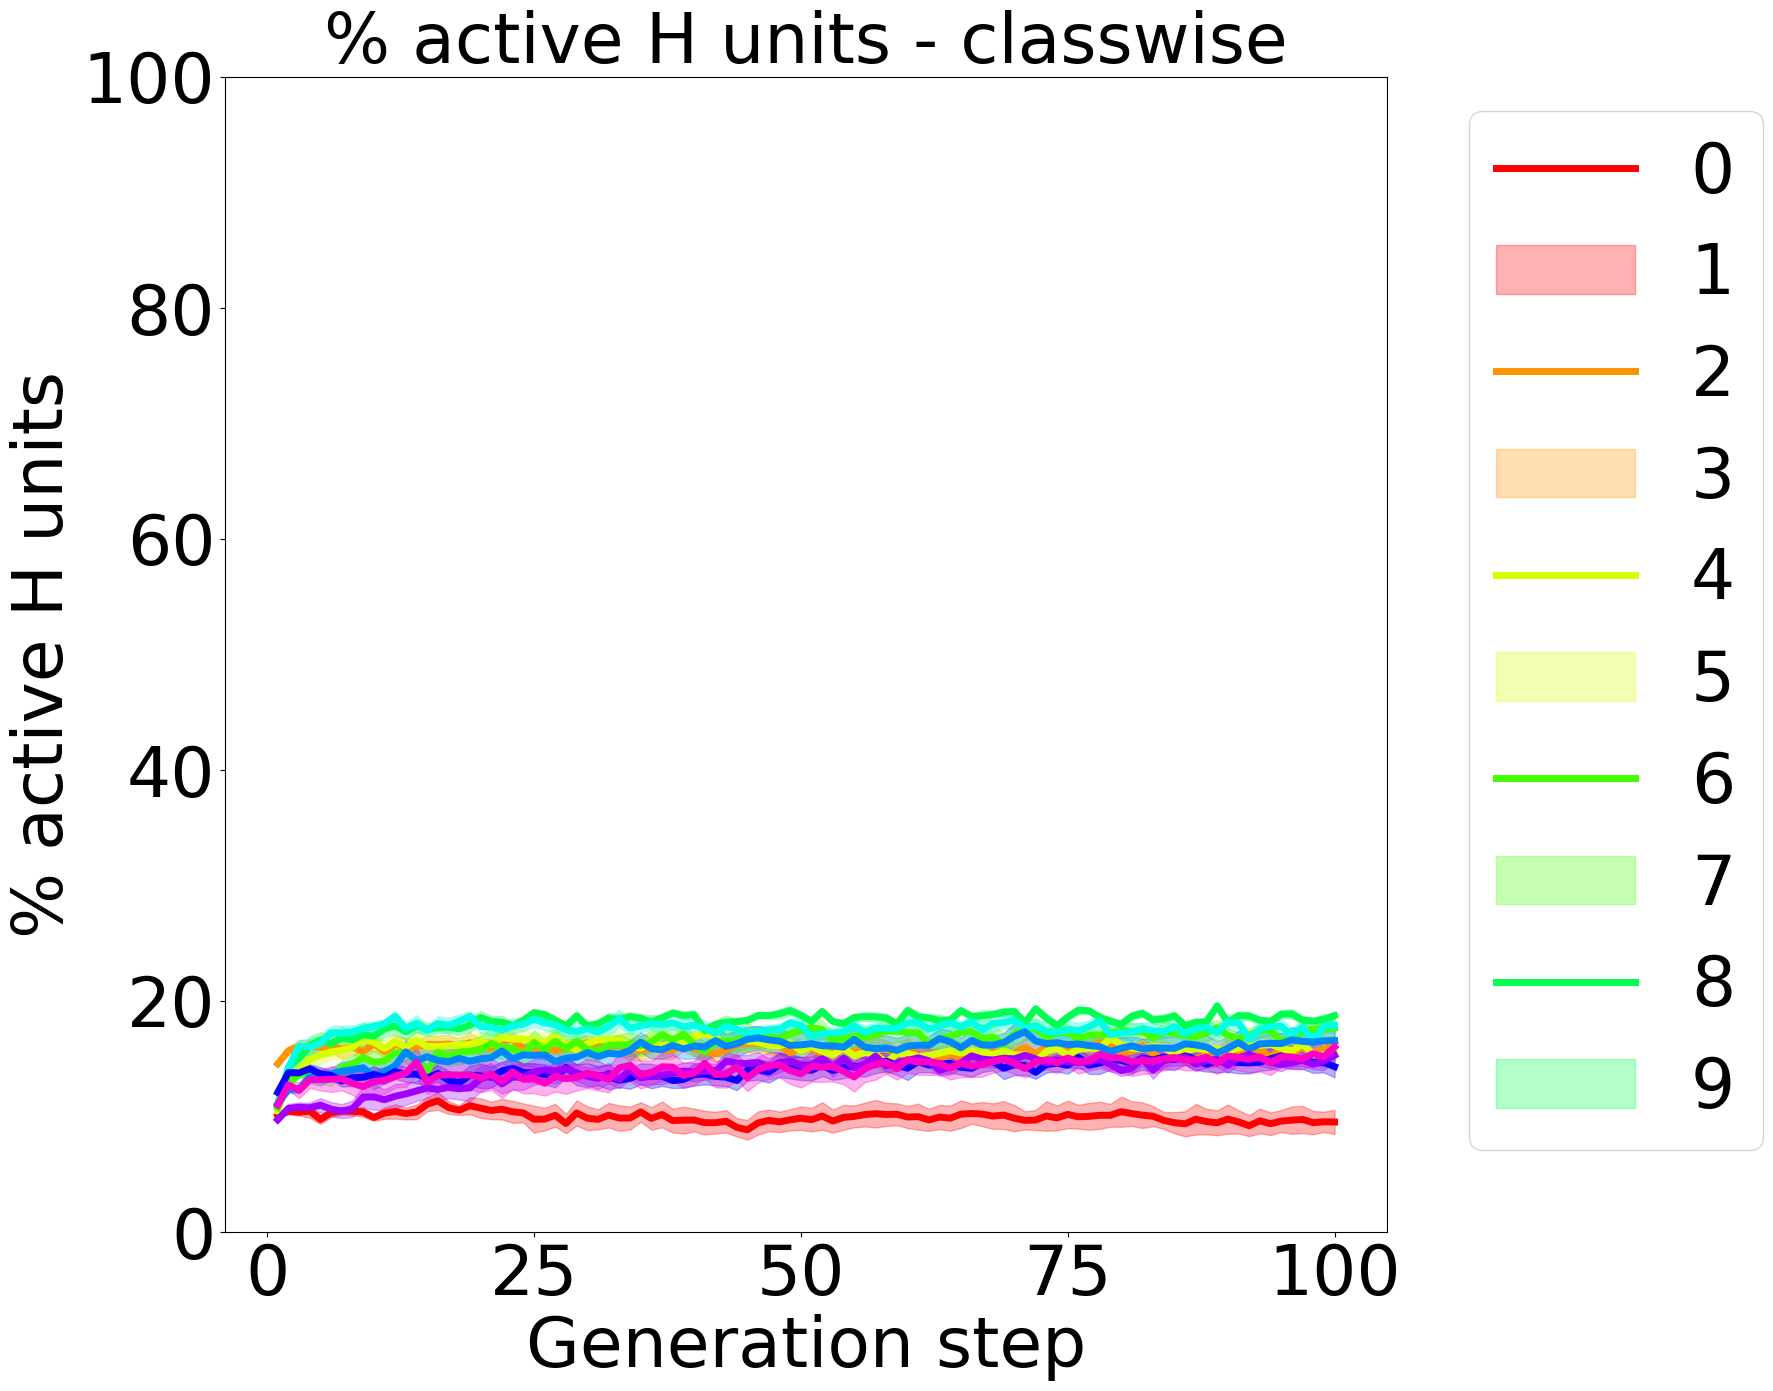

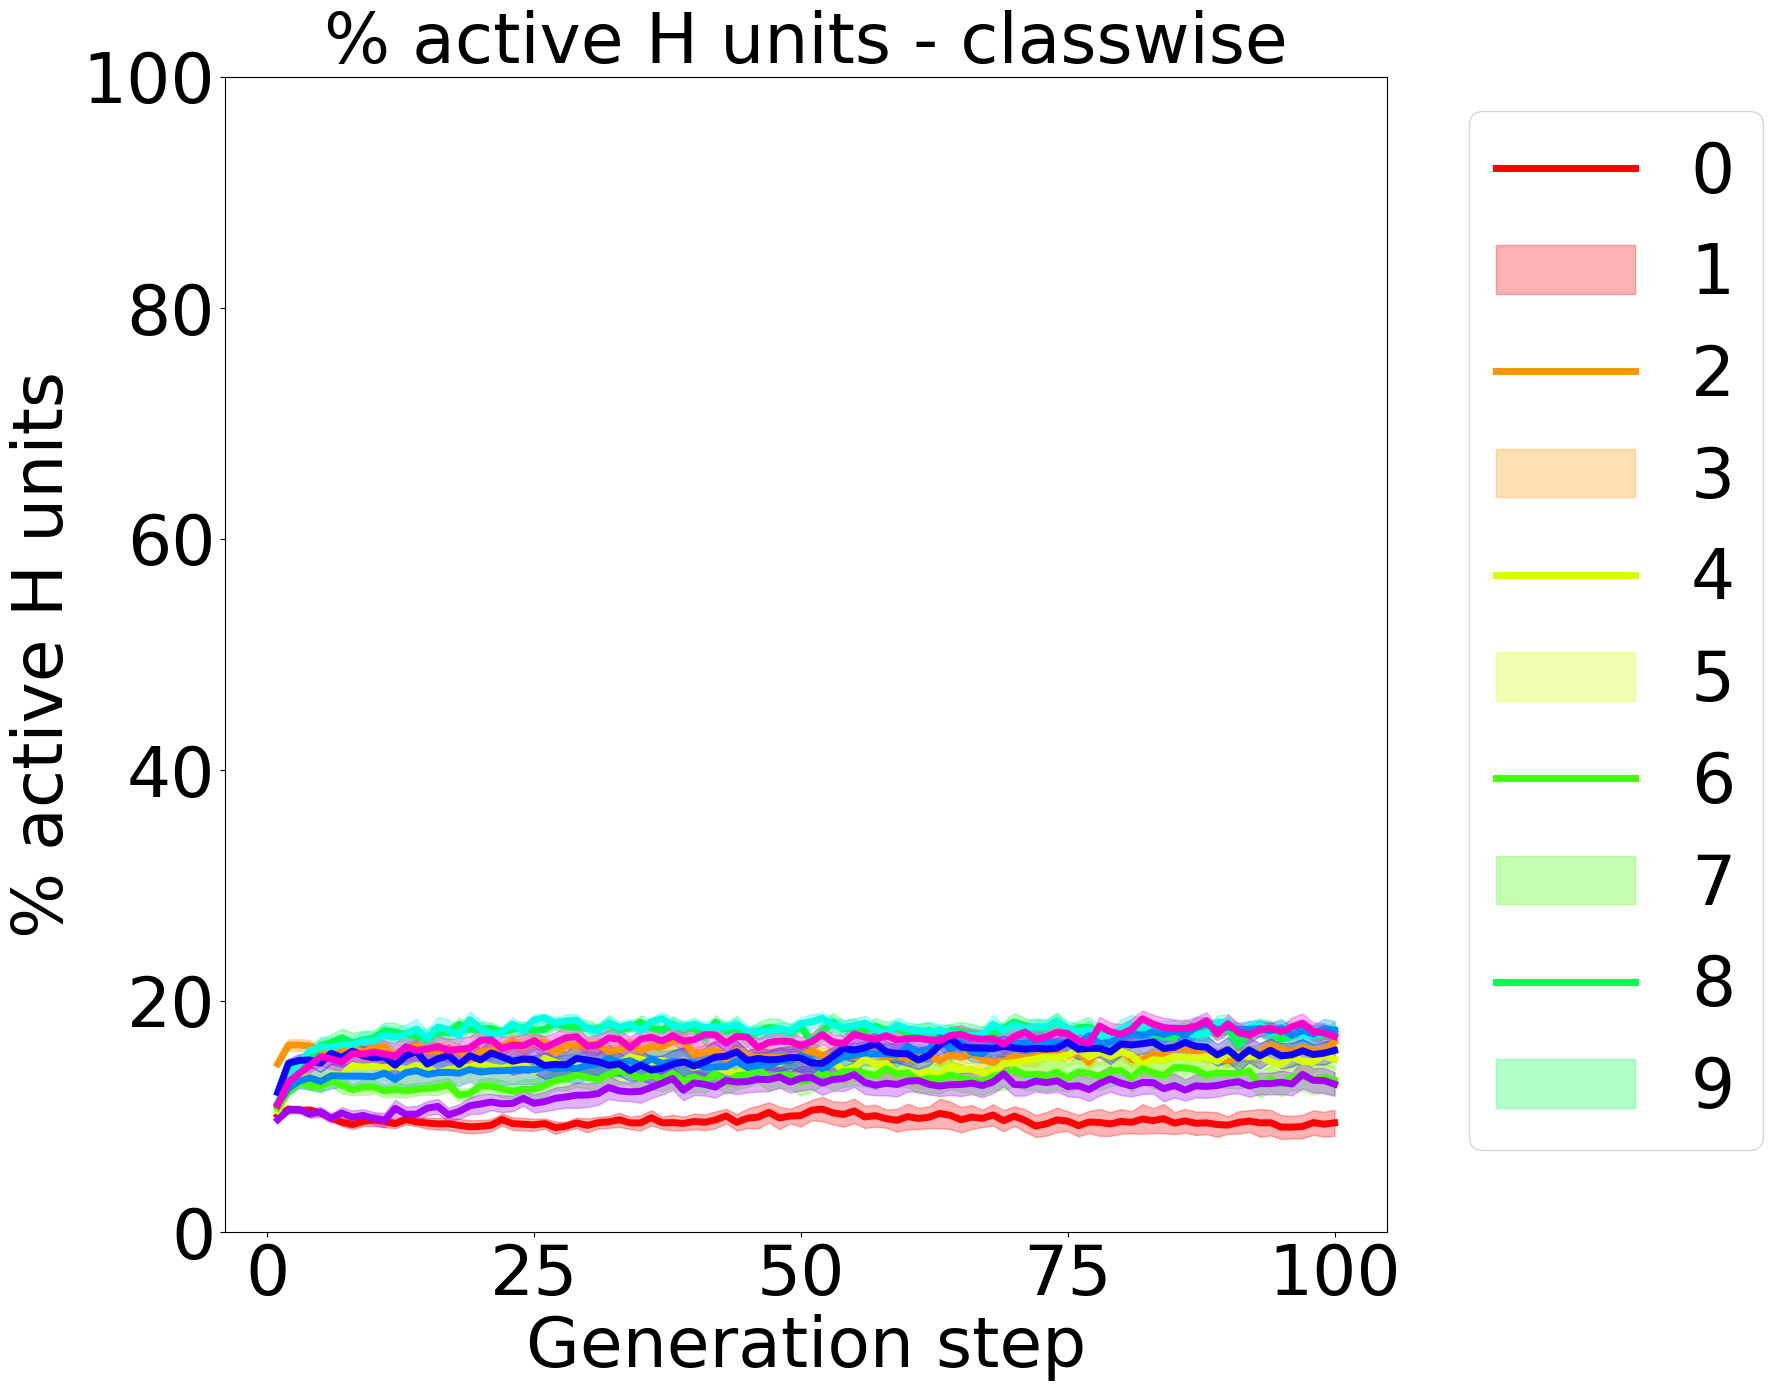

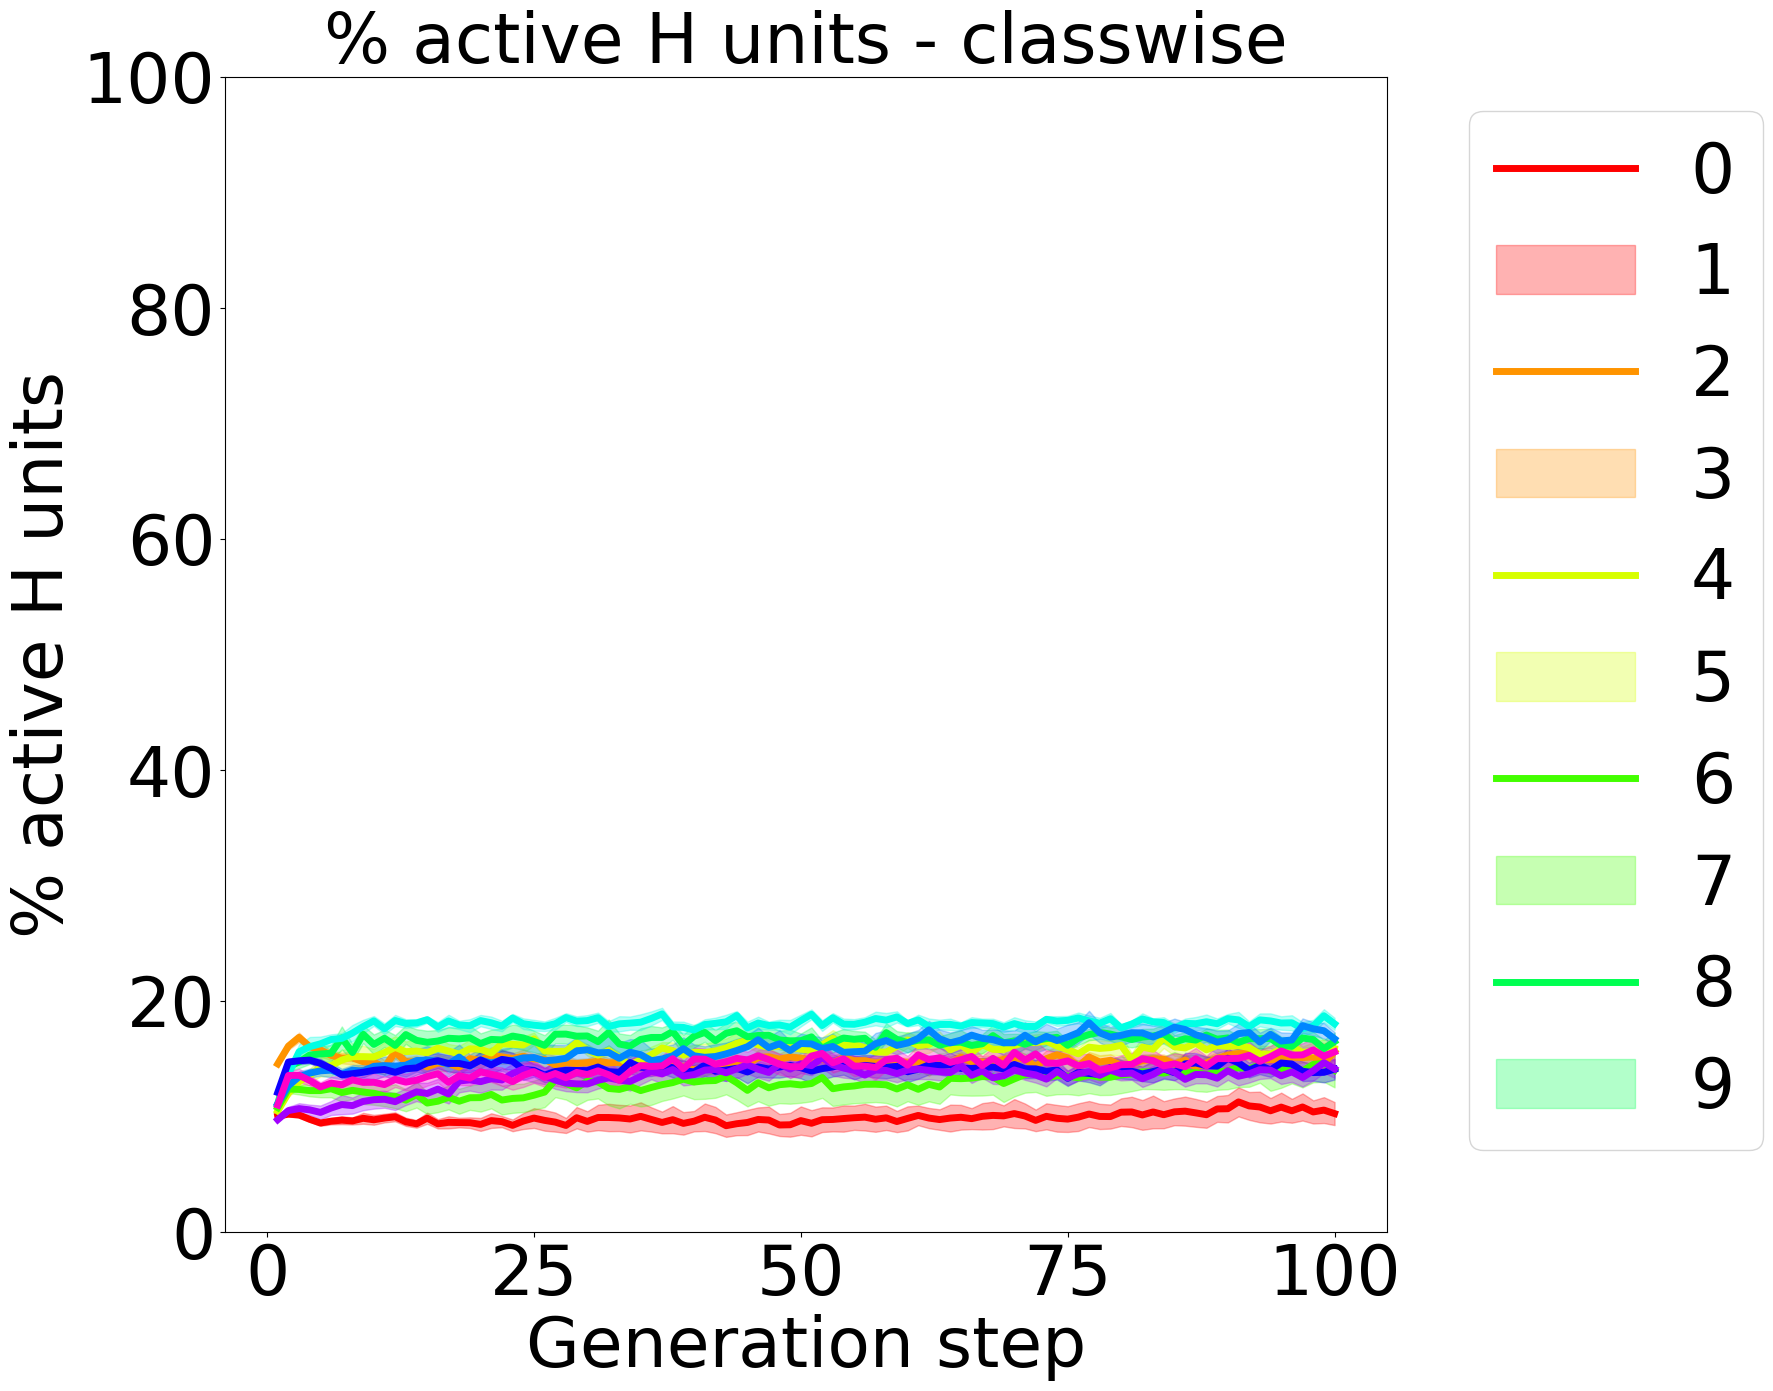

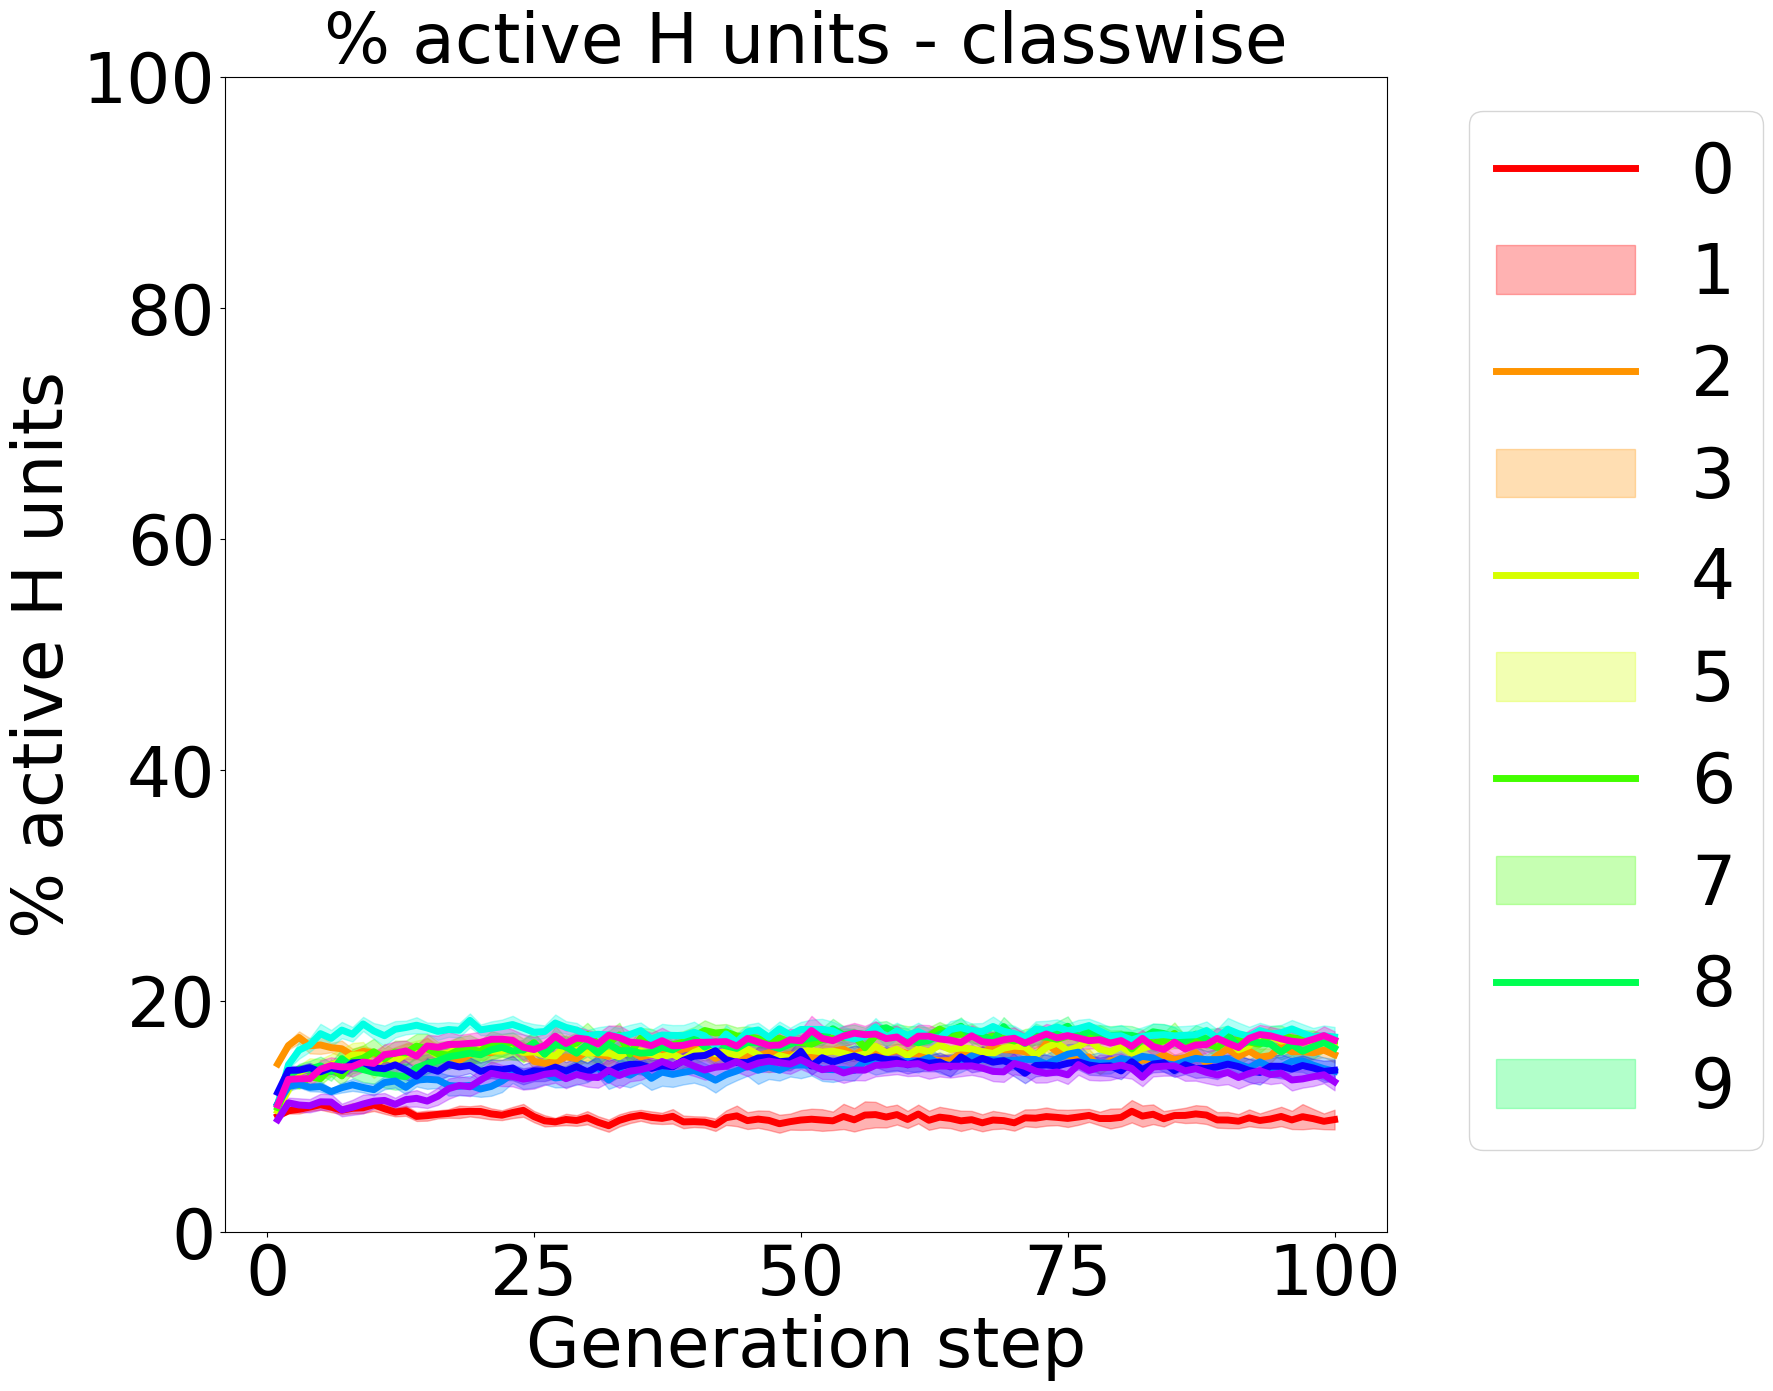

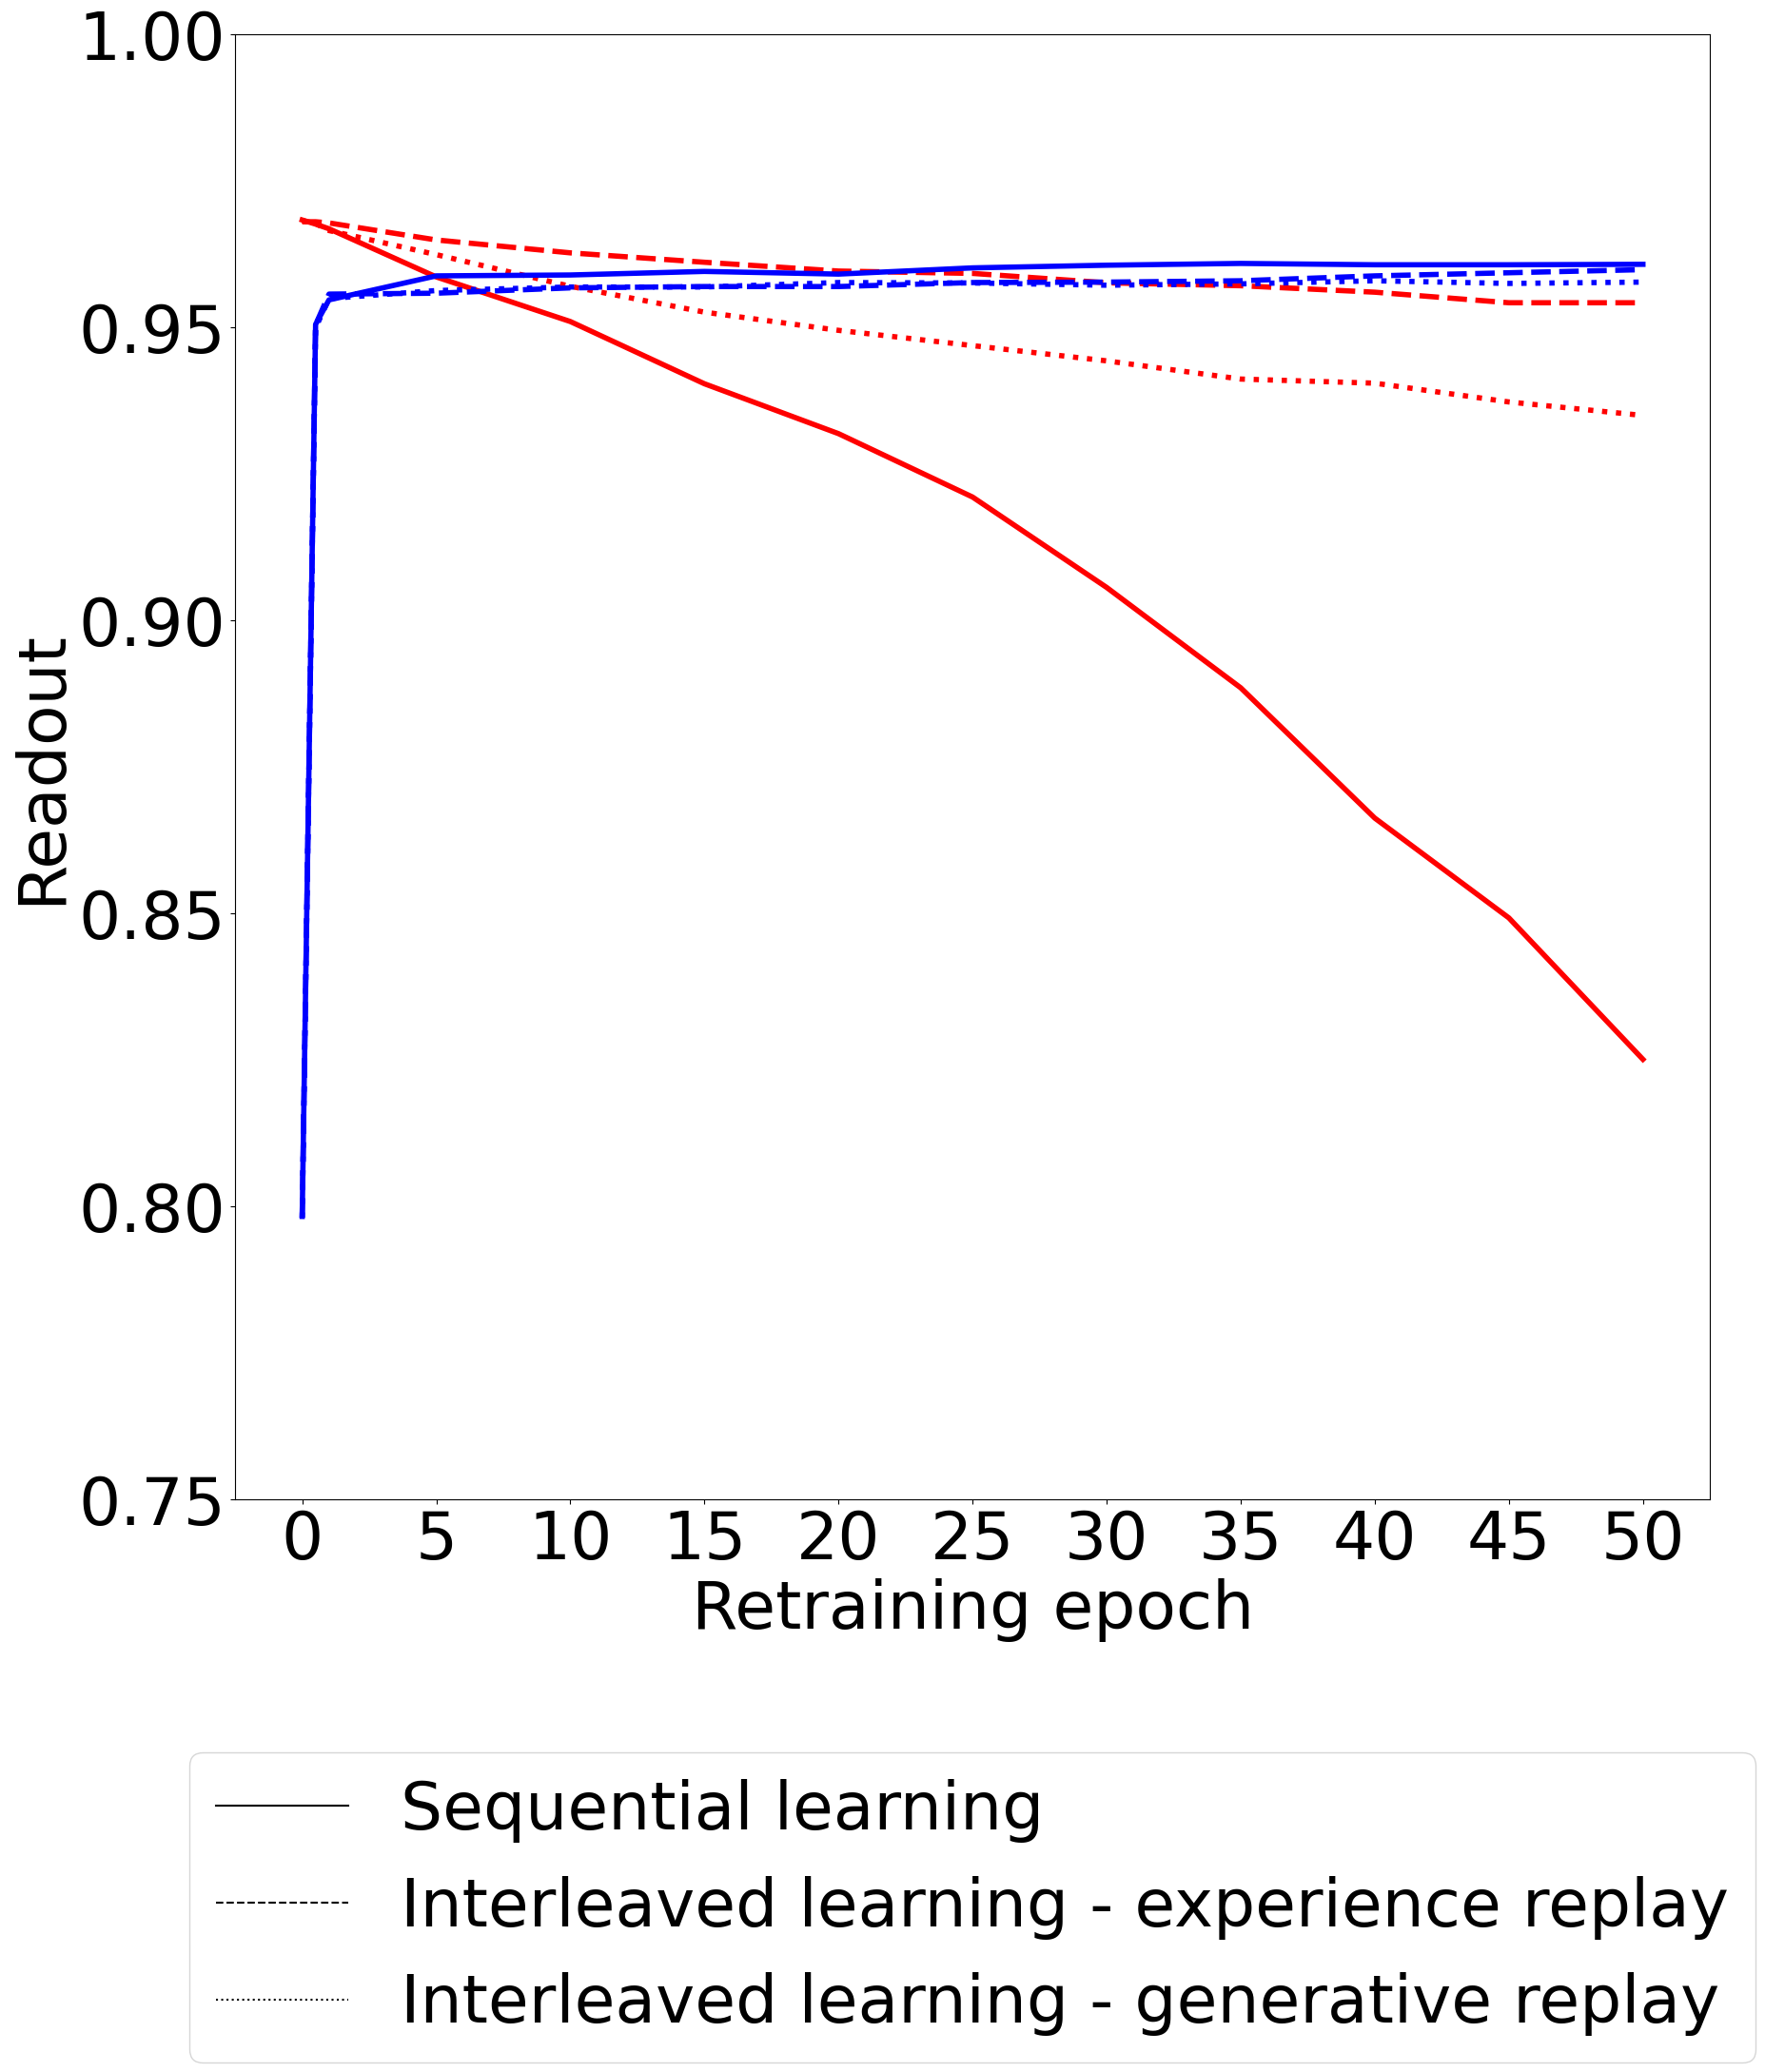

In [6]:
#Continual learning - example with EMNIST
Readouts = readout_comparison(dbn, classifier,train_dataset,test_dataset,mixing_type_options = ['[]','origMNIST','chimeras'], retr_DS = 'EMNIST',H_type = 'det', new_retrain_dataV = False)